In [2]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import re
import numpy as np

pd.set_option('display.max_rows',    None)   # no row limit
pd.set_option('display.max_columns', None)   # no column limit
pd.set_option('display.width',       1000)   # wide display
pd.set_option('display.max_colwidth', 100)   # wrap long cells at 100 chars


In [3]:

def plot_inertia(
    df,
    partionning_space="true_proba_error",
    n_samples_train=None,
    n_samples_test=None,
    cluster_value=None,
    seed_test=None,
):
    """
    Two‐panel plot: 
    – Left:  FPR_train vs Inertia
    – Right: FPR_val   vs Inertia

    On each panel we plot all seeds’ scatter and overlay
    a single overall least‐squares line. Legends are removed.
    """
    # filter once
    df_c = df[
        (df['clustering_n_clusters'] == cluster_value) &
        (df['data_n_samples_train'] == n_samples_train) &
        df['inertia'].notnull() &
        df['fpr_train'].notnull() &
        df['fpr_val'].notnull() &
        (df['data_seed_test'] == seed_test) &
        (df["data_n_samples_test"] == n_samples_test) &
        (df['clustering_name'] == "kmeans") &
        (df["clustering_space"] == partionning_space)
    ]
    print(df_c)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
    y_cols = ['fpr_train', 'fpr_val']
    y_labels = ['FPR (train)', 'FPR (validation)']

    # for each subplot
    for ax, y_col, y_lab in zip(axes, y_cols, y_labels):
        # scatter per‐seed
        for seed in sorted(df_c['clustering_seed'].unique()):
            sub = df_c[df_c['clustering_seed'] == seed].sort_values('inertia')
            ax.plot(
                sub['inertia'],
                sub[y_col],
                marker='o',
                linestyle='',
                alpha=0.5
            )

        # overall LS fit
        x_all = df_c['inertia'].values
        y_all = df_c[y_col].values
        if len(x_all) >= 2:
            m, b = np.polyfit(x_all, y_all, 1)
            x_fit = np.linspace(x_all.min(), x_all.max(), 100)
            ax.plot(
                x_fit,
                m * x_fit + b,
                linestyle='-',
                linewidth=2,
                color='black'
            )

        ax.set_xlabel('Inertia')
        ax.set_ylabel(y_lab)
        ax.grid(True)

    fig.suptitle(f'n_clusters={cluster_value}, n_samples_train={n_samples_train}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.close()



def plot_experiment_histograms(experiment_dfs,
                               score_col='val_detector_preds',
                               label_col='val_detector_labels',
                               labels=('No error', 'Error'),
                               bins=60):
    """
    Plots normalized-frequency histograms of `score_col` for label=False vs label=True
    for each experiment DataFrame in `experiment_dfs`.

    Parameters
    ----------
    experiment_dfs : dict[str, pd.DataFrame]
        Mapping from experiment name to its predictions DataFrame.
    score_col : str
        Column name of the score/prediction.
    label_col : str
        Column name of the boolean true label.
    labels : tuple[str, str]
        (label for False, label for True)
    bins : int
        Number of histogram bins.
    """
    n = len(experiment_dfs)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5), sharey=True)
    if n == 1:
        axes = [axes]

    for ax, (exp_name, df) in zip(axes, experiment_dfs.items()):
        # compute common bin edges
        all_scores = df[score_col]
        bin_edges = np.linspace(all_scores.min(), all_scores.max(), bins)

        # split scores by label
        scores_0 = df.loc[~df[label_col], score_col]
        scores_1 = df.loc[df[label_col],  score_col]

        # plot
        ax.hist(scores_0, bins=bin_edges, density=True, alpha=0.5, label=labels[0])
        ax.hist(scores_1, bins=bin_edges, density=True, alpha=0.5, label=labels[1])

        ax.set_title(exp_name)
        ax.set_xlabel('Detecttion Score')
        if ax is axes[0]:
            ax.set_ylabel('Normalized Frequency')
        ax.legend(title='True Label')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

def plot_fpr_2(
    df,
    method="uniform",
    partionning_space="gini",
    cluster_values=None,
    init_scheme=None,
    seed_test=None,
    n_samples_train_inf=None,
    n_samples_train_sup=None,
    ylim=None,  # new argument: e.g. (0.0, 0.1)
):
    # ---- SETUP FIGURE ----
    n_values = len(cluster_values)
    fig, axes = plt.subplots(1, n_values, figsize=(14, 5), sharey=True)
    fig.suptitle(f"{method} partition on {partionning_space}")
    if n_values == 1:
        axes = [axes]
    for ax, cluster_value in zip(axes, cluster_values):
        # 1) Filter for this cluster
        df_c = df[
            (df['clustering_n_clusters'] == cluster_value) &
            (df['data_n_samples_train'] >= n_samples_train_inf) &
            (df['data_n_samples_train'] <= n_samples_train_sup) &
            df['fpr_val'].notnull() &
            (df['data_seed_test'] == seed_test) &
            (df['clustering_name'] == method) &
            (df['clustering_space'] == partionning_space )&
             (df['clustering_init_scheme'] == init_scheme )
        ]
        # 2) Scatter/line for each seed_train
        for seed_train in sorted(df_c['data_seed_train'].unique()):
            df_s = df_c[df_c['data_seed_train'] == seed_train].sort_values('data_n_samples_train')
            ax.plot(
                df_s['data_n_samples_train'],
                df_s['fpr_val'],
                marker='o',
                linestyle='-',
                alpha=0.6,
                label=f"seed {seed_train}"
            )
        
        # 3) Compute mean & std at each n_samples_train
        stats = (
            df_c
            .groupby('data_n_samples_train')['fpr_val']
            .agg(['mean', 'std'])
            .reset_index()
        )
        # ax.hlines(gini_experiment["fpr_val"].item(), xmin=n_samples_train_inf, xmax=n_samples_train_sup,
        #         color="red", linestyle="--", label="Gini Detector FPR")
        # 4) Plot mean line
        ax.plot(
            stats['data_n_samples_train'],
            stats['mean'],
            color='black',
            linewidth=2,
            label='Mean'
        )
        # 5) Shade ±1 STD
        ax.fill_between(
            stats['data_n_samples_train'],
            stats['mean'] - stats['std'],
            stats['mean'] + stats['std'],
            color='gray',
            alpha=0.3,
            label='±1 STD'
        )
        
        # 6) Decorations
        ax.set_title(f'n_clusters = {cluster_value}')
        ax.set_xlabel('n_samples_train')
        if ax is axes[0]:
            ax.set_ylabel('FPR (validation)')
        ax.grid(True)
        ax.set_xlim(n_samples_train_inf, n_samples_train_sup)
        
        # 7) Apply y-axis limits if provided
        if ylim is not None:
            ax.set_ylim(ylim)
        
        ax.legend(title='Seed_train', bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
    plt.close()

def plot_fpr_method_comparison(
    df,
    cluster_values,
    seed_test,
    n_samples_train_inf,
    n_samples_train_sup,
    ylim=None,  # e.g. (0.0, 0.1)
):
    """
    Plots FPR curves for two methods ("uniform" vs "kmeans") across different numbers of clusters.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns ['n_clusters','n_samples_train','fpr_val','seed_test','seed_train','method'].
    cluster_values : list of int
        The distinct n_clusters to plot (one row per cluster).
    seed_test : int
        The seed_test value to filter for.
    n_samples_train_inf : int
        Minimum n_samples_train to include.
    n_samples_train_sup : int
        Maximum n_samples_train to include.
    ylim : tuple or None
        y‐axis limits (min, max); if None, auto‐scaled.
    """
    methods = ["uniform", "kmeans"]
    n_values = len(cluster_values)
    
    fig, axes = plt.subplots(
        nrows=n_values,
        ncols=2,
        figsize=(14, 5 * n_values),
        sharey=True
    )
    
    # Add column headers
    for j, method in enumerate(methods):
        axes[0, j].set_title(f"{method.capitalize()} method", fontsize=14, pad=20)
    
    for i, cluster_value in enumerate(cluster_values):
        for j, method in enumerate(methods):
            ax = axes[i, j]
            
            # 1) Filter for cluster & method
            df_c = df[
                (df["clustering_n_clusters"] == cluster_value) &
                (df["data_n_samples_train"] >= n_samples_train_inf) &
                (df["data_n_samples_train"] <= n_samples_train_sup) &
                df["fpr_val"].notnull() &
                (df["data_seed_test"] == seed_test) &
                (df["clustering_name"] == method) &
            (df["clustering_space"].isna())
            ]
            
            # 2) Plot each seed_train
            for seed_train in sorted(df_c["data_seed_train"].unique()):
                df_s = df_c[df_c["data_seed_train"] == seed_train].sort_values("data_n_samples_train")
                ax.plot(
                    df_s["data_n_samples_train"],
                    df_s["fpr_val"],
                    marker="o",
                    linestyle="-",
                    alpha=0.6,
                    label=f"seed {seed_train}"
                )
            
            # 3) Compute mean & std at each n_samples_train
            stats = (
                df_c
                .groupby("data_n_samples_train")["fpr_val"]
                .agg(["mean", "std"])
                .reset_index()
            )
            
            # 4) Plot mean line
            ax.plot(
                stats["data_n_samples_train"],
                stats["mean"],
                color="black",
                linewidth=2,
                label="Mean"
            )
            
            # 5) Shade ±1 STD
            ax.fill_between(
                stats["data_n_samples_train"],
                stats["mean"] - stats["std"],
                stats["mean"] + stats["std"],
                color="gray",
                alpha=0.3,
                label="±1 STD"
            )
            ax.hlines(
                bayes_experiment["fpr_val"].item(),
                xmin=n_samples_train_inf,
                xmax=n_samples_train_sup,
                color="red",
                linestyle="--",
                label="Bayes Detector FPR"
        )
            # 6) Decorations
            ax.set_xlabel("n_samples_train")
            if j == 0:
                ax.set_ylabel("FPR (validation)")
            ax.set_xlim(n_samples_train_inf, n_samples_train_sup)
            if ylim is not None:
                ax.set_ylim(ylim)
            ax.grid(True)
            ax.legend(title="Seed_train", bbox_to_anchor=(1.02, 1), loc="upper left")
            
            # 7) Row title on leftmost plots
            if j == 0:
                ax.text(
                    -0.2, 0.5,
                    f"n_clusters = {cluster_value}",
                    transform=ax.transAxes,
                    rotation=90,
                    va="center",
                    fontsize=12
                )
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    


def plot_fpr(
    df,
    method="uniform",
    cluster_values=None,
    seed_test=None,
    n_samples_train_inf=None,
    n_samples_train_sup=None,
    ylim=None,  # new argument: e.g. (0.0, 0.1)
):
    """
    Plots FPR curves for each seed_train across different n_clusters,
    then adds one shared legend without duplicate entries.
    """
    # ---- SETUP FIGURE ----
    n_values = len(cluster_values)
    fig, axes = plt.subplots(1, n_values, figsize=(14, 5), sharey=True)
    if n_values == 1:
        axes = [axes]
    fig.suptitle(f"Method: {method}")

    for ax, cluster_value in zip(axes, cluster_values):
        # 1) Filter for this cluster
        df_c = df[
            (df['clustering_n_clusters'] == cluster_value) &
            (df['data_n_samples_train'] >= n_samples_train_inf) &
            (df['data_n_samples_train'] <= n_samples_train_sup) &
            df['fpr_val'].notnull() &
            (df['data_seed_test'] == seed_test) &
            (df['clustering_name'] == method) &
            (df["clustering_space"].isna())
        ]

        # 2) Scatter/line for each seed_train
        for seed_train in sorted(df_c['data_seed_train'].unique()):
            df_s = df_c[df_c['data_seed_train'] == seed_train].sort_values('data_n_samples_train')
            ax.plot(
                df_s['data_n_samples_train'],
                df_s['fpr_val'],
                marker='o',
                linestyle='-',
                alpha=0.6,
                label=f"seed {seed_train}"
            )

        # 3) Compute mean & std at each n_samples_train
        stats = (
            df_c
            .groupby('data_n_samples_train')['fpr_val']
            .agg(['mean', 'std'])
            .reset_index()
        )

        # 4) Reference line for Bayes Detector FPR
        ax.hlines(
            bayes_experiment["fpr_val"].item(),
            xmin=n_samples_train_inf,
            xmax=n_samples_train_sup,
            color="red",
            linestyle="--",
            label="Bayes Detector FPR"
        )

        # 5) Plot mean line
        ax.plot(
            stats['data_n_samples_train'],
            stats['mean'],
            color='black',
            linewidth=2,
            label='Mean'
        )

        # 6) Shade ±1 STD
        ax.fill_between(
            stats['data_n_samples_train'],
            stats['mean'] - stats['std'],
            stats['mean'] + stats['std'],
            color='gray',
            alpha=0.3,
            label='±1 STD'
        )

        # 7) Decorations
        ax.set_title(f'n_clusters = {cluster_value}')
        ax.set_xlabel('n_samples_train')
        if ax is axes[0]:
            ax.set_ylabel('FPR (validation)')
        ax.grid(True)
        ax.set_xlim(n_samples_train_inf, n_samples_train_sup)
        if ylim is not None:
            ax.set_ylim(ylim)

    # ——— AFTER THE LOOP: SHARED LEGEND WITHOUT DUPLICATES ———
    # 1) Collect all handles & labels
    all_handles = []
    all_labels = []
    for ax in axes:
        handles, labels = ax.get_legend_handles_labels()
        all_handles.extend(handles)
        all_labels.extend(labels)

    # 2) Remove duplicate labels (preserve order)
    unique = {}
    for h, l in zip(all_handles, all_labels):
        if l not in unique:
            unique[l] = h
    unique_labels = list(unique.keys())
    unique_handles = [unique[l] for l in unique_labels]

    # 3) Add a single legend to the figure
    fig.legend(
        unique_handles,
        unique_labels,
        title="Series",
        loc="upper right",
        bbox_to_anchor=(1.15, 0.9)
    )

    # 4) Make room and finalize
    plt.subplots_adjust(right=0.82)
    plt.tight_layout()
    plt.show()
    plt.close()


def collect_experiment_comparison_data(results_dir):
    """
    Scans the results/experiments directory, reads each experiment folder,
    and collects all configuration parameters along with the mean and std for 
    each accuracy metric (fpr, auc, aurc) from train and test CSV files.
    
    For fpr, the mean is computed as before. The standard deviation for fpr is computed as:
      - If all folds provided a var_fpr value: new_std = sqrt(sum(var_fpr) / (n_fold^2))
      - Otherwise: new_std = standard deviation of the fpr values.
    For auc and aurc, mean and std are computed in the standard way.
    
    Args:
        results_dir (str): Base directory containing the experiments folder.
        
    Returns:
        DataFrame: DataFrame where each row corresponds to an experiment and 
                   columns include all configuration parameters and the computed metrics.
    """
    experiment_dirs = [
        os.path.join(results_dir, d)
        for d in os.listdir(results_dir)
        if os.path.isdir(os.path.join(results_dir, d)) and d.startswith("experiment_")
    ]
    
    records = []
    

    for exp_dir in tqdm(experiment_dirs, desc="Processing experiment directories"):

        record = {}
        config_path = os.path.join(exp_dir, "config.json")
        if not os.path.exists(config_path):
            print(f"Config file not found in {exp_dir}. Skipping...")
            continue
        
        with open(config_path, "r") as f:
            config = json.load(f)
        config = pd.json_normalize(config, sep="_").to_dict(orient="records")[0]
        if config["experiment_folder"] is None:
            config["experiment_folder"] = os.path.basename(exp_dir) 
        record.update(config)
        
                
        # Process test fold CSVs.
        results_path = os.path.join(exp_dir, "detector_results.csv")
        if not os.path.exists(results_path):
            print(f"Results file not found in {results_path}. Skipping...")
            continue
        df = pd.read_csv(results_path)
        row = df.iloc[0]
        record.update(row.to_dict())
  
        
        records.append(record)
    
    if not records:
        print("No experiment records found.")
        return None
    
    df = pd.DataFrame(records)
    if "fpr" in df.columns:
        df.sort_values(by="fpr", inplace=True, na_position="last")
    return df


import matplotlib.pyplot as plt

def plot_fpr_method_comparison_2(
    df,
    cluster_values,
    seed_test,
    n_samples_train_inf,
    n_samples_train_sup,
    clustering_seed = {"kmeans" : 0, "soft-kmeans" : 0},
    clustering_space="true_proba_error",
    methods=["kmeans", "kmeans++"],
    init_scheme = {"kmeans" : "kmeans++", "kmeans++" : "kmeans++"},
    ylim=None  # e.g. (0.0, 0.1)
):
    """
    Plots FPR curves for multiple clustering methods across different numbers of clusters.

    Each subplot corresponds to a value in cluster_values and shows the mean FPR ±1 STD for each method.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns ['clustering_n_clusters', 'data_n_samples_train', 'fpr_val',
        'data_seed_test', 'data_seed_train', 'clustering_name', 'clustering_space'].
    cluster_values : list of int
        The distinct clustering_n_clusters to plot (one subplot per cluster).
    seed_test : int
        The seed_test value to filter for.
    n_samples_train_inf : int
        Minimum n_samples_train to include (x-axis lower bound).
    n_samples_train_sup : int
        Maximum n_samples_train to include (x-axis upper bound).
    methods : list of str
        Clustering methods to compare (e.g., ["uniform", "kmeans"]).
    ylim : tuple or None
        y-axis limits (min, max); if None, auto-scaled.
    """
    n_plots = len(cluster_values)
    fig, axes = plt.subplots(
        nrows=n_plots,
        ncols=1,
        figsize=(10, 5 * n_plots),
        sharex=True,
        sharey=True
    )

    # Ensure axes is iterable
    if n_plots == 1:
        axes = [axes]

    # Loop over clusters
    for ax, cluster_value in zip(axes, cluster_values):
        # Loop over methods
        for method in methods:
            # Filter DataFrame
            df_c = df[
                (df['clustering_n_clusters'] == cluster_value) &
                (df['data_n_samples_train'] >= n_samples_train_inf) &
                (df['data_n_samples_train'] <= n_samples_train_sup) &
                df['fpr_val'].notnull() &
                (df['data_seed_test'] == seed_test) &
                (df['clustering_name'] == method) &
                (df["clustering_space"].eq(partionning_space) 
               | df["clustering_space"].isna()) &
                (df['clustering_init_scheme'] == init_scheme[method]) &
                (df['clustering_seed'] == clustering_seed[method])

            ]
            print(method, len(df_c))
            # Compute mean and std
            stats = (
                df_c
                .groupby('data_n_samples_train')['fpr_val']
                .agg(['mean', 'std'])
                .reset_index()
            )

            # Plot mean curve
            ax.plot(
                stats['data_n_samples_train'],
                stats['mean'],
                marker='o',
                linestyle='-',
                label=f"{method.capitalize()} mean"
            )
            # Shade ±1 STD
            ax.fill_between(
                stats['data_n_samples_train'],
                stats['mean'] - stats['std'],
                stats['mean'] + stats['std'],
                alpha=0.3,
                label=f"{method.capitalize()} ±1 STD"
            )

        # Plot Bayes Detector FPR if available
        try:
            bayes_fpr = bayes_experiment['fpr_val'].item()
            ax.hlines(
                bayes_fpr,
                xmin=n_samples_train_inf,
                xmax=n_samples_train_sup,
                color='red',
                linestyle='--',
                label='Bayes Detector FPR'
            )
        except Exception:
            pass

        # Decorations
        ax.set_title(f"n_clusters = {cluster_value}", fontsize=14)
        ax.set_xlabel("n_samples_train")
        ax.set_ylabel("FPR (validation)")
        ax.set_xlim(n_samples_train_inf, n_samples_train_sup)
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.grid(True)
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

def plot_fpr_method_comparison_2(
    df,
    cluster_values,
    seed_test,
    n_samples_train_inf,
    n_samples_train_sup,
    clustering_seed={"kmeans": 0, "soft-kmeans": 0},
    clustering_space="true_proba_error",
    methods=["kmeans", "soft-kmeans"],
    init_scheme={"kmeans": "kmeans++", "soft-kmeans": "kmeans++"},
    ylim=None  # e.g. (0.0, 0.1)
):
    """
    Plots FPR curves for multiple clustering methods across different numbers of clusters.

    Subplots are arranged in a grid with 2 columns and enough rows to accommodate all cluster_values.
    Each subplot corresponds to a value in cluster_values and shows the mean FPR ±1 STD for each method.
    """
    n_plots = len(cluster_values)
    n_cols = 2
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(12, 5 * n_rows),
        sharex=True,
        sharey=True
    )
    axes = axes.flatten()

    for idx, cluster_value in enumerate(cluster_values):
        ax = axes[idx]
        for method in methods:
            df_c = df[
                (df['clustering_n_clusters'] == cluster_value) &
                (df['data_n_samples_train'] >= n_samples_train_inf) &
                (df['data_n_samples_train'] <= n_samples_train_sup) &
                df['fpr_val'].notnull() &
                (df['data_seed_test'] == seed_test) &
                (df['clustering_name'] == method) &
                ((df['clustering_space'] == clustering_space) | df['clustering_space'].isna()) &
                (df['clustering_init_scheme'] == init_scheme[method]) &
                (df['clustering_seed'] == clustering_seed[method])
            ]
            print(method, cluster_value, df_c["data_seed_train"].unique())

            stats = (
                df_c.groupby('data_n_samples_train')['fpr_val']
                    .agg(['mean', 'std'])
                    .reset_index()
            )

            ax.plot(
                stats['data_n_samples_train'],
                stats['mean'],
                marker='o',
                linestyle='-',
                label=f"{method} mean"
            )
            ax.fill_between(
                stats['data_n_samples_train'],
                stats['mean'] - stats['std'],
                stats['mean'] + stats['std'],
                alpha=0.3,
                label=f"{method} ±1 STD"
            )

        try:
            bayes_fpr = bayes_experiment['fpr_val'].item()
            ax.hlines(
                bayes_fpr,
                xmin=n_samples_train_inf,
                xmax=n_samples_train_sup,
                color='red',
                linestyle='--',
                label='Bayes Detector FPR'
            )
        except Exception:
            pass

        ax.set_title(f"n_clusters = {cluster_value}")
        ax.set_xlabel("n_samples_train")
        ax.set_ylabel("FPR (validation)")
        ax.set_xlim(n_samples_train_inf, n_samples_train_sup)
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.grid(True)
        ax.legend(loc='upper right')

    # Hide unused subplots
    for j in range(n_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()



In [4]:
# RESULTS_DIR = "../../synth_results/checking_reproducibility"
# compile_results = True

# if compile_results:
#     df = collect_experiment_comparison_data(RESULTS_DIR)
#     path = os.path.join(RESULTS_DIR, "all_results.csv")
#     df.to_csv(path, index=False)


# df = collect_experiment_comparison_data(RESULTS_DIR)
# if df is None or df.empty:
#     print("No data to write to CSV.")
# df.head()

In [91]:
pretty_names = {
    "resnet34": "ResNet-34",
    "densenet121": "DenseNet-121",
    "tv": "ResNet-50",
    "cifar10": "CIFAR-10",
    "cifar100": "CIFAR-100",
    "imagenet": "ImageNet-1k",
    "resnet50": "ImageNet",
    "ce": "CE",
    "lognorm": "LogNorm",
    "mixup": "Mixup",
    "regmixup": "RegMixup",
    "openmix": "OpenMix",
    "ensemble": "Ensemble",
    "mc_dropout": "MC-Dropout",
    "max_proba": "MaxProb (ODIN)",
    "gini": "Gini (Doctor)",
    "clustering": "Ours",
    "mlp": "MLP",
    "metric_learning": "Rel-U",
    "msp": "MSP",
}

df_cifar10 = pd.read_csv("../../results/cifar10/all_results.csv")
df_cifar100 = pd.read_csv("../../results/cifar100/all_results.csv")
df_imagenet = pd.read_csv("../../results/imagenet/all_results.csv")

df = pd.concat([df_cifar10, df_cifar100], ignore_index=True)

def make_best_summary(df, perf_col='fpr_val'):
    agg_list = []
    for method in df.method_name.unique():
        sub = df[df.method_name == method].copy()
        hp_cols = [c for c in sub.columns if c.startswith(f"{method}_")]
        grp = (
            sub
            .groupby(['data_name', 'model_name'] + hp_cols, dropna=False)[perf_col]
            .agg(mean='mean', std='std')
            .reset_index()
        )
        grp['method_name'] = method
        agg_list.append(grp)
    agg_df = pd.concat(agg_list, ignore_index=True)

    idx = (
        agg_df
        .groupby(['data_name', 'model_name', 'method_name'])['mean']
        .idxmin()
    )
    best_df = agg_df.loc[idx].reset_index(drop=True)
    best_df['perf_str'] = best_df.apply(
        lambda r: f"{r['mean']:.2f} ± {r['std']:.2f}", axis=1
    )

    summary = (
        best_df
        .pivot(index=['data_name', 'model_name'],
               columns='method_name',
               values='perf_str')
        .sort_index()
    )

        # 5) Rename rows and columns using pretty_names
    #    - The index is a MultiIndex [data_name, model_name]
    summary = summary.rename(
        index={
            **{d: pretty_names.get(d, d) for d in summary.index.get_level_values(0).unique()},
            **{m: pretty_names.get(m, m) for m in summary.index.get_level_values(1).unique()}
        },
        level=0
    ).rename(
        index={**{d: pretty_names.get(d, d) for d in summary.index.get_level_values(1).unique()}},
        level=1
    ).rename(
        columns={m: pretty_names.get(m, m) for m in summary.columns}
    )
    return summary

# Usage
summary_table = make_best_summary(df)
summary_table.index.set_names(['Dataset', 'Model'], inplace=True)

# 2) Give a name to the columns axis (for LaTeX multi-column header)
summary_table.columns.name = 'Method'

# 3) Export to LaTeX
latex_str = summary_table.to_latex(
    caption="Best FPR (mean ± std) by Dataset, Model and Detection Method",
    label="tab:best_fpr_summary",
    bold_rows=True,        # bold the Dataset/Model row labels
    multicolumn=True,      # allow the Method name to span across columns
    multicolumn_format='c',# center the multi-column header
    escape=False           # so characters like “±” stay intact
)


display(summary_table)
table_dir = "../../synth_results/tables"
os.makedirs(table_dir, exist_ok=True)


with open(os.path.join(table_dir,"benchmark_table.tex"), "w") as f:
    f.write(latex_str)


/tmp/ipykernel_2142220/1669265308.py:24: DtypeWarning: Columns (18,22,23,25,28,30,31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cifar10 = pd.read_csv("../../results/cifar10/all_results.csv")


ParserError: Error tokenizing data. C error: Expected 56 fields in line 3415, saw 57


# Reproducibility

```text
// Experience setting
FOR seed_train ← 1 TO 19 DO
    FOR seed_test ← -19 TO -1 DO
        train_dataset ← GENERATE(seed_train)
        test_dataset  ← GENERATE(seed_test)
    END FOR
END FOR



In [3]:
RESULTS_DIR = "../../synth_results/checking_reproducibility"
compile_results = True

if compile_results:
    df = collect_experiment_comparison_data(RESULTS_DIR)
    path = os.path.join(RESULTS_DIR, "all_results.csv")
    df.to_csv(path, index=False)


df = collect_experiment_comparison_data(RESULTS_DIR)
if df is None or df.empty:
    print("No data to write to CSV.")

for method_name in ["metric_learning", "clustering"]:
    print("Method : ", method_name)
    values = df[df["method_name"] == method_name]["fpr_val"]
    print(f"FPR =  {values.mean():.2%} +- {values.std():.2%}") 

Processing experiment directories: 100%|██████████| 722/722 [00:01<00:00, 485.11it/s]

Method :  metric_learning
FPR =  32.27% +- 3.39%
Method :  clustering
FPR =  30.75% +- 3.07%


```text
// Experience setting (Matches the experience on CIFAR10)
seed_data = 1
dataset ← GENERATE(seed_data)

FOR seed_split ← 1 TO 19 DO
    train_dataset, test_dataset ← TRAIN_TEST_SPLIT(dataset, seed_split)
END FOR



In [25]:
RESULTS_DIR = "../../synth_results/checking_reproducibility_split"
compile_results = True

if compile_results:
    df = collect_experiment_comparison_data(RESULTS_DIR)
    path = os.path.join(RESULTS_DIR, "all_results.csv")
    df.to_csv(path, index=False)


df = collect_experiment_comparison_data(RESULTS_DIR)
if df is None or df.empty:
    print("No data to write to CSV.")

df.head()

Processing experiment directories:   0%|          | 0/38 [00:00<?, ?it/s]

Processing experiment directories: 100%|██████████| 38/38 [00:00<00:00, 324.02it/s]


seed      method_name  data_n_samples  data_seed  data_seed_split  data_r  \
0     0  metric_learning           10000          1               13       2   
1     0  metric_learning           10000          1               17       2   
2     0  metric_learning           10000          1               14       2   
3     0       clustering           10000          1                4       2   
4     0  metric_learning           10000          1                3       2   

   data_batch_size_train  data_batch_size_test  metric_learning_lambda  \
0                 100000                100000                     0.5   
1                 100000                100000                     0.5   
2                 100000                100000                     0.5   
3                 100000                100000                     0.5   
4                 100000                100000                     0.5   

   metric_learning_temperature  ... clustering_init_scheme  clustering_space  \
0                          0.5  ...              k-means++              gini   
1                          0.5  ...              k-means++              gini   
2                          0.5  ...              k-means++              gini   
3                          0.5  ...              k-means++              gini   
4                          0.5  ...              k-means++              gini   

   experiment_datetime  experiment_folder fpr_train tpr_train thr_train  \
0  2025-05-23_11-14-18      experiment_13  0.299211  0.951768  0.000153   
1  2025-05-23_11-14-19      experiment_17  0.311991  0.951515  0.000113   
2  2025-05-23_11-14-18      experiment_14  0.347418  0.952229  0.000056   
3  2025-05-23_11-18-02      experiment_23  0.294696  0.950617  0.281288   
4  2025-05-23_11-14-14       experiment_3  0.319753  0.951923  0.000094   

    fpr_val   tpr_val   thr_val  
0  0.311200  0.952000  0.000116  
1  0.343426  0.953191  0.000064  
2  0.291611  0.951020  0.000155  
3  0.320584  0.961702  0.271620  
4  0.349481  0.950617  0.000054  

[5 rows x 24 columns]

In [29]:

for method_name in ["metric_learning", "clustering"]:
    print("Method : ", method_name)
    values = df[df["method_name"] == method_name]["fpr_val"]
    print(f"FPR =  {values.mean():.2%} +- {values.std():.2%}") 

Method :  metric_learning
FPR =  32.60% +- 3.43%
Method :  clustering
FPR =  32.73% +- 3.47%


```text
// Experience setting (Matches the experience on CIFAR10)

dataset ← CIFAR10
FOR seed_split ← 1 TO 10 DO
    model_seed ← seed_split
    model ← GET_MODEL(model_seed)
    train_dataset, test_dataset ← TRAIN_TEST_SPLIT(dataset, seed_split)
END FOR



In [28]:
RESULTS_DIR = "../../synth_results/reproducibility_experience2"
compile_results = True

if compile_results:
    df = collect_experiment_comparison_data(RESULTS_DIR)
    path = os.path.join(RESULTS_DIR, "all_results.csv")
    df.to_csv(path, index=False)


df = collect_experiment_comparison_data(RESULTS_DIR)
if df is None or df.empty:
    print("No data to write to CSV.")

df.head()

Processing experiment directories: 100%|██████████| 10/10 [00:00<00:00, 289.72it/s]


seed      method_name data_name  data_seed_split  data_r  \
0     1  metric_learning   cifar10                3       2   
1     1  metric_learning   cifar10                8       2   
2     1  metric_learning   cifar10                1       2   
3     1  metric_learning   cifar10                6       2   
4     1  metric_learning   cifar10                4       2   

   data_batch_size_train  data_batch_size_test model_name  model_model_seed  \
0                 100000                100000   resnet34                 3   
1                 100000                100000   resnet34                 8   
2                 100000                100000   resnet34                 1   
3                 100000                100000   resnet34                 6   
4                 100000                100000   resnet34                 4   

   metric_learning_lambda  ...  clustering_space clustering_temperature  \
0                     0.5  ...              None                   None   
1                     0.5  ...              None                   None   
2                     0.5  ...              None                   None   
3                     0.5  ...              None                   None   
4                     0.5  ...              None                   None   

   experiment_datetime experiment_folder fpr_train tpr_train thr_train  \
0  2025-05-26_11-32-42      experiment_3  0.246919  0.953052  0.000116   
1  2025-05-26_11-33-09      experiment_8  0.231398  0.951965  0.000115   
2  2025-05-26_11-32-31      experiment_1  0.302651  0.952153  0.000088   
3  2025-05-26_11-32-58      experiment_6  0.264490  0.950226  0.000096   
4  2025-05-26_11-32-48      experiment_4  0.246805  0.951542  0.000105   

    fpr_val   tpr_val   thr_val  
0  0.276195  0.953757  0.000093  
1  0.198841  0.950739  0.000147  
2  0.152730  0.952153  0.000240  
3  0.159008  0.952941  0.000221  
4  0.261761  0.953846  0.000101  

[5 rows x 26 columns]

In [33]:
for method_name in ["metric_learning", "clustering"]:
    print("Method : ", method_name)
    values = df[df["method_name"] == method_name]["fpr_val"]
    print(f"FPR =  {values.mean():.2%} +- {values.std():.2%}") 

Method :  metric_learning
FPR =  23.38% +- 5.23%
Method :  clustering
FPR =  nan% +- nan%


In [34]:
df[["fpr_train", "fpr_val"]].sort_values(by="fpr_val").head(10)

fpr_train   fpr_val
2   0.302651  0.152730
3   0.264490  0.159008
1   0.231398  0.198841
7   0.299769  0.219588
6   0.211647  0.220738
4   0.246805  0.261761
9   0.331306  0.264254
5   0.296482  0.276133
0   0.246919  0.276195
8   0.239180  0.308497

**Train vs test Performance**

In [36]:
RESULTS_DIR = "../../synth_results/reproduction_results.csv"
compile_results = True

if compile_results:
    df = collect_experiment_comparison_data(RESULTS_DIR)
    path = os.path.join(RESULTS_DIR, "all_results.csv")
    df.to_csv(path, index=False)


df = collect_experiment_comparison_data(RESULTS_DIR)
if df is None or df.empty:
    print("No data to write to CSV.")

df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../../synth_results/reproduction_results.csv'

# Synthetic_Experience dim = 3072, n_classes = 10

In [81]:
RESULTS_DIR = "../../synth_results/resnet3072"
compile_results = False

if compile_results:
    df = collect_experiment_comparison_data(RESULTS_DIR)
    path = os.path.join(RESULTS_DIR, "all_results.csv")
    df.to_csv(path, index=False)


df = pd.read_csv(os.path.join(RESULTS_DIR, "all_results.csv"))

print("Df shape", df.shape)
df.head()

Df shape (81, 43)


seed method_name         data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset model_name  model_model_seed  metric_learning_lambda  metric_learning_temperature  gini_temperature gini_normalize_gini  max_proba_temperature  clustering_name  clustering_distance  clustering_n_clusters  clustering_reorder_embs  clustering_seed  clustering_alpha  clustering_init_scheme  clustering_n_init  clustering_space  clustering_cov_type  clustering_temperature  clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train   fpr_val   tpr_val   thr_val
0     1        gini  gaussian_mixture              10      3072           10000          1                2       2                    256                   256                NaN   resnet34                 1                     NaN                          NaN               1.0               False                    NaN              NaN                  NaN                    NaN                      NaN              NaN               NaN                     NaN                NaN               NaN                  NaN                     NaN                        NaN                        NaN                       NaN                               NaN                        NaN  2025-06-24_17-44-27     experiment_47   0.218019   0.950820   0.084392  0.232514  0.950000  0.076350
1     1        gini  gaussian_mixture              10      3072           10000          1                5       2                    256                   256                NaN   resnet34                 1                     NaN                          NaN               0.5               False                    NaN              NaN                  NaN                    NaN                      NaN              NaN               NaN                     NaN                NaN               NaN                  NaN                     NaN                        NaN                        NaN                       NaN                               NaN                        NaN  2025-06-24_17-49-56     experiment_68   0.226419   0.950000   0.001733  0.224401  0.951220  0.001849
2     1        gini  gaussian_mixture              10      3072           10000          1                4       2                    256                   256                NaN   resnet34                 1                     NaN                          NaN               0.7                True                    NaN              NaN                  NaN                    NaN                      NaN              NaN               NaN                     NaN                NaN               NaN                  NaN                     NaN                        NaN                        NaN                       NaN                               NaN                        NaN  2025-06-24_17-36-13     experiment_13   0.208279   0.950777   0.022885  0.223996  0.950820  0.014467
3     1        gini  gaussian_mixture              10      3072           10000          1                7       2                    256                   256                NaN   resnet34                 1                     NaN                          NaN               1.0               False                    NaN              NaN                  NaN                    NaN                      NaN              NaN               NaN                     NaN                NaN               NaN                  NaN                     NaN                        NaN                        NaN                       NaN                               NaN                        NaN  2025-06-24_17-44-36     experiment_52   0.215944   0.951613   0.092441  0.231250  0.950000  0.072422
4     1        gini  gaussian_mixture 

In [79]:
RESULTS_DIR = "../../synth_results/resnet3072_old"
compile_results = False

if compile_results:
    df = collect_experiment_comparison_data(RESULTS_DIR)
    path = os.path.join(RESULTS_DIR, "all_results.csv")
    df.to_csv(path, index=False)


df = pd.read_csv(os.path.join(RESULTS_DIR, "all_results.csv"))

print("Df shape", df.shape)
df.head()

Df shape (231, 33)


seed method_name         data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test model_name  model_model_seed  metric_learning_lambda  metric_learning_temperature clustering_name  clustering_n_clusters  clustering_seed  clustering_alpha clustering_init_scheme clustering_space clustering_cov_type  clustering_temperature  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train   fpr_val   tpr_val   thr_val    inertia  n_iter
0     1  clustering  gaussian_mixture              10      3072           10000          1                4       2                    256                   256   resnet34               NaN                     NaN                          NaN     soft-kmeans                  200.0              0.0              0.05              k-means++          probits           spherical                     1.0  2025-05-28_11-58-47    experiment_164   0.264126   0.953917   0.227657  0.263574  0.955224  0.227657  40.806121    86.0
1     1  clustering  gaussian_mixture              10      3072           10000          1                8       2                    256                   256   resnet34               NaN                     NaN                          NaN     soft-kmeans                  500.0              0.0              0.05              k-means++          probits                diag                     1.0  2025-05-28_12-58-16    experiment_221   0.211693   0.952381   0.329388  0.217177  0.950581  0.304807  46.996254    53.0
2     1  clustering  gaussian_mixture              10      3072           10000          1                4       2                    256                   256   resnet34               NaN                     NaN                          NaN     soft-kmeans                  100.0              0.0              0.05              k-means++          probits                full                     1.0  2025-05-28_11-13-07    experiment_127   0.293254   0.960829   0.186550  0.276944  0.958209  0.196820  44.535910    31.0
3     1  clustering  gaussian_mixture              10      3072           10000          1               10       2                    256                   256   resnet34               NaN                     NaN                          NaN     soft-kmeans                  100.0              0.0              0.05              k-means++          probits           spherical                     1.0  2025-05-28_11-33-23    experiment_148   0.278509   0.950000   0.185388  0.296948  0.953168  0.185388  39.748445    95.0
4     1  clustering  gaussian_mixture              10      3072           10000          1                5       2                    256                   256   resnet34               NaN                     NaN                          NaN     soft-kmeans                  500.0              0.0              0.05              k-means++          probits                tied                     1.0  2025-05-28_12-46-28    experiment_210   0.616223   0.956522   0.067514  0.726304  0.964602  0.062641  26.586115    28.0

In [ ]:
df[""]

In [72]:
method_name = "clustering"
clusterin_space = "probits"
clustering_name = "kmeans"
clusterin_n_clusters = [70 + i for i in range(20)]

df_analysis = df[(df["method_name"] == method_name) 
                #  (df["clustering_space"] == clusterin_space) &\
                    # (df["clustering_name"] == clustering_name)  &\
                    # (df["clustering_n_clusters"].isin(clusterin_n_clusters))
                    ].copy()
group_cols = [

    "clustering_name",
    "clustering_space",
        "clustering_n_clusters",
    "clustering_temperature",
    # "clustering_cov_type",
    
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std", "count"])
    .round(2).sort_values(by="mean", ascending=True)
)
col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(agg)

                                                                               mean   std  count    FPR (%)
clustering_name clustering_space clustering_n_clusters clustering_temperature                              
kmeans          gini             200.0                 1.0                     0.25  0.02     10   25% ± 2%
                probits          500.0                 1.0                     0.25  0.03     10   25% ± 3%
                                 200.0                 1.0                     0.33  0.17     10  33% ± 17%
soft-kmeans     probits          500.0                 1.0                     0.33  0.14     40  33% ± 14%
                                 200.0                 1.0                     0.35  0.16     40  35% ± 16%
                                 50.0                  1.0                     0.39  0.23     40  39% ± 23%
                                 100.0                 1.0                     0.39  0.25     41  39% ± 25%
kmeans          probits     

In [24]:
import pandas as pd

# define the grouping columns exactly as before
group_cols = [
    "method_name",
    # "clustering_name",
    # "clustering_space",
    # "clustering_n_clusters",
    # "clustering_cov_type",
    # "clustering_temperature",
    "gini_temperature",
    "gini_normalize_gini",

]

# compute mean & std, round to 0.01
agg = (
    df
    .groupby(group_cols,  dropna=False)["fpr_val"]
    .agg(["mean", "std"])
    .round(2)
)

# combine into one “mean ± std” string column
agg["mean_±_std"] = agg.apply(
    lambda row: f"{row['mean']:.2%} ± {row['std']:.2%}", 
    axis=1
)

# if you only want to see that string:
result = agg[["mean_±_std"]]

print(result)


                                                      mean_±_std
method_name gini_temperature gini_normalize_gini                
gini        0.5              False                22.00% ± 1.00%
            0.7              True                 23.00% ± 1.00%
            1.0              False                23.00% ± 1.00%
                             True                 23.00% ± 1.00%
            5.0              False                28.00% ± 1.00%
                             True                 28.00% ± 1.00%
            50.0             True                 50.00% ± 3.00%
            100.0            True                 52.00% ± 1.00%


**Faster expe**

**New exp**

In [19]:
RESULTS_DIR = "../../synth_results/resnet3072_kmeans_reduced_pooling.csv"
compile_results = True
path = "../../synth_results/resnet3072_kmeans_reduced_pooling.csv"
df = pd.read_csv(path)



print("Df shape", df.shape)

df.groupby([
    "method_name","clustering_name", 
    "clustering_n_clusters", "reduction_reduction_dim", "reduction_n_neighbors"]).agg({
    "fpr_val": ["mean", "std"]}).reset_index().sort_values(
    by=("fpr_val", "mean"), ascending=True
).drop(columns=["method_name", "clustering_name"])

Df shape (625, 34)


/tmp/ipykernel_714559/541626287.py:15: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ).drop(columns=["method_name", "clustering_name"])


clustering_n_clusters reduction_reduction_dim reduction_n_neighbors  \
                                                                         
3                     50                      10                    20   
11                    50                     100                    20   
7                     50                      50                    20   
19                   100                      50                    20   
2                     50                      10                    15   
14                   100                      10                    15   
10                    50                     100                    15   
18                   100                      50                    15   
6                     50                      50                    15   
15                   100                      10                    20   
5                     50                      50                    10   
21                   100                     100                    10   
1                     50                      10                    10   
13                   100                      10                    10   
17                   100                      50                    10   
9                     50                     100                    10   
25                   200                      10                    20   
24                   200                      10                    15   
0                     50                      10                     5   
23                   200                      10                    10   
8                     50                     100                     5   
16                   100                      50                     5   
12                   100                      10                     5   
20                   100                     100                     5   
4                     50                      50                     5   
27                   200                      50                    10   
26                   200                      50                     5   
22                   200                      10                     5   

     fpr_val            
        mean       std  
3   0.532300  0.050107  
11  0.544058  0.078503  
7   0.545582  0.063555  
19  0.546900  0.082552  
2   0.549780  0.076442  
14  0.554166  0.070804  
10  0.557346  0.060301  
18  0.563206  0.044746  
6   0.570448  0.066350  
15  0.576586  0.067602  
5   0.579992  0.055759  
21  0.583287  0.053611  
1   0.588226  0.058112  
13  0.602385  0.055613  
17  0.602898  0.056513  
9   0.604904  0.054424  
25  0.609618  0.024062  
24  0.623108  0.078033  
0   0.662356  0.064095  
23  0.664150  0.060525  
8   0.672208  0.053081  
16  0.674464  0.073729  
12  0.677461  0.085958  
20  0.687675  0.083670  
4   0.695073  0.078656  
27  0.723317       NaN  
26  0.746696  0.019854  
22  0.750182  0.025549

In [11]:
df.groupby([
    "method_name","clustering_name", 
    "clustering_n_clusters", "reduction_reduction_dim", "reduction_n_neighbors"]).size()

method_name  clustering_name  clustering_n_clusters  reduction_reduction_dim  reduction_n_neighbors
clustering   kmeans           50                     10                       5                        19
                                                                              10                       19
                                                                              15                       19
                                                                              20                       19
                                                     50                       5                        19
                                                                              10                       19
                                                                              15                       19
                                                                              20                       19
                                                    

## Reformatting

In [51]:
dict_insert = {"data_class_subset": "data_batch_size_test",
             "clustering_distance": "clustering_name",
             "clustering_reorder_embs": "clustering_n_clusters",
             "max_proba_temperature" : "gini_normalize_gini"}

for col, value in dict_insert.items():


    insert_at = df.columns.get_loc(value) + 1
    # if the column already exists, skip it
# insert the column full of NaNs
    df.insert(loc=insert_at, 
            column=col, 
            value=np.nan)
    
df.rename(
    columns=lambda col: "reduction_dim" if col == "reduction_reduction_dim"
    else col, inplace=True
)

df.rename(
    columns=lambda col: f"clustering_{col}"
    if col.startswith("reduction_")
    else col,
    inplace=True
)
print("Df shape", df.shape)


df.head()

Df shape (72, 43)


seed method_name         data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset model_name  model_model_seed  metric_learning_lambda  metric_learning_temperature  gini_temperature  gini_normalize_gini  max_proba_temperature  clustering_name  clustering_distance  clustering_n_clusters  clustering_reorder_embs  clustering_seed  clustering_alpha  clustering_init_scheme  clustering_n_init  clustering_space  clustering_cov_type  clustering_temperature  clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train   fpr_val   tpr_val   thr_val
0     1        gini  gaussian_mixture              10      3072           10000          1                2       2                    256                   256                NaN   resnet34                 1                     NaN                          NaN               1.0                False                    NaN              NaN                  NaN                    NaN                      NaN              NaN               NaN                     NaN                NaN               NaN                  NaN                     NaN                        NaN                        NaN                       NaN                               NaN                        NaN  2025-06-24_17-44-27     experiment_47   0.218019   0.950820   0.084392  0.232514  0.950000  0.076350
1     1        gini  gaussian_mixture              10      3072           10000          1                5       2                    256                   256                NaN   resnet34                 1                     NaN                          NaN               0.5                False                    NaN              NaN                  NaN                    NaN                      NaN              NaN               NaN                     NaN                NaN               NaN                  NaN                     NaN                        NaN                        NaN                       NaN                               NaN                        NaN  2025-06-24_17-49-56     experiment_68   0.226419   0.950000   0.001733  0.224401  0.951220  0.001849
2     1        gini  gaussian_mixture              10      3072           10000          1                4       2                    256                   256                NaN   resnet34                 1                     NaN                          NaN               0.7                 True                    NaN              NaN                  NaN                    NaN                      NaN              NaN               NaN                     NaN                NaN               NaN                  NaN                     NaN                        NaN                        NaN                       NaN                               NaN                        NaN  2025-06-24_17-36-13     experiment_13   0.208279   0.950777   0.022885  0.223996  0.950820  0.014467
3     1        gini  gaussian_mixture              10      3072           10000          1                7       2                    256                   256                NaN   resnet34                 1                     NaN                          NaN               1.0                False                    NaN              NaN                  NaN                    NaN                      NaN              NaN               NaN                     NaN                NaN               NaN                  NaN                     NaN                        NaN                        NaN                       NaN                               NaN                        NaN  2025-06-24_17-44-36     experiment_52   0.215944   0.951613   0.092441  0.231250  0.950000  0.072422
4     1        gini  gaussian_mix

In [52]:
RESULTS_DIR = "../../synth_results/resnet3072"
path = os.path.join(RESULTS_DIR, "all_results.csv")

df.to_csv(path, index=False)

# ImageNet

In [111]:
RESULTS_DIR = "../../synth_results/imagenet"
compile_results = False

if compile_results:
    df = collect_experiment_comparison_data(RESULTS_DIR)
    # path = os.path.join(RESULTS_DIR, "all_results.csv")
    # df.to_csv(path, index=False)

x = 3413
df = pd.read_csv(os.path.join(RESULTS_DIR, "all_results.csv"))
# df = collect_experiment_comparison_data(RESULTS_DIR)
# if df is None or df.empty:
#     print("No data to write to CSV.")

print("Df shape", df.shape)
df.tail()

ParserError: Error tokenizing data. C error: Expected 56 fields in line 3415, saw 57


In [4]:
pretty_names = {
    "resnet34": "ResNet-34",
    "densenet121": "DenseNet-121",
    "tv": "ResNet-50",
    "cifar10": "CIFAR-10",
    "cifar100": "CIFAR-100",
    "resnet50": "ImageNet",
    "ce": "CE",
    "lognorm": "LogNorm",
    "mixup": "Mixup",
    "regmixup": "RegMixup",
    "openmix": "OpenMix",
    "ensemble": "Ensemble",
    "mc_dropout": "MC-Dropout",
    "max_proba": "MaxProb (ODIN)",
    "gini": "Gini (Doctor)",
    "clustering": "Ours",
    "mlp": "MLP",
    "metric_learning": "Rel-U",
    "msp": "MSP",
}

# df_cifar10 = pd.read_csv("../../synth_results/cifar10/all_results.csv")
# df_cifar100 = pd.read_csv("../../synth_results/cifar100/all_results.csv")

# df = pd.concat([df_cifar10, df_cifar100], ignore_index=True)

def make_best_summary(df, perf_col='fpr_val'):
    agg_list = []
    for method in df.method_name.unique():
        sub = df[df.method_name == method].copy()
        hp_cols = [c for c in sub.columns if c.startswith(f"{method}_")]
        grp = (
            sub
            .groupby(['data_name', 'model_name'] + hp_cols, dropna=False)[perf_col]
            .agg(mean='mean', std='std')
            .reset_index()
        )
        grp['method_name'] = method
        agg_list.append(grp)
    agg_df = pd.concat(agg_list, ignore_index=True)

    idx = (
        agg_df
        .groupby(['data_name', 'model_name', 'method_name'])['mean']
        .idxmin()
    )
    best_df = agg_df.loc[idx].reset_index(drop=True)
    best_df['perf_str'] = best_df.apply(
        lambda r: f"{r['mean']:.2f} ± {r['std']:.2f}", axis=1
    )

    summary = (
        best_df
        .pivot(index=['data_name', 'model_name'],
               columns='method_name',
               values='perf_str')
        .sort_index()
    )

        # 5) Rename rows and columns using pretty_names
    #    - The index is a MultiIndex [data_name, model_name]
    summary = summary.rename(
        index={
            **{d: pretty_names.get(d, d) for d in summary.index.get_level_values(0).unique()},
            **{m: pretty_names.get(m, m) for m in summary.index.get_level_values(1).unique()}
        },
        level=0
    ).rename(
        index={**{d: pretty_names.get(d, d) for d in summary.index.get_level_values(1).unique()}},
        level=1
    ).rename(
        columns={m: pretty_names.get(m, m) for m in summary.columns}
    )
    return summary

# Usage
summary_table = make_best_summary(df)
summary_table.index.set_names(['Dataset', 'Model'], inplace=True)

# 2) Give a name to the columns axis (for LaTeX multi-column header)
summary_table.columns.name = 'Method'

# 3) Export to LaTeX
latex_str = summary_table.to_latex(
    caption="Best FPR (mean ± std) by Dataset, Model and Detection Method",
    label="tab:best_fpr_summary",
    bold_rows=True,        # bold the Dataset/Model row labels
    multicolumn=True,      # allow the Method name to span across columns
    multicolumn_format='c',# center the multi-column header
    escape=False           # so characters like “±” stay intact
)


display(summary_table)
table_dir = "../../synth_results/tables"
os.makedirs(table_dir, exist_ok=True)


with open(os.path.join(table_dir,"benchmark_table.tex"), "w") as f:
    f.write(latex_str)


Method                           Ours MaxProb (ODIN)        Rel-U
Dataset  Model                                                   
imagenet timm_vit_base16  0.44 ± 0.01    0.42 ± 0.01  0.49 ± 0.01
         timm_vit_tiny16  0.46 ± 0.01    0.45 ± 0.01  0.51 ± 0.00

In [7]:
df_analysis[(df_analysis["metric_learning_lbd"] == 0.75) &\
            (df_analysis["metric_learning_magnitude"] == 0) 
            ]["metric_learning_temperature"].value_counts()

metric_learning_temperature
0.6    9
0.8    9
1.0    9
1.2    9
1.4    9
Name: count, dtype: int64

In [5]:
method_name = "metric_learning"
model_name = "timm_vit_base16"

df_analysis = df[(df["method_name"] == method_name) &\
                    (df["model_name"] == model_name)
                    ].copy()
print("Df shape after filtering", df_analysis.shape)
group_cols = [
    "metric_learning_temperature",
    "metric_learning_lbd",
    "metric_learning_magnitude"
    
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std", "count"])
    .round(2).sort_values(by="mean", ascending=True)
)
col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(agg)

Df shape after filtering (1053, 56)
                                                                           mean   std  count   FPR (%)
metric_learning_temperature metric_learning_lbd metric_learning_magnitude                             
0.75                        0.79                0.0                        0.49  0.01      9  49% ± 1%
                            0.78                0.0                        0.49  0.01      9  49% ± 1%
0.65                        0.79                0.0                        0.49  0.01      9  49% ± 1%
0.70                        0.77                0.0                        0.49  0.01      9  49% ± 1%
0.65                        0.77                0.0                        0.49  0.01      9  49% ± 1%
                            0.78                0.0                        0.49  0.01      9  49% ± 1%
0.55                        0.78                0.0                        0.49  0.01      9  49% ± 1%
                            0.79     

In [10]:
method_name = "metric_learning"
model_name = "timm_vit_tiny16"

df_analysis = df[(df["method_name"] == method_name) &\
                    (df["model_name"] == model_name)
                    ].copy()
print("Df shape after filtering", df_analysis.shape)
group_cols = [
    "metric_learning_temperature",
    "metric_learning_lbd",
    "metric_learning_magnitude"
    
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std", "count"])
    .round(2).sort_values(by="mean", ascending=True)
)
col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(agg)

Df shape after filtering (446, 56)
                                                                           mean   std  count     FPR (%)
metric_learning_temperature metric_learning_lbd metric_learning_magnitude                               
0.40                        0.75                0.0000                     0.51  0.01      8    51% ± 1%
0.45                        0.75                0.0000                     0.51  0.01      8    51% ± 1%
0.55                        0.75                0.0000                     0.51  0.01      8    51% ± 1%
0.50                        0.75                0.0000                     0.51  0.01      8    51% ± 1%
0.60                        0.75                0.0000                     0.51  0.01      9    51% ± 1%
0.35                        0.75                0.0000                     0.52  0.01      8    52% ± 1%
0.25                        0.75                0.0000                     0.52  0.01      8    52% ± 1%
0.20                

In [44]:
for temperature in df_analysis["metric_learning_temperature"].unique():
    for magnitude in df_analysis["metric_learning_magnitude"].unique():
        sub = df_analysis[
            (df_analysis["metric_learning_temperature"] == temperature) &
            (df_analysis["metric_learning_magnitude"] == magnitude)
        ]
        print(f"T={temperature}, eps={magnitude}: {len(sub)}")

T=1.1, eps=0.0025: 1
T=1.1, eps=0.0: 0
T=1.1, eps=0.001: 0
T=1.1, eps=0.0015: 0
T=1.1, eps=0.002: 0
T=1.1, eps=0.003: 0
T=1.1, eps=0.0035: 0
T=1.1, eps=0.004: 0
T=0.6, eps=0.0025: 9
T=0.6, eps=0.0: 9
T=0.6, eps=0.001: 9
T=0.6, eps=0.0015: 9
T=0.6, eps=0.002: 9
T=0.6, eps=0.003: 9
T=0.6, eps=0.0035: 9
T=0.6, eps=0.004: 9
T=0.8, eps=0.0025: 9
T=0.8, eps=0.0: 9
T=0.8, eps=0.001: 9
T=0.8, eps=0.0015: 9
T=0.8, eps=0.002: 9
T=0.8, eps=0.003: 9
T=0.8, eps=0.0035: 9
T=0.8, eps=0.004: 9
T=1.0, eps=0.0025: 9
T=1.0, eps=0.0: 9
T=1.0, eps=0.001: 9
T=1.0, eps=0.0015: 9
T=1.0, eps=0.002: 9
T=1.0, eps=0.003: 9
T=1.0, eps=0.0035: 9
T=1.0, eps=0.004: 8
T=1.2, eps=0.0025: 9
T=1.2, eps=0.0: 9
T=1.2, eps=0.001: 9
T=1.2, eps=0.0015: 9
T=1.2, eps=0.002: 9
T=1.2, eps=0.003: 9
T=1.2, eps=0.0035: 9
T=1.2, eps=0.004: 0
T=1.4, eps=0.0025: 9
T=1.4, eps=0.0: 9
T=1.4, eps=0.001: 9
T=1.4, eps=0.0015: 9
T=1.4, eps=0.002: 9
T=1.4, eps=0.003: 9
T=1.4, eps=0.0035: 9
T=1.4, eps=0.004: 0


In [4]:
method_name = "max_proba"
model_name = "timm_vit_tiny16"
df_analysis = df[(df["method_name"] == method_name) & (df["model_name"] == model_name)].copy()
group_cols = [
    # "method_name"
    "max_proba_temperature",
    "max_proba_magnitude",
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std", "count"])
    .round(2).sort_values(by="mean", ascending=True)
)

# agg = (
#     df_analysis
#       .groupby(group_cols, dropna=False)                              # 1) group
#       .apply(lambda g: g.nsmallest(5, 'fpr_val'))                     # 2) pick 5 smallest fpr_val in each group
#       .reset_index(drop=True)                                         #    (drop the extra grouping index)
#       .groupby(group_cols, dropna=False)['fpr_val']                   # 3) re-group those survivors
#       .agg(['mean','std','count'])                                    # 4) summary stats
#       .round(2)                                                       # 5) rounding
#       .sort_values(by='mean', ascending=True)                         # 6) sort the final table
# )

# agg = (
#     df_analysis                           # 1) group
#       .sort_values("fpr_val").head()                 # 2) pick 5 smallest fpr_val in each group
#       .reset_index(drop=True)                                            # 3) re-group those survivors
#       .agg(['mean','std','count'])                                    # 4) summary stats
#       .round(2)                                                       # 5) rounding
#       .sort_values(by='mean', ascending=True)                         # 6) sort the final table
# )
col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(agg)

                                           mean   std  count   FPR (%)
max_proba_temperature max_proba_magnitude                             
0.8                   0                    0.45  0.01      9  45% ± 1%
1.0                   0                    0.45  0.01      5  45% ± 1%
0.6                   0                    0.46  0.01      9  46% ± 1%


In [9]:
RESULTS_DIR = "../../synth_results/imagenet_tomerge"
compile_results = False

if compile_results:
    df = collect_experiment_comparison_data(RESULTS_DIR)
    # path = os.path.join(RESULTS_DIR, "all_results.csv")
    # df.to_csv(path, index=False)

df = pd.read_csv(os.path.join(RESULTS_DIR, "all_results.csv"))
# df = collect_experiment_comparison_data(RESULTS_DIR)
# if df is None or df.empty:
#     print("No data to write to CSV.")

print("Df shape", df.shape)
df.tail()

Df shape (59, 56)


seed method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset       model_name  model_model_seed  metric_learning_lbd  metric_learning_temperature  metric_learning_magnitude  gini_temperature  gini_normalize_gini  gini_magnitude  max_proba_temperature  max_proba_magnitude clustering_name  clustering_distance  clustering_n_clusters  clustering_reorder_embs  clustering_seed  clustering_alpha clustering_init_scheme  clustering_n_init clustering_space clustering_cov_type  clustering_temperature  clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train  roc_auc_train  model_acc_train  aurc_train  aupr_err_train  aupr_success_train   fpr_val   tpr_val   thr_val  roc_auc_val  model_acc_val  aurc_val  aupr_err_val  \
54     1  clustering  imagenet              10      3072           10000        NaN                8       2                    512                   512                NaN  timm_vit_tiny16                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    NaN                  NaN     soft-kmeans                  NaN                    500                     True                0              0.05                 kmeans                  5          probits                diag                     6.0                      False                        NaN                       NaN                               NaN                        NaN  2025-07-30_22-05-00               bwe   0.603415   0.952804   0.191032       0.735831          0.75676    0.110037        0.402710            0.886749  0.626349  0.952189  0.076365     0.738080        0.75236  0.113082      0.407779   
55     1  clustering  imagenet              10      3072           10000        NaN                8       2                    512                   512                NaN  timm_vit_tiny16                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    NaN                  NaN     soft-kmeans                  NaN                    200                     True                0              0.05                 kmeans                  5          probits                diag                     7.0                      False                        NaN                       NaN                               NaN                        NaN  2025-07-30_22-05-00               bwe   0.720651   0.976484   0.159730       0.717069          0.75676    0.113249        0.402423            0.878373  0.718326  0.975933  0.159730     0.719273        0.75236  0.114974      0.407111   
56     1  clustering  imagenet              10      3072           10000        NaN                8       2                    512                   512                NaN  timm_vit_tiny16                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    NaN                  NaN     soft-kmeans                  NaN                    300                     True                0              0.05                 kmeans                  5          probits                diag                     7.0                      False                        NaN                       NaN                               NaN                        NaN  2025-07-30_22-05-00               bwe   1.000000   1.000000   0.068551       0.744295          0.75676    0.102272        0.446466            0.883958  1.000000  1.000000  0.068551     0.747889        0.75236  0.103820      0.449332   
57     1  clustering  imagenet              10      3072        

In [35]:
RESULTS_DIR = "../../synth_results/imagenet_tomerge_2"
compile_results = False

if compile_results:
    df = collect_experiment_comparison_data(RESULTS_DIR)
    # path = os.path.join(RESULTS_DIR, "all_results.csv")
    # df.to_csv(path, index=False)

df2 = pd.read_csv(os.path.join(RESULTS_DIR, "all_results.csv"))
# df = collect_experiment_comparison_data(RESULTS_DIR)
# if df is None or df.empty:
#     print("No data to write to CSV.")

print("Df2 shape", df2.shape)
df2.tail()

Df2 shape (766, 56)


seed method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset       model_name  model_model_seed  metric_learning_lbd  metric_learning_temperature  metric_learning_magnitude  gini_temperature  gini_normalize_gini  gini_magnitude  max_proba_temperature  max_proba_magnitude clustering_name  clustering_distance  clustering_n_clusters clustering_reorder_embs  clustering_seed  clustering_alpha clustering_init_scheme  clustering_n_init clustering_space clustering_cov_type  clustering_temperature clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train  roc_auc_train  model_acc_train  aurc_train  aupr_err_train  aupr_success_train   fpr_val   tpr_val   thr_val  roc_auc_val  model_acc_val  aurc_val  aupr_err_val  aupr_success_val
761     1   max_proba  imagenet              10      3072           10000        NaN                1       2                    512                   512                NaN  timm_vit_base16                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    3.6                  0.0             NaN                  NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-08-01_17-15-48               bwe   0.615738   0.950066  -0.048035       0.820657          0.81736    0.060942        0.515280            0.949473  0.615426  0.950011 -0.048077     0.819786        0.81836  0.060133      0.504989          0.950280
762     1   max_proba  imagenet              10      3072           10000        NaN                1       2                    512                   512                NaN  timm_vit_base16                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    3.7                  0.0             NaN                  NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-08-01_17-15-48               bwe   0.616375   0.950066  -0.043535       0.820289          0.81736    0.061072        0.514881            0.949321  0.615866  0.950011 -0.043583     0.819391        0.81836  0.060268      0.504555          0.950123
763     1   max_proba  imagenet              10      3072           10000        NaN                1       2                    512                   512                NaN  timm_vit_base16                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    3.8                  0.0             NaN                  NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-08-01_17-15-48               bwe   0.617843   0.950066  -0.039654       0.819959          0.81736    0.061189        0.514531            0.949184  0.616550  0.950011 -0.039677     0.819034        0.81836  0.060389      0.504135          0.949982
764     1

In [36]:
print(df2["method_name"].value_counts(dropna=False))
df2["clustering_n_clusters"].value_counts(dropna=False)
for n_clusters in df2["clustering_n_clusters"].unique():
    for temperature in df2["clustering_temperature"].unique():
        sub = df2[
            (df2["clustering_n_clusters"] == n_clusters) &
            (df2["clustering_temperature"] == temperature)
        ]
        print(f"n_clusters={n_clusters}, temperature={temperature}: {len(sub)} rows")

method_name
clustering    406
max_proba     360
Name: count, dtype: int64
n_clusters=200.0, temperature=1.0: 14 rows
n_clusters=200.0, temperature=2.0: 14 rows
n_clusters=200.0, temperature=3.0: 14 rows
n_clusters=200.0, temperature=4.0: 14 rows
n_clusters=200.0, temperature=5.0: 14 rows
n_clusters=200.0, temperature=6.0: 14 rows
n_clusters=200.0, temperature=7.0: 7 rows
n_clusters=200.0, temperature=nan: 0 rows
n_clusters=300.0, temperature=1.0: 14 rows
n_clusters=300.0, temperature=2.0: 14 rows
n_clusters=300.0, temperature=3.0: 14 rows
n_clusters=300.0, temperature=4.0: 14 rows
n_clusters=300.0, temperature=5.0: 14 rows
n_clusters=300.0, temperature=6.0: 14 rows
n_clusters=300.0, temperature=7.0: 7 rows
n_clusters=300.0, temperature=nan: 0 rows
n_clusters=400.0, temperature=1.0: 14 rows
n_clusters=400.0, temperature=2.0: 14 rows
n_clusters=400.0, temperature=3.0: 14 rows
n_clusters=400.0, temperature=4.0: 14 rows
n_clusters=400.0, temperature=5.0: 14 rows
n_clusters=400.0, temperatu

In [13]:
print(df["method_name"].value_counts(dropna=False))
df["clustering_n_clusters"].value_counts(dropna=False)
for n_clusters in df["clustering_n_clusters"].unique():
    for temperature in df["clustering_temperature"].unique():
        sub = df[
            (df["clustering_n_clusters"] == n_clusters) &
            (df["clustering_temperature"] == temperature)
        ]
        print(f"n_clusters={n_clusters}, temperature={temperature}: {len(sub)} rows")

method_name
clustering    59
Name: count, dtype: int64
n_clusters=200, temperature=10.7: 2 rows
n_clusters=200, temperature=1.0: 2 rows
n_clusters=200, temperature=2.0: 2 rows
n_clusters=200, temperature=3.0: 2 rows
n_clusters=200, temperature=4.0: 2 rows
n_clusters=200, temperature=5.0: 2 rows
n_clusters=200, temperature=6.0: 2 rows
n_clusters=200, temperature=7.0: 2 rows
n_clusters=300, temperature=10.7: 1 rows
n_clusters=300, temperature=1.0: 2 rows
n_clusters=300, temperature=2.0: 2 rows
n_clusters=300, temperature=3.0: 2 rows
n_clusters=300, temperature=4.0: 2 rows
n_clusters=300, temperature=5.0: 2 rows
n_clusters=300, temperature=6.0: 2 rows
n_clusters=300, temperature=7.0: 2 rows
n_clusters=400, temperature=10.7: 0 rows
n_clusters=400, temperature=1.0: 2 rows
n_clusters=400, temperature=2.0: 2 rows
n_clusters=400, temperature=3.0: 2 rows
n_clusters=400, temperature=4.0: 2 rows
n_clusters=400, temperature=5.0: 2 rows
n_clusters=400, temperature=6.0: 2 rows
n_clusters=400, temper

In [19]:
RESULTS_DIR = "../../synth_results/imagenet_t"
compile_results = False


df_t = pd.read_csv(os.path.join(RESULTS_DIR, "all_results.csv"))
# df = collect_experiment_comparison_data(RESULTS_DIR)
# if df is None or df.empty:
#     print("No data to write to CSV.")

print("df_t shape", df_t.shape)
df_t.tail()

df_t shape (343, 56)


seed      method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset       model_name  model_model_seed  metric_learning_lbd  metric_learning_temperature  metric_learning_magnitude  gini_temperature  gini_normalize_gini  gini_magnitude  max_proba_temperature  max_proba_magnitude  clustering_name  clustering_distance  clustering_n_clusters  clustering_reorder_embs  clustering_seed  clustering_alpha  clustering_init_scheme  clustering_n_init  clustering_space  clustering_cov_type  clustering_temperature  clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train  roc_auc_train  model_acc_train  aurc_train  aupr_err_train  aupr_success_train   fpr_val   tpr_val   thr_val  roc_auc_val  model_acc_val  aurc_val  aupr_err_val  \
338     1  metric_learning  imagenet              10      3072           10000        NaN                5       2                   2048                  2048                NaN  timm_vit_tiny16                 1                 0.75                          1.0                     0.0040               NaN                  NaN             NaN                    NaN                  NaN              NaN                  NaN                    NaN                      NaN              NaN               NaN                     NaN                NaN               NaN                  NaN                     NaN                        NaN                        NaN                       NaN                               NaN                        NaN  2025-07-30_09-17-30               bwe   0.814202   0.950082   0.000395       0.681716          0.75480    0.143410        0.388948            0.865856  0.771874  0.950016  0.000568     0.681591        0.75432  0.140217      0.380223   
339     1  metric_learning  imagenet              10      3072           10000        NaN                6       2                   2048                  2048                NaN  timm_vit_tiny16                 1                 0.75                          1.0                     0.0040               NaN                  NaN             NaN                    NaN                  NaN              NaN                  NaN                    NaN                      NaN              NaN               NaN                     NaN                NaN               NaN                  NaN                     NaN                        NaN                        NaN                       NaN                               NaN                        NaN  2025-07-30_09-19-40               bwe   0.815406   0.950099   0.000402       0.676368          0.75712    0.144176        0.379202            0.864532  0.773298  0.950000  0.000566     0.682924        0.75200  0.140609      0.383285   
340     1  metric_learning  imagenet              10      3072           10000        NaN                7       2                   2048                  2048                NaN  timm_vit_tiny16                 1                 0.75                          1.0                     0.0040               NaN                  NaN             NaN                    NaN                  NaN              NaN                  NaN                    NaN                      NaN              NaN               NaN                     NaN                NaN               NaN                  NaN                     NaN                        NaN                        NaN                       NaN                               NaN                        NaN  2025-07-30_09-21-50               bwe   0.804207   0.950065   0.000445       0.682025          0.75488    0.142816        0.386956            0.866582  0.765592  0.950033  0.000586     0.676152        0.75424  0.142087      0.376039   
341     1  metric_learnin

In [20]:
print(df_t["method_name"].value_counts(dropna=False))

method_name
metric_learning    343
Name: count, dtype: int64


In [24]:
df_t["metric_learning_lbd"].value_counts(dropna=False)

metric_learning_lbd
0.75    342
0.80      1
Name: count, dtype: int64

In [21]:
RESULTS_DIR = "../../synth_results/imagenet"
compile_results = False


df= pd.read_csv(os.path.join(RESULTS_DIR, "all_results.csv"))
# df = collect_experiment_comparison_data(RESULTS_DIR)
# if df is None or df.empty:
#     print("No data to write to CSV.")

print("df shape", df.shape)
df.tail()

df shape (365, 56)


seed      method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset       model_name  model_model_seed  metric_learning_lbd  metric_learning_temperature  metric_learning_magnitude  gini_temperature  gini_normalize_gini  gini_magnitude  max_proba_temperature  max_proba_magnitude  clustering_name  clustering_distance  clustering_n_clusters  clustering_reorder_embs  clustering_seed  clustering_alpha  clustering_init_scheme  clustering_n_init  clustering_space  clustering_cov_type  clustering_temperature  clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train  roc_auc_train  model_acc_train  aurc_train  aupr_err_train  aupr_success_train   fpr_val   tpr_val   thr_val  roc_auc_val  model_acc_val  aurc_val  aupr_err_val  \
360     1  metric_learning  imagenet              10      3072           10000        NaN                4       2                   2048                  2048                NaN  timm_vit_tiny16                 1                 0.75                          1.0                      0.004               NaN                  NaN             NaN                    NaN                  NaN              NaN                  NaN                    NaN                      NaN              NaN               NaN                     NaN                NaN               NaN                  NaN                     NaN                        NaN                        NaN                       NaN                               NaN                        NaN  2025-07-30_09-15-21               bwe   0.812852   0.950081   0.000424       0.678069          0.75320    0.146447        0.388815            0.862614  0.761509  0.950016  0.000591     0.680202        0.75592  0.138809      0.376060   
361     1  metric_learning  imagenet              10      3072           10000        NaN                5       2                   2048                  2048                NaN  timm_vit_tiny16                 1                 0.75                          1.0                      0.004               NaN                  NaN             NaN                    NaN                  NaN              NaN                  NaN                    NaN                      NaN              NaN               NaN                     NaN                NaN               NaN                  NaN                     NaN                        NaN                        NaN                       NaN                               NaN                        NaN  2025-07-30_09-17-30               bwe   0.814202   0.950082   0.000395       0.681716          0.75480    0.143410        0.388948            0.865856  0.771874  0.950016  0.000568     0.681591        0.75432  0.140217      0.380223   
362     1  metric_learning  imagenet              10      3072           10000        NaN                6       2                   2048                  2048                NaN  timm_vit_tiny16                 1                 0.75                          1.0                      0.004               NaN                  NaN             NaN                    NaN                  NaN              NaN                  NaN                    NaN                      NaN              NaN               NaN                     NaN                NaN               NaN                  NaN                     NaN                        NaN                        NaN                       NaN                               NaN                        NaN  2025-07-30_09-19-40               bwe   0.815406   0.950099   0.000402       0.676368          0.75712    0.144176        0.379202            0.864532  0.773298  0.950000  0.000566     0.682924        0.75200  0.140609      0.383285   
363     1  metric_learnin

In [23]:
print(df["method_name"].value_counts(dropna=False))

method_name
metric_learning    342
max_proba           23
Name: count, dtype: int64


In [25]:
df["metric_learning_lbd"].value_counts(dropna=False)

metric_learning_lbd
0.75    341
NaN      23
0.80      1
Name: count, dtype: int64

In [30]:
df_sub = df[df["method_name"] == "metric_learning"]
df_sub["metric_learning_temperature"].value_counts(dropna=False)

metric_learning_temperature
0.6    72
0.8    72
1.0    71
1.2    63
1.4    63
1.1     1
Name: count, dtype: int64

In [31]:
df_t["metric_learning_temperature"].value_counts(dropna=False)

metric_learning_temperature
0.6    72
0.8    72
1.0    71
1.2    63
1.4    63
1.1     2
Name: count, dtype: int64

# Cifar10 


In [3]:
# # df.rename(
# #     columns=lambda col: "reduction_dim" if col == "reduction_reduction_dim"
# #     else col, inplace=True
# # )
# # df.head()
# # pd.concat([df1, df.rename(
# #     columns=lambda col: f"clustering_{col}"
# #     if col.startswith("reduction_")
# #     else col
# # )
# # ]).tail()

# path = os.path.join(RESULTS_DIR, "all_results.csv")
# df = pd.read_csv(path)
# print("Df shape", df.shape)
# df.rename(
#     columns=lambda col: "reduction_dim" if col == "reduction_reduction_dim"
#     else col, inplace=True
# )

# df.rename(
#     columns=lambda col: f"clustering_{col}"
#     if col.startswith("reduction_")
#     else col,
#     inplace=True
# )
# print("Df shape after renaming", df.shape)
# df.head()

# df.to_csv(path, index=False)


# df.rename(
#     columns=lambda col: "metric_learning_lbd" if col == "metric_learning_lambda"
#     else col, inplace=True
# )
# df.head()

# path = os.path.join(RESULTS_DIR, "all_results.csv")
# df.to_csv(path, index=False)


# dict_insert = {"metric_learning_magnitude": "metric_learning_temperature",
#              "gini_magnitude": "gini_normalize_gini",
#              "max_proba_magnitude": "max_proba_temperature"
#              }

# for col, value in dict_insert.items():


#     insert_at = df.columns.get_loc(value) + 1
#     # if the column already exists, skip it
# # insert the column full of NaNs
#     df.insert(loc=insert_at, 
#             column=col, 
#             value=np.nan)

# path = os.path.join(RESULTS_DIR, "all_results.csv")
# df.to_csv(path, index=False)


In [9]:
RESULTS_DIR = "../../synth_results/cifar10"
compile_results = False

if compile_results:
    df = collect_experiment_comparison_data(RESULTS_DIR)
    # path = os.path.join(RESULTS_DIR, "all_results.csv")
    # df.to_csv(path, index=False)

df = pd.read_csv(os.path.join(RESULTS_DIR, "all_results.csv"))
# df = collect_experiment_comparison_data(RESULTS_DIR)
# if df is None or df.empty:
#     print("No data to write to CSV.")

print("Df shape", df.shape)
df.tail()

Df shape (67207, 46)


/tmp/ipykernel_848298/3650512097.py:9: DtypeWarning: Columns (18,22,23,25,28,30,31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(RESULTS_DIR, "all_results.csv"))


seed method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset   model_name  model_model_seed  metric_learning_lbd  metric_learning_temperature  metric_learning_magnitude  gini_temperature gini_normalize_gini  gini_magnitude  max_proba_temperature  max_proba_magnitude clustering_name clustering_distance  clustering_n_clusters clustering_reorder_embs  clustering_seed  clustering_alpha clustering_init_scheme  clustering_n_init clustering_space clustering_cov_type  clustering_temperature clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train   fpr_val   tpr_val   thr_val
67202     1        gini   cifar10              10      3072           10000        NaN                5       2                    256                   256                NaN  densenet121                 1                  NaN                          NaN                        NaN               1.7               False          0.0012                    NaN                  NaN             NaN                 NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-07-17_10-35-01               bwe   0.277541   0.953020   0.101560  0.297398  0.952991  0.093563
67203     1        gini   cifar10              10      3072           10000        NaN                6       2                    256                   256                NaN  densenet121                 1                  NaN                          NaN                        NaN               1.7               False          0.0012                    NaN                  NaN             NaN                 NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-07-17_10-35-02               bwe   0.324598   0.951493   0.079651  0.271951  0.952569  0.105058
67204     1        gini   cifar10              10      3072           10000        NaN                7       2                    256                   256                NaN  densenet121                 1                  NaN                          NaN                        NaN               1.7               False          0.0012                    NaN                  NaN             NaN                 NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-07-17_10-35-03               bwe   0.309892   0.953405   0.084805  0.285714  0.950207  0.099944
67205     1        gini   cifar10              10      3072           10000        NaN                8       2                    256                   256                NaN  densenet121                 1                  NaN                          NaN                        NaN               1.7               False          0.0012                    NaN                  NaN             NaN                 NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       Na

## Logistic

In [21]:
RESULTS_DIR = "../../results/cifar10_logistic"
compile_results = False

if compile_results:
    df = collect_experiment_comparison_data(RESULTS_DIR)
    # path = os.path.join(RESULTS_DIR, "all_results.csv")
    # df.to_csv(path, index=False)

df = pd.read_csv(os.path.join(RESULTS_DIR, "all_results.csv"))
# df = collect_experiment_comparison_data(RESULTS_DIR)
# if df is None or df.empty:
#     print("No data to write to CSV.")

print("Df shape", df.shape)
df.tail()

Df shape (288, 70)


seed method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset model_name  model_model_seed  metric_learning_lbd  metric_learning_temperature  metric_learning_magnitude  gini_temperature  gini_normalize_gini  gini_magnitude  max_proba_temperature  max_proba_magnitude  clustering_name  clustering_distance  clustering_n_clusters  clustering_reorder_embs  clustering_seed  clustering_alpha  clustering_init_scheme  clustering_n_init  clustering_space  clustering_cov_type  clustering_temperature  clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  knn_n_neighbors  knn_weights  knn_p  knn_metric  knn_magnitude  knn_space  knn_reorder_embs  knn_temperature logistic_penalty  logistic_C  logistic_reorder_embs logistic_space  logistic_temperature logistic_feature_space  experiment_datetime  \
283     1    logistic   cifar10              10      3072           10000        NaN                1       2                    512                   512                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    NaN                  NaN              NaN                  NaN                    NaN                      NaN              NaN               NaN                     NaN                NaN               NaN                  NaN                     NaN                        NaN                        NaN                       NaN                               NaN                        NaN              NaN          NaN    NaN         NaN            NaN        NaN               NaN              NaN               l2         1.0                  False        probits                     1                probits  2025-09-08_21-51-48   
284     1    logistic   cifar10              10      3072           10000        NaN                1       2                    512                   512                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    NaN                  NaN              NaN                  NaN                    NaN                      NaN              NaN               NaN                     NaN                NaN               NaN                  NaN                     NaN                        NaN                        NaN                       NaN                               NaN                        NaN              NaN          NaN    NaN         NaN            NaN        NaN               NaN              NaN               l2        10.0                   True        probits                     1                probits  2025-09-08_21-51-48   
285     1    logistic   cifar10              10      3072           10000        NaN                1       2                    512                   512                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    NaN                  NaN              NaN                  NaN                    NaN                      NaN              NaN               NaN                     NaN                NaN               NaN                  NaN                     NaN                        NaN                        NaN                       NaN                               NaN                        NaN              NaN          NaN    NaN         NaN            NaN        NaN               NaN              NaN               l2        10.0                  False        probits                     1                probits  2025-09-08_21-51-48   
286     1    logistic   cifar10  

In [22]:
method_name = "logistic"
model_name = "resnet34"
penalty = "l2"


df_analysis = df[(df["method_name"] == method_name) &\
                (df["model_name"] == model_name) &\
                (df["logistic_penalty"] == penalty)
                # (df["knn_reorder_embs"] == reorder_embs)
                # (df["knn_p"] == p)
                    ].copy()

group_cols = [col for col in df_analysis.columns if col.startswith("logistic_")]
print("Df shape after filtering", df_analysis.shape)


df_analysis["overfitting"] = np.abs(df_analysis["fpr_train"] - df_analysis["fpr_val"])

metrics = ["fpr_val", "fpr_train", "overfitting"]

agg = (
    df_analysis
    .groupby(group_cols, dropna=False)[metrics]
    .agg(["mean", "std", "count"])
    .round(4)
)

# Example: sort by smallest mean overfitting
agg = agg.sort_values(("fpr_val", "mean"))
print(agg)

# results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
# print(agg)

Df shape after filtering (144, 70)
                                                                                                             fpr_val               fpr_train               overfitting              
                                                                                                                mean     std count      mean     std count        mean     std count
logistic_penalty logistic_C logistic_reorder_embs logistic_space logistic_temperature logistic_feature_space                                                                        
l2               0.050      True                  probits        1                    probits                 0.3010  0.0460     9    0.3675  0.0527     9      0.0984  0.0478     9
                 0.005      True                  probits        1                    probits                 0.3011  0.0458     9    0.3678  0.0527     9      0.0985  0.0477     9
                 0.010      True                  probits   

## KNN

In [4]:
RESULTS_DIR = "../../results/cifar10_knn"
compile_results = False

if compile_results:
    df = collect_experiment_comparison_data(RESULTS_DIR)
    # path = os.path.join(RESULTS_DIR, "all_results.csv")
    # df.to_csv(path, index=False)

df = pd.read_csv(os.path.join(RESULTS_DIR, "all_results.csv"))
# df = collect_experiment_comparison_data(RESULTS_DIR)
# if df is None or df.empty:
#     print("No data to write to CSV.")

print("Df shape", df.shape)
df.tail()

Df shape (10800, 64)


seed method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset model_name  model_model_seed  metric_learning_lbd  metric_learning_temperature  metric_learning_magnitude  gini_temperature  gini_normalize_gini  gini_magnitude  max_proba_temperature  max_proba_magnitude  clustering_name  clustering_distance  clustering_n_clusters  clustering_reorder_embs  clustering_seed  clustering_alpha  clustering_init_scheme  clustering_n_init  clustering_space  clustering_cov_type  clustering_temperature  clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  knn_n_neighbors knn_weights  knn_p knn_metric  knn_magnitude knn_space  knn_reorder_embs  knn_temperature  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train  roc_auc_train  model_acc_train  aurc_train  aupr_err_train  \
10795     1         knn   cifar10              10      3072           10000        NaN                1       2                    512                   512                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    NaN                  NaN              NaN                  NaN                    NaN                      NaN              NaN               NaN                     NaN                NaN               NaN                  NaN                     NaN                        NaN                        NaN                       NaN                               NaN                        NaN              100    distance      3  minkowski              0   probits             False              2.0  2025-09-08_18-45-32               bwe        0.0        1.0   0.997630            1.0           0.9582    0.000886             1.0   
10796     1         knn   cifar10              10      3072           10000        NaN                1       2                    512                   512                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    NaN                  NaN              NaN                  NaN                    NaN                      NaN              NaN               NaN                     NaN                NaN               NaN                  NaN                     NaN                        NaN                        NaN                       NaN                               NaN                        NaN              100    distance      3  minkowski              0   probits             False              2.2  2025-09-08_18-45-32               bwe        0.0        1.0   0.997648            1.0           0.9582    0.000886             1.0   
10797     1         knn   cifar10              10      3072           10000        NaN                1       2                    512                   512                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    NaN                  NaN              NaN                  NaN                    NaN                      NaN              NaN               NaN                     NaN                NaN               NaN                  NaN                     NaN                        NaN                        NaN                       NaN                               NaN                        NaN              100    distance      3  minkowski              0   probits             False              2.4  2025-09-08_18-45-32               bwe        0.0        1.0   0.998422            1.0           0.9582    0.000886             1.0   
10798     1         knn   cifar10          

In [8]:
method_name = "knn"
model_name = "resnet34"
reorder_embs = False
p = 2 


df_analysis = df[(df["method_name"] == method_name) &\
                (df["model_name"] == model_name) &\
                (df["knn_reorder_embs"] == reorder_embs)
                # (df["knn_p"] == p)
                    ].copy()

group_cols = [col for col in df_analysis.columns if col.startswith("knn_")]
print("Df shape after filtering", df_analysis.shape)


df_analysis["overfitting"] = np.abs(df_analysis["fpr_train"] - df_analysis["fpr_val"])

metrics = ["fpr_val", "fpr_train", "overfitting"]

agg = (
    df_analysis
    .groupby(group_cols, dropna=False)[metrics]
    .agg(["mean", "std", "count"])
    .round(4)
)

# Example: sort by smallest mean overfitting
agg = agg.sort_values(("overfitting", "mean"))
print(agg)

# results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
# print(agg)

Df shape after filtering (4320, 64)
                                                                                                      fpr_val               fpr_train               overfitting              
                                                                                                         mean     std count      mean     std count        mean     std count
knn_n_neighbors knn_weights knn_p knn_metric knn_magnitude knn_space knn_reorder_embs knn_temperature                                                                        
100             uniform     3     minkowski  0             probits   False            1.6              0.6085  0.2942     9    0.3994  0.0243     9      0.2149  0.3073     9
                            2     minkowski  0             probits   False            1.8              0.6000  0.3005     9    0.3879  0.0207     9      0.2175  0.3114     9
                                                                                      1.4     

## Test

In [6]:
RESULTS_DIR = "../../synth_results/imagenet_tt"

df1 = pd.read_csv(os.path.join(RESULTS_DIR, "all_results.csv"))
# df = collect_experiment_comparison_data(RESULTS_DIR)
# if df is None or df.empty:
#     print("No data to write to CSV.")

print("Df shape", df1.shape)


RESULTS_DIR = "../../synth_results/cifar10_test"

df2 = pd.read_csv(os.path.join(RESULTS_DIR, "all_results.csv"))
# df = collect_experiment_comparison_data(RESULTS_DIR)
# if df is None or df.empty:
#     print("No data to write to CSV.")

print("Df shape", df2.shape)
df1.tail()

Df shape (72, 56)
Df shape (6, 56)


seed method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset model_name  model_model_seed  metric_learning_lbd  metric_learning_temperature  metric_learning_magnitude  gini_temperature  gini_normalize_gini  gini_magnitude  max_proba_temperature  max_proba_magnitude clustering_name  clustering_distance  clustering_n_clusters clustering_reorder_embs  clustering_seed  clustering_alpha clustering_init_scheme  clustering_n_init clustering_space clustering_cov_type  clustering_temperature clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train  roc_auc_train  model_acc_train  aurc_train  aupr_err_train  aupr_success_train   fpr_val   tpr_val   thr_val  roc_auc_val  model_acc_val  aurc_val  aupr_err_val  aupr_success_val
67     1   max_proba   cifar10              10      3072           10000        NaN                5       2                    252                   252                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    1.0                  0.0             NaN                  NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-07-30_18-17-17               bwe   0.394003   0.952381  -0.999641       0.916804           0.9538    0.006033        0.384769            0.994849  0.363216  0.953586 -0.999604     0.931966         0.9526  0.005428      0.483795          0.995528
68     1   max_proba   cifar10              10      3072           10000        NaN                4       2                    252                   252                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    1.0                  0.0             NaN                  NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-07-30_18-17-19               bwe   0.428271   0.951220  -0.999667       0.925411           0.9508    0.006002        0.470301            0.995015  0.259523  0.950450 -0.999448     0.923258         0.9556  0.005485      0.392950          0.995340
69     1   max_proba   cifar10              10      3072           10000        NaN                3       2                    252                   252                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    1.0                  0.0             NaN                  NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-07-30_18-17-21               bwe   0.367693   0.951542  -0.999604       0.925064           0.9546    0.005480        0.429860            0.995386  0.377390  0.950207 -0.999633     0.924071         0.9518  0.005996      0.437459          0.994977
70     1   max_proba   cifar10      

In [ ]:
df2

seed method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset model_name  model_model_seed  metric_learning_lbd  metric_learning_temperature  metric_learning_magnitude  gini_temperature  gini_normalize_gini  gini_magnitude  max_proba_temperature  max_proba_magnitude clustering_name  clustering_distance  clustering_n_clusters clustering_reorder_embs  clustering_seed  clustering_alpha clustering_init_scheme  clustering_n_init clustering_space clustering_cov_type  clustering_temperature clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train  roc_auc_train  model_acc_train  aurc_train  aupr_err_train  aupr_success_train   fpr_val   tpr_val   thr_val  roc_auc_val  model_acc_val  aurc_val  aupr_err_val  aupr_success_val
0     1   max_proba   cifar10              10      3072           10000        NaN                1       2                    512                   512                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    1.0                  0.0             NaN                  NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-07-30_17-18-22               bwe   0.385515   0.952153  -0.999633       0.919433           0.9582    0.005330        0.391792            0.995390  0.212345  0.952153 -0.999325     0.935937        0.94775  0.005642      0.481461          0.995549
1     1   max_proba   cifar10              10      3072           10000        NaN                1       2                    512                   512                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    1.0                  0.0             NaN                  NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-07-30_17-20-38               bwe   0.385515   0.952153  -0.999633       0.919433           0.9582    0.005330        0.391792            0.995390  0.400127  0.953668 -0.999641     0.928362        0.94820  0.006168      0.469787          0.994974
2     1  clustering   cifar10              10      3072           10000        NaN                1       2                    512                   512                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    NaN                  NaN     soft-kmeans                  NaN                   70.0                    True              0.0              0.05                 kmeans                5.0          probits                diag                    10.7                     False                        NaN                       NaN                               NaN                        NaN  2025-07-30_17-23-12               bwe   0.218743   0.956938   0.206130       0.939627           0.9582    0.003695        0.404749            0.996963  0.187302  0.953668  0.234831     0.936184        0.94820  0.005348      0.433578          0.995665
3     1   max_proba   cifar10          

In [7]:
df1[
    (df1["clustering_n_clusters"] == 70) &\
    (df1["clustering_name"] == "soft-kmeans") &\
    (df1["clustering_temperature"] == 10.7) &\
     (df1["data_seed_split"] == 1)   
]
# ["clustering_temperature"].value_counts() 

seed method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset model_name  model_model_seed  metric_learning_lbd  metric_learning_temperature  metric_learning_magnitude  gini_temperature  gini_normalize_gini  gini_magnitude  max_proba_temperature  max_proba_magnitude clustering_name  clustering_distance  clustering_n_clusters clustering_reorder_embs  clustering_seed  clustering_alpha clustering_init_scheme  clustering_n_init clustering_space clustering_cov_type  clustering_temperature clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train  roc_auc_train  model_acc_train  aurc_train  aupr_err_train  aupr_success_train   fpr_val   tpr_val   thr_val  roc_auc_val  model_acc_val  aurc_val  aupr_err_val  aupr_success_val
0      1  clustering   cifar10              10      3072           10000        NaN                1       2                    252                   252                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    NaN                  NaN     soft-kmeans                  NaN                   70.0                    True              0.0              0.05                 kmeans                5.0          probits                diag                    10.7                     False                        NaN                       NaN                               NaN                        NaN  2025-07-30_17-28-05               bwe   0.930703   0.985646   0.409483       0.650314           0.9582    0.023276        0.068856            0.974451  0.926598  0.965251  0.409483     0.645836         0.9482  0.028168      0.077942          0.967658
18     1  clustering   cifar10              10      3072           10000        NaN                1       2                    252                   252                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    NaN                  NaN     soft-kmeans                  NaN                   70.0                    True              0.0              0.05                 kmeans                5.0          probits                diag                    10.7                     False                        NaN                       NaN                               NaN                        NaN  2025-07-30_17-49-12               bwe   0.930703   0.985646   0.409483       0.650314           0.9582    0.023276        0.068856            0.974451  0.926598  0.965251  0.409483     0.645836         0.9482  0.028168      0.077942          0.967658
27     1  clustering   cifar10              10      3072           10000        NaN                1       2                    252                   252                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    NaN                  NaN     soft-kmeans                  NaN                   70.0                    True              0.0              0.05                 kmeans                5.0          probits                diag                    10.7                     False                        NaN                       NaN                               NaN                        NaN  2025-07-30_17-52-37               bwe   0.256940   0.956938   0.208417       0.919771           0.9582    0.004721        0.343725            0.995879  0.321029  0.953668  0.161354     0.919250         0.9482  0.006192      0.340424          0.994784
36     1  clustering   cifar10      

In [ ]:
df1[
    (df1["max_proba_temperature"] == 1.) &\
    (df1["max_proba_magnitude"] == 0) &\
     (df1["data_seed_split"] == 1)   
    ]["fpr_val"]
# ["clustering_temperature"].value_counts() 

seed method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset model_name  model_model_seed  metric_learning_lbd  metric_learning_temperature  metric_learning_magnitude  gini_temperature  gini_normalize_gini  gini_magnitude  max_proba_temperature  max_proba_magnitude clustering_name  clustering_distance  clustering_n_clusters clustering_reorder_embs  clustering_seed  clustering_alpha clustering_init_scheme  clustering_n_init clustering_space clustering_cov_type  clustering_temperature clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train  roc_auc_train  model_acc_train  aurc_train  aupr_err_train  aupr_success_train   fpr_val   tpr_val   thr_val  roc_auc_val  model_acc_val  aurc_val  aupr_err_val  aupr_success_val
9      1   max_proba   cifar10              10      3072           10000        NaN                1       2                    252                   252                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    1.0                  0.0             NaN                  NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-07-30_17-34-31               bwe   0.385515   0.952153  -0.999633       0.919434           0.9582     0.00533        0.391792             0.99539  0.400127  0.953668 -0.999641     0.928363         0.9482  0.006168      0.469795          0.994974
71     1   max_proba   cifar10              10      3072           10000        NaN                1       2                    252                   252                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                  NaN             NaN                    1.0                  0.0             NaN                  NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-07-30_18-17-24               bwe   0.385515   0.952153  -0.999633       0.919434           0.9582     0.00533        0.391792             0.99539  0.400127  0.953668 -0.999641     0.928363         0.9482  0.006168      0.469795          0.994974

In [ ]:
df[
    (df["max_proba_temperature"] == 1.) &\
    (df["max_proba_magnitude"].isna())
    ]
# ["clustering_temperature"].value_counts() 

seed method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset model_name  model_model_seed  metric_learning_lbd  metric_learning_temperature  metric_learning_magnitude  gini_temperature gini_normalize_gini  gini_magnitude  max_proba_temperature  max_proba_magnitude clustering_name clustering_distance  clustering_n_clusters clustering_reorder_embs  clustering_seed  clustering_alpha clustering_init_scheme  clustering_n_init clustering_space clustering_cov_type  clustering_temperature clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train   fpr_val   tpr_val   thr_val
552       1   max_proba   cifar10              10      3072           10000        1.0                2       2                    256                   256                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    1.0                  NaN             NaN                 NaN                    NaN                   False              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-06-28_12-20-14     experiment_93   0.301970   0.951754  -0.999526  0.412878  0.953846 -0.999656
1256      1   max_proba   cifar10              10      3072           10000        1.0                7       2                    256                   256                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    1.0                  NaN             NaN                 NaN                    NaN                   False              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-06-28_12-20-21     experiment_98   0.447880   0.953052  -0.999678  0.252695  0.954315 -0.999448
2876      1   max_proba   cifar10              10      3072           10000        1.0                5       2                    256                   256                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    1.0                  NaN             NaN                 NaN                    NaN                   False              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-06-28_12-20-18     experiment_96   0.394003   0.952381  -0.999641  0.371459  0.952128 -0.999604
4072      1   max_proba   cifar10              10      3072           10000        1.0                8       2                    256                   256                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    1.0                  NaN             NaN                 NaN                    NaN                   False              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN         

In [14]:
df[
    (df["clustering_n_clusters"] == 70) &\
    (df["clustering_name"] == "soft-kmeans") &\
    (df["clustering_temperature"] == 10.7) 
]
# ["clustering_temperature"].value_counts() 

seed method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset model_name  model_model_seed  metric_learning_lbd  metric_learning_temperature  metric_learning_magnitude  gini_temperature gini_normalize_gini  gini_magnitude  max_proba_temperature  max_proba_magnitude clustering_name clustering_distance  clustering_n_clusters clustering_reorder_embs  clustering_seed  clustering_alpha clustering_init_scheme  clustering_n_init clustering_space clustering_cov_type  clustering_temperature clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train   fpr_val   tpr_val   thr_val
45020     1  clustering   cifar10              10      3072           10000        2.0                1       2                    256                   256                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    NaN                  NaN     soft-kmeans                 NaN                   70.0                    True              0.0              0.05                 kmeans                5.0          probits                diag                    10.7                     False                        NaN                       NaN                               NaN                        NaN  2025-07-10_11-40-14               bwe   0.233980   0.961722   0.196820  0.180955  0.956938  0.253620
45021     1  clustering   cifar10              10      3072           10000        2.0                2       2                    256                   256                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    NaN                  NaN     soft-kmeans                 NaN                   70.0                    True              0.0              0.05                 kmeans                5.0          probits                diag                    10.7                     False                        NaN                       NaN                               NaN                        NaN  2025-07-10_11-40-17               bwe   0.203479   0.956140   0.212625  0.256505  0.964103  0.177989
45022     1  clustering   cifar10              10      3072           10000        2.0                3       2                    256                   256                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    NaN                  NaN     soft-kmeans                 NaN                   70.0                    True              0.0              0.05                 kmeans                5.0          probits                diag                    10.7                     False                        NaN                       NaN                               NaN                        NaN  2025-07-10_11-40-20               bwe   0.218102   0.951542   0.207566  0.230769  0.963351  0.197429
45023     1  clustering   cifar10              10      3072           10000        2.0                4       2                    256                   256                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    NaN                  NaN     soft-kmeans                 NaN                   70.0                    True              0.0              0.05                 kmeans                5.0          probits                diag                    10.7                     False         

## Densnet

In [10]:
method_name = "clustering"
model_name = "densenet121"

df_analysis = df[(df["method_name"] == method_name) &\
                (df["model_name"] == model_name)
                    ].copy()

group_cols = [
    "clustering_n_clusters",
    "clustering_temperature",
    "clustering_reorder_embs",
    
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std", "count"])
    .round(2).sort_values(by="mean", ascending=True)
)
col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(agg)

                                                                      mean   std  count   FPR (%)
clustering_n_clusters clustering_temperature clustering_reorder_embs                             
94.0                  3.7                    True                     0.29  0.04      9  29% ± 4%
92.0                  3.7                    True                     0.29  0.04      9  29% ± 4%
                      3.9                    True                     0.30  0.06      9  30% ± 6%
90.0                  3.5                    True                     0.30  0.04      9  30% ± 4%
96.0                  3.3                    True                     0.31  0.05      9  31% ± 5%
80.0                  3.1                    True                     0.31  0.03     12  31% ± 3%
84.0                  4.1                    True                     0.31  0.06      9  31% ± 6%
80.0                  3.3                    True                     0.31  0.06      9  31% ± 6%
92.0                

In [42]:
method_name = "metric_learning"
model_name = "densenet121"

df_analysis = df[(df["method_name"] == method_name) &\
                (df["model_name"] == model_name)
                    ].copy()
print("Df shape after filtering", df_analysis.shape)
group_cols = [
    "metric_learning_temperature",
    "metric_learning_lbd",
    "metric_learning_magnitude"
    
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std", "count"])
    .round(2).sort_values(by="mean", ascending=True)
)
col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(agg)

Df shape after filtering (441, 46)
                                                                           mean   std  count   FPR (%)
metric_learning_temperature metric_learning_lbd metric_learning_magnitude                             
0.5                         0.95                0.0012                     0.26  0.04      9  26% ± 4%
0.7                         0.95                0.0012                     0.26  0.04      9  26% ± 4%
                                                0.0010                     0.26  0.04      9  26% ± 4%
                                                0.0008                     0.26  0.04      9  26% ± 4%
1.1                         0.95                0.0012                     0.26  0.04      9  26% ± 4%
                                                0.0010                     0.26  0.04      9  26% ± 4%
0.9                         0.95                0.0012                     0.26  0.04      9  26% ± 4%
                                      

In [11]:
method_name = "max_proba"
model_name = "densenet121"

df_analysis = df[(df["method_name"] == method_name) &\
                (df["model_name"] == model_name)
                    ].copy()
group_cols = [
    # "method_name"
    "max_proba_temperature",
    "max_proba_magnitude",
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std", "count"])
    .round(2).sort_values(by="mean", ascending=True)
)

# agg = (
#     df_analysis
#       .groupby(group_cols, dropna=False)                              # 1) group
#       .apply(lambda g: g.nsmallest(5, 'fpr_val'))                     # 2) pick 5 smallest fpr_val in each group
#       .reset_index(drop=True)                                         #    (drop the extra grouping index)
#       .groupby(group_cols, dropna=False)['fpr_val']                   # 3) re-group those survivors
#       .agg(['mean','std','count'])                                    # 4) summary stats
#       .round(2)                                                       # 5) rounding
#       .sort_values(by='mean', ascending=True)                         # 6) sort the final table
# )

# agg = (
#     df_analysis                           # 1) group
#       .sort_values("fpr_val").head()                 # 2) pick 5 smallest fpr_val in each group
#       .reset_index(drop=True)                                            # 3) re-group those survivors
#       .agg(['mean','std','count'])                                    # 4) summary stats
#       .round(2)                                                       # 5) rounding
#       .sort_values(by='mean', ascending=True)                         # 6) sort the final table
# )
col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(agg)

Empty DataFrame
Columns: [mean, std, count, FPR (%)]
Index: []


## Metric Learning

In [6]:
df[(df["metric_learning_temperature"] == 1.1) & (df["metric_learning_lbd"] == 0.95) & (df["metric_learning_magnitude"] == 0.0025)]

seed      method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset model_name  model_model_seed  metric_learning_lbd  metric_learning_temperature  metric_learning_magnitude  gini_temperature gini_normalize_gini  gini_magnitude  max_proba_temperature  max_proba_magnitude clustering_name clustering_distance  clustering_n_clusters clustering_reorder_embs  clustering_seed  clustering_alpha clustering_init_scheme  clustering_n_init clustering_space clustering_cov_type  clustering_temperature clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train   fpr_val   tpr_val   thr_val
46766     1  metric_learning   cifar10              10      3072           10000        NaN                1       2                    256                   256                NaN   resnet34                 1                 0.95                          1.1                     0.0025               NaN                 NaN             NaN                    NaN                  NaN             NaN                 NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-07-14_18-52-33               bwe   0.193070   0.952153   0.000800  0.156687  0.952153  0.001451
46767     1  metric_learning   cifar10              10      3072           10000        NaN                2       2                    256                   256                NaN   resnet34                 1                 0.95                          1.1                     0.0025               NaN                 NaN             NaN                    NaN                  NaN             NaN                 NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-07-14_18-52-40               bwe   0.159472   0.951754   0.001479  0.227595  0.953846  0.000532
46768     1  metric_learning   cifar10              10      3072           10000        NaN                3       2                    256                   256                NaN   resnet34                 1                 0.95                          1.1                     0.0025               NaN                 NaN             NaN                    NaN                  NaN             NaN                 NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-07-14_18-52-48               bwe   0.179133   0.951542   0.001032  0.155421  0.952880  0.001251
46769     1  metric_learning   cifar10              10      3072           10000        NaN                4       2                    256                   256                NaN   resnet34                 1                 0.95                          1.1                     0.0025               NaN                 NaN             NaN                    NaN                  NaN             NaN                 NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN          

In [15]:
method_name = "metric_learning"

df_analysis = df[(df["method_name"] == method_name)
                    ].copy()
print("Df shape after filtering", df_analysis.shape)
group_cols = [
    "metric_learning_temperature",
    "metric_learning_lbd",
    "metric_learning_magnitude"
    
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std", "count"])
    .round(2).sort_values(by="mean", ascending=True)
)
col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(agg)

Df shape after filtering (17157, 46)
                                                                           mean   std  count    FPR (%)
metric_learning_temperature metric_learning_lbd metric_learning_magnitude                              
1.10                        0.95                0.0025                     0.18  0.03      9   18% ± 3%
0.45                        0.94                0.0010                     0.19  0.04      9   19% ± 4%
                            0.95                0.0010                     0.19  0.04      9   19% ± 4%
                            0.96                0.0010                     0.19  0.04      9   19% ± 4%
                            0.97                0.0010                     0.19  0.04      9   19% ± 4%
                            0.98                0.0010                     0.19  0.04      9   19% ± 4%
                            0.99                0.0010                     0.19  0.04      9   19% ± 4%
0.50                       

## Clustering

In [15]:
df[(df["clustering_n_clusters"] == 70) &\
    (df["clustering_name"] == "soft-kmeans") &\
          (df["clustering_space"] == "probits") &\
            (df["clustering_temperature"] == 10.7)]

seed method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset model_name  model_model_seed  metric_learning_lbd  metric_learning_temperature  metric_learning_magnitude  gini_temperature gini_normalize_gini  gini_magnitude  max_proba_temperature  max_proba_magnitude clustering_name clustering_distance  clustering_n_clusters clustering_reorder_embs  clustering_seed  clustering_alpha clustering_init_scheme  clustering_n_init clustering_space clustering_cov_type  clustering_temperature clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train   fpr_val   tpr_val   thr_val
45020     1  clustering   cifar10              10      3072           10000        2.0                1       2                    256                   256                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    NaN                  NaN     soft-kmeans                 NaN                   70.0                    True              0.0              0.05                 kmeans                5.0          probits                diag                    10.7                     False                        NaN                       NaN                               NaN                        NaN  2025-07-10_11-40-14               bwe   0.233980   0.961722   0.196820  0.180955  0.956938  0.253620
45021     1  clustering   cifar10              10      3072           10000        2.0                2       2                    256                   256                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    NaN                  NaN     soft-kmeans                 NaN                   70.0                    True              0.0              0.05                 kmeans                5.0          probits                diag                    10.7                     False                        NaN                       NaN                               NaN                        NaN  2025-07-10_11-40-17               bwe   0.203479   0.956140   0.212625  0.256505  0.964103  0.177989
45022     1  clustering   cifar10              10      3072           10000        2.0                3       2                    256                   256                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    NaN                  NaN     soft-kmeans                 NaN                   70.0                    True              0.0              0.05                 kmeans                5.0          probits                diag                    10.7                     False                        NaN                       NaN                               NaN                        NaN  2025-07-10_11-40-20               bwe   0.218102   0.951542   0.207566  0.230769  0.963351  0.197429
45023     1  clustering   cifar10              10      3072           10000        2.0                4       2                    256                   256                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    NaN                  NaN     soft-kmeans                 NaN                   70.0                    True              0.0              0.05                 kmeans                5.0          probits                diag                    10.7                     False         

In [13]:
model_name = "resnet34"
method_name = "clustering"
clusterin_space = "probits"
clustering_name = "soft-kmeans"
# clusterin_n_clusters = [70 + i for i in range(20)]

df_analysis = df[(df["method_name"] == method_name) & \
                 (df["clustering_space"] == clusterin_space) &\
                    (df["clustering_name"] == clustering_name)  &\
                        (df["model_name"] == model_name)
                    # (df["clustering_n_clusters"].isin(clusterin_n_clusters))
                    ].copy()
group_cols = [
    "clustering_n_clusters",
    "clustering_temperature",
    "clustering_reorder_embs",
    
    ]

df_analysis["overfitting"] = np.abs(df_analysis["fpr_train"] - df_analysis["fpr_val"])

metrics = ["fpr_val", "fpr_train", "overfitting"]

agg = (
    df_analysis
    .groupby(group_cols, dropna=False)[metrics]
    .agg(["mean", "std", "count"])
    .round(4)
)

# Example: sort by smallest mean overfitting
agg = agg.sort_values(("fpr_val", "std"))
print(agg)

# agg = (
#     df_analysis
#     .groupby(group_cols, dropna=False)["fpr_val"]
#     .agg(["mean", "std", "count"])
#     .round(2).sort_values(by="mean", ascending=True)
# )
# col_name = "FPR (%)"
# agg[col_name] = agg.apply(
#     lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
#     axis=1
# )

# results = agg[[col_name]]
# # results = results.rename(columns=fancy_names, )
# print(agg)

                                                                     fpr_val               fpr_train               overfitting              
                                                                        mean     std count      mean     std count        mean     std count
clustering_n_clusters clustering_temperature clustering_reorder_embs                                                                        
25.0                  0.5                    False                    1.0000  0.0000     9    0.9555  0.0882     9      0.0445  0.0882     9
136.0                 7.3                    False                    0.2563  0.0128     9    0.2617  0.0370     9      0.0260  0.0122     9
133.0                 7.3                    False                    0.2595  0.0139     9    0.2600  0.0392     9      0.0269  0.0195     9
135.0                 7.3                    False                    0.2597  0.0143     9    0.2593  0.0403     9      0.0276  0.0163     9
129.0        

In [ ]:
method_name = "clustering"
clusterin_space = "probits"
clustering_name = "bregman-hard"
clustering_distance = "Itakura_Saito"
clustering_n_clusters = [60 + i for i in range(5)]

df_analysis = df[(df["method_name"] == method_name) & \
                 (df["clustering_space"] == clusterin_space) &\
                    (df["clustering_name"] == clustering_name) &\
                   (df["clustering_distance"] == clustering_distance)  &\
                     (df["clustering_n_clusters"].isin(clustering_n_clusters))
                    ].copy()
group_cols = [
    "clustering_n_clusters",
    "clustering_temperature",
    
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std", "count"])
    .round(2).sort_values(by="mean", ascending=True)
)
col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(agg)

                                              mean   std  count    FPR (%)
clustering_n_clusters clustering_temperature                              
60.0                  0.275                   0.29  0.06      9   29% ± 6%
62.0                  0.275                   0.30  0.04      9   30% ± 4%
63.0                  0.250                   0.31  0.12      9  31% ± 12%
                      0.275                   0.31  0.04      9   31% ± 4%
64.0                  0.275                   0.31  0.05      9   31% ± 5%
61.0                  0.275                   0.32  0.09      9   32% ± 9%
62.0                  0.250                   0.33  0.14      9  33% ± 14%
64.0                  0.250                   0.34  0.13      9  34% ± 13%
60.0                  0.250                   0.34  0.14      9  34% ± 14%
61.0                  0.250                   0.34  0.13      9  34% ± 13%
62.0                  0.300                   0.37  0.07      9   37% ± 7%
60.0                  0.3

In [26]:
import pandas as pd

# define the grouping columns exactly as before
group_cols = [
    "method_name",
    "clustering_name",
    "clustering_space",
    "clustering_n_clusters",
    "clustering_cov_type",
    "clustering_temperature",
    "clustering_normalize_gini",
    "max_proba_temperature"
]

# compute mean & std, round to 0.01
agg = (
    df
    .groupby(group_cols,  dropna=False)["fpr_val"]
    .agg(["mean", "std"])
    .round(2)
)

# combine into one “mean ± std” string column
agg["mean_±_std"] = agg.apply(
    lambda row: f"{row['mean']:.2%} ± {row['std']:.2%}", 
    axis=1
)

# if you only want to see that string:
result = agg[["mean_±_std"]]

print(result)


                                                                                                                                                                        mean_±_std
method_name     clustering_name clustering_space clustering_n_clusters clustering_cov_type clustering_temperature clustering_normalize_gini max_proba_temperature                 
clustering      bregman-hard    probits          20.0                  diag                0.01                   False                     NaN                     100.00% ± nan%
                                                                                           0.10                   False                     NaN                     93.00% ± 6.00%
                                                                                           0.15                   False                     NaN                    87.00% ± 10.00%
                                                                                           0.20          

In [ ]:
method_name = "clustering"
clustering_name = "soft-kmeans"
clusterin_space = "probits"
clustering_n_clusters = [105]
clustering_temperatures = [7.1]#[3.7 + i * 0.2 for i in range(0, 17)]


df_analysis = df[(df["method_name"] == method_name) & \
                 (df["clustering_space"] == clusterin_space) &\
                #    (np.isin(df["clustering_n_clusters"], clustering_n_clusters)) &\
                    (df["clustering_name"] == clustering_name) 
                    # (np.isin(df["clustering_temperature"], clustering_temperatures))
                    ].copy()
group_cols = [
    "clustering_name",
    "clustering_n_clusters",
    "clustering_cov_type",
    "clustering_temperature",
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std", "count"])
    .round(2).sort_values(by="mean", ascending=True)
)
col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(agg)

                                                                                  mean   std  count    FPR (%)
clustering_name clustering_n_clusters clustering_cov_type clustering_temperature                              
soft-kmeans     126.0                 diag                7.3                     0.25  0.03      9   25% ± 3%
                131.0                 diag                7.3                     0.25  0.02      9   25% ± 2%
                93.0                  diag                9.7                     0.26  0.05      9   26% ± 5%
                98.0                  diag                9.7                     0.26  0.04      9   26% ± 4%
                124.0                 diag                7.3                     0.26  0.02      9   26% ± 2%
                149.0                 diag                9.5                     0.26  0.03      9   26% ± 3%
                96.0                  diag                7.9                     0.26  0.05      9   26% ± 5%
 

In [21]:
def mkcell(top, bottom):
    # [l] for left‐aligned; use [c] or [r] if you prefer
    return rf"\makecell[l]{{{top}\\{bottom}}}"

method_name = "clustering"
clusterin_space = "probits"
clustering_n_clusters = 20
clusterin_cov_type = "diag"
# clustering_init_scheme = "random"

df_analysis = df[(df["method_name"] == method_name) & \
                 (df["clustering_space"] == clusterin_space) &\
                   (df["clustering_n_clusters"] == clustering_n_clusters) &\
                    (df["clustering_cov_type"] == clusterin_cov_type) 
                    # (df["clustering_init_scheme"] == clustering_init_scheme)
                    ].copy()
group_cols = [
    "clustering_name",
    "clustering_init_scheme",
        "clustering_distance",
    # "clustering_cov_type",
    "clustering_temperature",
    
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std"])
    .round(2)
    .reset_index()
)
col_name = "FPR (%)"


agg[col_name] = agg.apply(
    lambda r: rf"${r['mean']*100:.0f}\%\pm{r['std']*100:.0f}\%$",
    axis=1
)

# results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
agg = agg.drop(columns=["mean", "std"])
agg["method"] = agg.apply(
    lambda r: (
        mkcell(
            r.clustering_name,
            f"dist: {r.clustering_distance} ― init: {r.clustering_init_scheme}"
        )
        if r.clustering_name == "bregman-hard"
        else mkcell(
            r.clustering_name,
            f"init: {r.clustering_init_scheme}"
        )
    ),
    axis=1
)

agg
# --- 4) Round temps & pivot to wide form ---
# agg["clustering_temperature"] = agg["clustering_temperature"].round(2)
agg = (
    agg
      .pivot(
        index="clustering_temperature",
        columns="method",
        values="FPR (%)"
      )
      .reset_index()
      .rename(columns={"clustering_temperature":"Temperature"})
      .fillna("")
)



agg["Temperature"] = agg["Temperature"].round(2).astype(str)

for col in agg.columns.drop("Temperature"):
    # 1) extract the mean‐percentage from each cell via regex
    #    e.g. "$91\%\pm3\%$" → 91.0
    means = agg[col].apply(lambda cell: 
        float(re.search(r"\$(\d+)", cell).group(1))
        if isinstance(cell, str) and re.search(r"\$(\d+)", cell)
        else np.nan
    )
    # 2) find the row‐index of the minimum mean
    idx_min = means.idxmin()
    if not np.isnan(means[idx_min]):
        # 3) wrap that one formatted cell in \textbf{…}
        inner = agg.at[idx_min, col][1:-1]       # "91\%\pm3\%"
        agg.at[idx_min, col] = rf"$\bm{{{inner}}}$"

agg.columns = [
    col.replace("_", r"\_") for col in agg.columns
]
ncols = agg.shape[1]
column_format = "l" + "c" * (ncols - 1)

# Output as a LaTeX float table, with caption, label & [ht] placement
table_dir = "../../synth_results/tables/cifar10"
os.makedirs(table_dir, exist_ok=True)

latex = agg.to_latex(
    index=False,
    escape=False,              # keep our \$ and \% intact
    column_format=column_format,
    caption=f"FPR for various clustering methods on CIFAR-10 with {clustering_n_clusters} clusters, using {clusterin_space} space.",
    label="tab:max_proba_fpr",
    position="ht"
)

# --- INSERT THESE TWO LINES ---
lines = latex.splitlines()
out = []
for L in lines:
    if L.startswith(r"\begin{tabular}"):
        out.append(r"  \resizebox{\textwidth}{!}{%")
        out.append(L)
    elif L.startswith(r"\end{tabular}"):
        out.append(L)
        out.append(r"  }")
    else:
        out.append(L)
latex = "\n".join(out)


with open(os.path.join(table_dir,"clustering_fpr.tex"), "w") as f:
    f.write(latex)

print(latex)
# print(results)


\begin{table}[ht]
\caption{FPR for various clustering methods on CIFAR-10 with 20 clusters, using probits space.}
\label{tab:max_proba_fpr}
  \resizebox{\textwidth}{!}{%
\begin{tabular}{lccccccc}
\toprule
Temperature & \makecell[l]{bregman-hard\\dist: Alpha0.5 ― init: random} & \makecell[l]{bregman-hard\\dist: Itakura\_Saito ― init: random} & \makecell[l]{bregman-hard\\dist: KL ― init: random} & \makecell[l]{kmeans\\init: k-means++} & \makecell[l]{kmeans\\init: random} & \makecell[l]{soft-kmeans\\init: k-means++} & \makecell[l]{soft-kmeans\\init: kmeans} \\
\midrule
0.01 &  & $100\%\pmnan\%$ &  &  &  &  &  \\
0.1 & $91\%\pm3\%$ & $94\%\pm7\%$ &  &  &  &  &  \\
0.15 & $92\%\pm4\%$ & $81\%\pm11\%$ &  &  &  &  &  \\
0.2 & $92\%\pm4\%$ & $67\%\pm7\%$ &  &  &  &  &  \\
0.25 & $92\%\pm4\%$ & $\bm{44\%\pm12\%}$ &  &  &  &  &  \\
0.3 & $92\%\pm4\%$ & $52\%\pm16\%$ &  &  &  &  &  \\
0.35 & $92\%\pm4\%$ & $55\%\pm19\%$ &  &  &  &  &  \\
0.4 & $92\%\pm4\%$ & $51\%\pm14\%$ &  &  &  &  &  \\
0.45 &

In [14]:
fancy_names = {
    # "method_name": "Method",
    # "clustering_name": "Clustering Method",
    # "clustering_space": "Space",
    # "clustering_n_clusters": "n_clusters",
    # "clustering_cov_type": "Covariance Type",
    # "clustering_temperature": "Temperature",
    # "clustering_normalize_gini": "Normalize Gini",
    "max_proba_temperature": "Temperature"
}

method_name = "clustering"
clusterin_space = "probits"
clustering_n_clusters = 20

df_analysis = df[(df["method_name"] == method_name) & \
                 (df["clustering_space"] == clusterin_space) &\
                   (df["clustering_n_clusters"] == clustering_n_clusters) 
                    ].copy()
group_cols = [
    "clustering_name",
    "clustering_distance",
    "clustering_temperature",
    
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std"])
    .round(2)
)
col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(results)

                                                                FPR (%)
clustering_name clustering_distance clustering_temperature             
bregman-hard    Alpha0.5            0.10                       91% ± 3%
                                    0.15                       92% ± 4%
                                    0.20                       92% ± 4%
                                    0.25                       92% ± 4%
                                    0.30                       92% ± 4%
                                    0.35                       92% ± 4%
                                    0.40                       92% ± 4%
                                    0.45                       92% ± 4%
                                    0.50                       92% ± 4%
                                    0.70                       91% ± 3%
                                    0.90                       92% ± 4%
                                    1.10                       9

In [ ]:
import os
import pandas as pd

# --- 1) Filter & aggregate as before ---
method_name = "clustering"
clustering_space = "probits"
clustering_n_clusters = 20

df_analysis = df[
    (df.method_name == method_name) &
    (df.clustering_space == clustering_space) &
    (df.clustering_n_clusters == clustering_n_clusters)
].copy()

agg = (
    df_analysis
      .groupby(
         ["clustering_name", "clustering_distance", "clustering_temperature"],
         dropna=False
      )["fpr_val"]
      .agg(["mean", "std"])
      .reset_index()
)


# helper stays the same
def fmt_fpr(m, s):
    if pd.isna(m) or pd.isna(s):
        return ""
    M = int(round(m * 100))
    S = int(round(s * 100))
    return rf"${M}\%\pm{S}\%$"

# **use bracket‐notation** here**
agg["FPR (%)"] = agg.apply(
    lambda row: fmt_fpr(row["mean"], row["std"]),
    axis=1
)

# --- 3) Drop unneeded cols & make a “method” column ---
agg = agg.drop(columns=["mean", "std"])
agg["method"] = agg.apply(
    lambda r: (
        f"{r.clustering_name} ({r.clustering_distance})"
        if r.clustering_name=="bregman-hard"
        else r.clustering_name
    ),
    axis=1
)

# --- 4) Round temps & pivot to wide form ---
agg["clustering_temperature"] = agg["clustering_temperature"].round(2)
wide = (
    agg
      .pivot(
        index="clustering_temperature",
        columns="method",
        values="FPR (%)"
      )
      .reset_index()
      .rename(columns={"clustering_temperature":"Temperature"})
)

# --- 5) Format Temperature as e.g. “0.15” rather than “0.150000” ---
wide["Temperature"] = wide["Temperature"].apply(lambda x: f"{x:.2f}")

# --- 6) Export to LaTeX, blanking NaNs and escaping correctly ---
os.makedirs("../../synth_results/tables/cifar10", exist_ok=True)
latex = wide.to_latex(
    index=False,
    escape=False,                      # keep the `\%` and `±`
    na_rep="",                         # blank out any remaining NaNs
    column_format="l" + "c"*(wide.shape[1]-1),
    caption="FPR for clustering methods (probits space, 20 clusters)",
    label="tab:clustering_fpr",
    position="ht"
)
with open("../../synth_results/tables/cifar10/clustering_fpr.tex", "w") as f:
    f.write(latex)

print(latex)


ValueError: Index contains duplicate entries, cannot reshape

## Max Proba (ODIN)

In [4]:
method_name = "max_proba"
model_name = "resnet34"
df_analysis = df[(df["method_name"] == method_name) & (df["model_name"] == model_name)].copy()
group_cols = [
    # "method_name"
    "max_proba_temperature",
    "max_proba_magnitude",
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std", "count"])
    .round(2).sort_values(by="mean", ascending=True)
)

# agg = (
#     df_analysis
#       .groupby(group_cols, dropna=False)                              # 1) group
#       .apply(lambda g: g.nsmallest(5, 'fpr_val'))                     # 2) pick 5 smallest fpr_val in each group
#       .reset_index(drop=True)                                         #    (drop the extra grouping index)
#       .groupby(group_cols, dropna=False)['fpr_val']                   # 3) re-group those survivors
#       .agg(['mean','std','count'])                                    # 4) summary stats
#       .round(2)                                                       # 5) rounding
#       .sort_values(by='mean', ascending=True)                         # 6) sort the final table
# )

# agg = (
#     df_analysis                           # 1) group
#       .sort_values("fpr_val").head()                 # 2) pick 5 smallest fpr_val in each group
#       .reset_index(drop=True)                                            # 3) re-group those survivors
#       .agg(['mean','std','count'])                                    # 4) summary stats
#       .round(2)                                                       # 5) rounding
#       .sort_values(by='mean', ascending=True)                         # 6) sort the final table
# )
col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(agg)

                                           mean   std  count    FPR (%)
max_proba_temperature max_proba_magnitude                              
0.70                  NaN                  0.28  0.05      9   28% ± 5%
0.90                  NaN                  0.31  0.06      9   31% ± 6%
1.00                  NaN                  0.33  0.07      9   33% ± 7%
1.10                  NaN                  0.35  0.07      9   35% ± 7%
1.30                  NaN                  0.38  0.08      9   38% ± 8%
1.50                  NaN                  0.42  0.09      9   42% ± 9%
1.70                  NaN                  0.44  0.09      9   44% ± 9%
1.90                  NaN                  0.46  0.09      9   46% ± 9%
0.70                  0.0025               0.54  0.09      9   54% ± 9%
0.90                  0.0025               0.56  0.09      9   56% ± 9%
1.10                  0.0025               0.58  0.08      9   58% ± 8%
100.00                0.0000               0.61  0.07      9   6

In [20]:
df_analysis[(df_analysis["max_proba_temperature"] == 0.7) ].sort_values(by="data_seed_split")

seed method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset model_name  model_model_seed  metric_learning_lbd  metric_learning_temperature  metric_learning_magnitude  gini_temperature gini_normalize_gini  gini_magnitude  max_proba_temperature  max_proba_magnitude clustering_name clustering_distance  clustering_n_clusters clustering_reorder_embs  clustering_seed  clustering_alpha clustering_init_scheme  clustering_n_init clustering_space clustering_cov_type  clustering_temperature clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train   fpr_val   tpr_val   thr_val
3133      1   max_proba   cifar10              10      3072           10000        1.0                1       2                    256                   256                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    0.7                  NaN             NaN                 NaN                    NaN                   False              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-06-28_12-40-08    experiment_110   0.344813   0.952153  -0.999993  0.222896  0.952153 -0.999987
7674      1   max_proba   cifar10              10      3072           10000        1.0                2       2                    256                   256                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    0.7                  NaN             NaN                 NaN                    NaN                   False              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-06-28_12-40-10    experiment_111   0.269908   0.951754  -0.999990  0.339290  0.953846 -0.999993
6459      1   max_proba   cifar10              10      3072           10000        1.0                3       2                    256                   256                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    0.7                  NaN             NaN                 NaN                    NaN                   False              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-06-28_12-40-12    experiment_112   0.282841   0.951542  -0.999990  0.333158  0.958115 -0.999993
9087      1   max_proba   cifar10              10      3072           10000        1.0                4       2                    256                   256                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    0.7                  NaN             NaN                 NaN                    NaN                   False              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN         

In [8]:
import os

method_name = "max_proba"
df_analysis = df[df["method_name"] == method_name].copy()

# Compute mean & std (as fractions)
agg = (
    df_analysis
    .groupby("max_proba_temperature", dropna=False)["fpr_val"]
    .agg(["mean","std"])
    .round(2)
    .reset_index()
)

# Build a LaTeX‐safe string: 74\% \pm 38\%
agg["FPR (\%)"] = agg.apply(
    lambda r: rf"${r['mean']*100:.0f}\%\pm{r['std']*100:.0f}\%$",
    axis=1
)
# 3) Drop the now‐unneeded mean & std columns
agg = agg.drop(columns=["mean","std"])

# Rename the column
agg = agg.rename(columns={"max_proba_temperature":"Temperature"})

# Make sure Temperature is printed as-is
agg["Temperature"] = agg["Temperature"].astype(str)

# Output as a LaTeX float table, with caption, label & [ht] placement
table_dir = "../../synth_results/tables/cifar10"
os.makedirs(table_dir, exist_ok=True)

latex = agg.to_latex(
    index=False,
    escape=False,              # keep our \$ and \% intact
    column_format="lc",
    caption="FPR as a function of softmax temperature",
    label="tab:max_proba_fpr",
    position="ht"
)

with open(os.path.join(table_dir,"max_proba_fpr.tex"), "w") as f:
    f.write(latex)

print(latex)


\begin{table}[ht]
\caption{FPR as a function of softmax temperature}
\label{tab:max_proba_fpr}
\begin{tabular}{lc}
\toprule
Temperature & FPR (\%) \\
\midrule
0.5 & $74\%\pm38\%$ \\
0.7 & $28\%\pm5\%$ \\
0.9 & $31\%\pm6\%$ \\
1.0 & $33\%\pm7\%$ \\
1.1 & $35\%\pm7\%$ \\
1.3 & $38\%\pm8\%$ \\
1.5 & $42\%\pm9\%$ \\
1.7 & $44\%\pm9\%$ \\
1.9 & $46\%\pm9\%$ \\
\bottomrule
\end{tabular}
\end{table}



## GINI (DOCTOR)

In [9]:
method_name = "gini"

df_analysis = df[(df["method_name"] == method_name)].copy()
group_cols = [
    # "method_name"
    "gini_temperature",
    "gini_magnitude",
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std", "count"])
    .round(2).sort_values(by="mean", ascending=True)
)

# agg = (
#     df_analysis
#       .groupby(group_cols, dropna=False)                              # 1) group
#       .apply(lambda g: g.nsmallest(5, 'fpr_val'))                     # 2) pick 5 smallest fpr_val in each group
#       .reset_index(drop=True)                                         #    (drop the extra grouping index)
#       .groupby(group_cols, dropna=False)['fpr_val']                   # 3) re-group those survivors
#       .agg(['mean','std','count'])                                    # 4) summary stats
#       .round(2)                                                       # 5) rounding
#       .sort_values(by='mean', ascending=True)                         # 6) sort the final table
# )

# agg = (
#     df_analysis                           # 1) group
#       .sort_values("fpr_val").head()                 # 2) pick 5 smallest fpr_val in each group
#       .reset_index(drop=True)                                            # 3) re-group those survivors
#       .agg(['mean','std','count'])                                    # 4) summary stats
#       .round(2)                                                       # 5) rounding
#       .sort_values(by='mean', ascending=True)                         # 6) sort the final table
# )
col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(agg)

                                 mean   std  count    FPR (%)
gini_temperature gini_magnitude                              
0.7              0.0025          0.19  0.02      9   19% ± 2%
0.9              0.0025          0.19  0.02      9   19% ± 2%
1.3              0.0025          0.19  0.02      9   19% ± 2%
1.1              0.0025          0.19  0.02      9   19% ± 2%
1.7              0.0025          0.20  0.02      9   20% ± 2%
1.5              0.0025          0.20  0.02      9   20% ± 2%
0.7              0.0050          0.28  0.03      9   28% ± 3%
1.1              0.0050          0.29  0.03      9   29% ± 3%
0.9              0.0050          0.29  0.03      9   29% ± 3%
1.5              0.0050          0.31  0.03      9   31% ± 3%
1.3              0.0050          0.31  0.03      9   31% ± 3%
1.7              0.0050          0.32  0.03      9   32% ± 3%
1.0              NaN             0.33  0.07      9   33% ± 7%
0.7              0.0075          0.64  0.08      9   64% ± 8%
0.9     

# CIFAR10 Restricted

In [10]:
RESULTS_DIR = "../../synth_results/cifar10_restricted"
compile_results = False

if compile_results:
    df = collect_experiment_comparison_data(RESULTS_DIR)
    path = os.path.join(RESULTS_DIR, "all_results.csv")
    df.to_csv(path, index=False)

df = pd.read_csv(os.path.join(RESULTS_DIR, "all_results.csv"))
# df = collect_experiment_comparison_data(RESULTS_DIR)
# if df is None or df.empty:
#     print("No data to write to CSV.")

print("Df shape", df.shape)
df.head()

Df shape (72, 43)


seed method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test data_class_subset model_name  model_model_seed  metric_learning_lambda  metric_learning_temperature  gini_temperature  gini_normalize_gini  max_proba_temperature clustering_name  clustering_distance  clustering_n_clusters  clustering_reorder_embs  clustering_seed  clustering_alpha clustering_init_scheme  clustering_n_init clustering_space clustering_cov_type  clustering_temperature  clustering_normalize_gini  reduction_name  reduction_reduction_dim  reduction_n_neighbors  reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train   fpr_val  tpr_val   thr_val
0     1  clustering   cifar10              10      3072           10000          2                1       2                    256                   256         [0, 1, 2]   resnet34                 1                     NaN                          NaN               NaN                  NaN                    NaN     soft-kmeans                  NaN                     10                    False                0              0.05                 kmeans                  5          probits                diag                     7.3                      False             NaN                      NaN                    NaN             NaN  2025-07-10_13-57-10               bwe   0.299191        1.0   0.129472  0.148990      1.0  0.144035
1     1  clustering   cifar10              10      3072           10000          2                2       2                    256                   256         [0, 1, 2]   resnet34                 1                     NaN                          NaN               NaN                  NaN                    NaN     soft-kmeans                  NaN                     10                    False                0              0.05                 kmeans                  5          probits                diag                     7.3                      False             NaN                      NaN                    NaN             NaN  2025-07-10_13-57-12               bwe   0.268817        1.0   0.120120  0.125738      1.0  0.160086
2     1  clustering   cifar10              10      3072           10000          2                3       2                    256                   256         [0, 1, 2]   resnet34                 1                     NaN                          NaN               NaN                  NaN                    NaN     soft-kmeans                  NaN                     10                    False                0              0.05                 kmeans                  5          probits                diag                     7.3                      False             NaN                      NaN                    NaN             NaN  2025-07-10_13-57-14               bwe   0.132928        1.0   0.180087  0.154040      1.0  0.180087
3     1  clustering   cifar10              10      3072           10000          2                4       2                    256                   256         [0, 1, 2]   resnet34                 1                     NaN                          NaN               NaN                  NaN                    NaN     soft-kmeans                  NaN                     10                    False                0              0.05                 kmeans                  5          probits                diag                     7.3                      False             NaN                      NaN                    NaN             NaN  2025-07-10_13-57-16               bwe   0.385705        1.0   0.105858  0.171164      1.0  0.152461
4     1  clustering   cifar10              10      3072           10000          2                5       2                    256                   256         [0, 1, 2]   resnet34                 1                     NaN                          NaN               NaN   

In [9]:
df[df["clustering_n_clusters"] == 10]

seed method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test data_class_subset model_name  model_model_seed  metric_learning_lambda  metric_learning_temperature  gini_temperature  gini_normalize_gini  max_proba_temperature clustering_name  clustering_distance  clustering_n_clusters  clustering_reorder_embs  clustering_seed  clustering_alpha clustering_init_scheme  clustering_n_init clustering_space clustering_cov_type  clustering_temperature  clustering_normalize_gini  reduction_name  reduction_reduction_dim  reduction_n_neighbors  reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train   fpr_val  tpr_val   thr_val
0     1  clustering   cifar10              10      3072           10000          2                1       2                    256                   256         [0, 1, 2]   resnet34                 1                     NaN                          NaN               NaN                  NaN                    NaN     soft-kmeans                  NaN                     10                    False                0              0.05                 kmeans                  5          probits                diag                     7.3                      False             NaN                      NaN                    NaN             NaN  2025-07-10_13-57-10               bwe   0.299191        1.0   0.129472  0.148990      1.0  0.144035
1     1  clustering   cifar10              10      3072           10000          2                2       2                    256                   256         [0, 1, 2]   resnet34                 1                     NaN                          NaN               NaN                  NaN                    NaN     soft-kmeans                  NaN                     10                    False                0              0.05                 kmeans                  5          probits                diag                     7.3                      False             NaN                      NaN                    NaN             NaN  2025-07-10_13-57-12               bwe   0.268817        1.0   0.120120  0.125738      1.0  0.160086
2     1  clustering   cifar10              10      3072           10000          2                3       2                    256                   256         [0, 1, 2]   resnet34                 1                     NaN                          NaN               NaN                  NaN                    NaN     soft-kmeans                  NaN                     10                    False                0              0.05                 kmeans                  5          probits                diag                     7.3                      False             NaN                      NaN                    NaN             NaN  2025-07-10_13-57-14               bwe   0.132928        1.0   0.180087  0.154040      1.0  0.180087
3     1  clustering   cifar10              10      3072           10000          2                4       2                    256                   256         [0, 1, 2]   resnet34                 1                     NaN                          NaN               NaN                  NaN                    NaN     soft-kmeans                  NaN                     10                    False                0              0.05                 kmeans                  5          probits                diag                     7.3                      False             NaN                      NaN                    NaN             NaN  2025-07-10_13-57-16               bwe   0.385705        1.0   0.105858  0.171164      1.0  0.152461
4     1  clustering   cifar10              10      3072           10000          2                5       2                    256                   256         [0, 1, 2]   resnet34                 1                     NaN                          NaN               NaN   

In [11]:
method_name = "clustering"
clusterin_space = "probits"
clustering_name = "soft-kmeans"
data_class_subset = [0,1,2]
clusterin_n_clusters = [70 + i for i in range(20)]

df_analysis = df[(df["method_name"] == method_name) & \
                 (df["clustering_space"] == clusterin_space) &\
                    (df["clustering_name"] == clustering_name)  
                    ].copy()
group_cols = [
    "clustering_n_clusters",
    "clustering_temperature",
    "clustering_reorder_embs",
    
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std", "count"])
    .round(2).sort_values(by="mean", ascending=True)
)
col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(agg)

                                                                      mean   std  count    FPR (%)
clustering_n_clusters clustering_temperature clustering_reorder_embs                              
10                    7.3                    False                    0.16  0.10      9  16% ± 10%
20                    7.3                    False                    0.16  0.12      9  16% ± 12%
40                    7.3                    False                    0.17  0.11      9  17% ± 11%
50                    7.3                    False                    0.17  0.09      9   17% ± 9%
30                    7.3                    False                    0.18  0.16      9  18% ± 16%
10                    7.3                    True                     0.19  0.11      9  19% ± 11%
5                     7.3                    True                     0.21  0.02      9   21% ± 2%
3                     7.3                    True                     0.39  0.11      9  39% ± 11%


# CIFAR100

In [ ]:
RESULTS_DIR = "../../synth_results/cifar100"

df = pd.read_csv(os.path.join(RESULTS_DIR, "all_results.csv"))
# df = collect_experiment_comparison_data(RESULTS_DIR)
# if df is None or df.empty:
#     print("No data to write to CSV.")

print("Df shape", df.shape)
df.tail(5)

Df shape (15831, 46)


seed method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset   model_name  model_model_seed  metric_learning_lbd  metric_learning_temperature  metric_learning_magnitude  gini_temperature gini_normalize_gini  gini_magnitude  max_proba_temperature  max_proba_magnitude clustering_name clustering_distance  clustering_n_clusters clustering_reorder_embs  clustering_seed  clustering_alpha clustering_init_scheme  clustering_n_init clustering_space clustering_cov_type  clustering_temperature clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train   fpr_val   tpr_val   thr_val
15826     1   max_proba  cifar100             100      3072           10000        NaN                2       2                    256                   256                NaN  densenet121                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    1.7               0.0012             NaN                 NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-07-17_08-35-21               bwe   0.453125   0.950311  -0.917429  0.492773  0.950244 -0.935975
15827     1   max_proba  cifar100             100      3072           10000        NaN                9       2                    256                   256                NaN  densenet121                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    1.7               0.0012             NaN                 NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-07-17_08-35-21               bwe   0.480129   0.950627  -0.926955  0.499662  0.950867 -0.935733
15828     1   max_proba  cifar100             100      3072           10000        NaN                1       2                    256                   256                NaN  densenet121                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    1.7               0.0012             NaN                 NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-07-17_08-35-21               bwe   0.496475   0.950457  -0.935975  0.476877  0.950787 -0.925302
15829     1   max_proba  cifar100             100      3072           10000        NaN                4       2                    256                   256                NaN  densenet121                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    1.7               0.0012             NaN                 NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       Na

## Metric Learning

In [73]:
method_name = "metric_learning"

df_analysis = df[(df["method_name"] == method_name)
                    ].copy()
print("Df shape after filtering", df_analysis.shape)
group_cols = [
    "metric_learning_temperature",
    "metric_learning_lbd",
    "metric_learning_magnitude"
    
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std", "count"])
    .round(2).sort_values(by="mean", ascending=True)
)
col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(agg)

Df shape after filtering (1371, 46)
                                                                           mean   std  count   FPR (%)
metric_learning_temperature metric_learning_lbd metric_learning_magnitude                             
0.5                         0.80                0.0006                     0.39  0.02      9  39% ± 2%
                                                0.0008                     0.39  0.02      9  39% ± 2%
                                                0.0010                     0.39  0.02      9  39% ± 2%
                                                0.0012                     0.39  0.02      9  39% ± 2%
                                                0.0014                     0.39  0.02      9  39% ± 2%
                                                0.0016                     0.39  0.02      9  39% ± 2%
                                                0.0018                     0.39  0.02      9  39% ± 2%
                            0.82     

## Clustering

In [8]:
df_analysis[(df_analysis["clustering_temperature"] == 6.7) &\
 (df_analysis["clustering_n_clusters"] == 118) &\
      (df_analysis["clustering_name"] == "soft-kmeans")]

seed method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset model_name  model_model_seed  metric_learning_lbd  metric_learning_temperature  metric_learning_magnitude  gini_temperature gini_normalize_gini  gini_magnitude  max_proba_temperature  max_proba_magnitude clustering_name clustering_distance  clustering_n_clusters clustering_reorder_embs  clustering_seed  clustering_alpha clustering_init_scheme  clustering_n_init clustering_space clustering_cov_type  clustering_temperature clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train   fpr_val   tpr_val   thr_val
4806     1  clustering  cifar100             100      3072           10000        NaN                1       2                    256                   256                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    NaN                  NaN     soft-kmeans                 NaN                  118.0                    True              0.0              0.05                 kmeans                5.0          probits                diag                     6.7                     False                        NaN                       NaN                               NaN                        NaN  2025-07-15_21-07-23               bwe   0.433477   0.954163   0.277407  0.434590  0.951364  0.252913
4807     1  clustering  cifar100             100      3072           10000        NaN                2       2                    256                   256                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    NaN                  NaN     soft-kmeans                 NaN                  118.0                    True              0.0              0.05                 kmeans                5.0          probits                diag                     6.7                     False                        NaN                       NaN                               NaN                        NaN  2025-07-15_21-07-25               bwe   0.429078   0.951521   0.274206  0.426852  0.950119  0.272945
4808     1  clustering  cifar100             100      3072           10000        NaN                4       2                    256                   256                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    NaN                  NaN     soft-kmeans                 NaN                  118.0                    True              0.0              0.05                 kmeans                5.0          probits                diag                     6.7                     False                        NaN                       NaN                               NaN                        NaN  2025-07-15_21-07-29               bwe   0.481834   0.955401   0.243518  0.463954  0.952218  0.250060
4809     1  clustering  cifar100             100      3072           10000        NaN                3       2                    256                   256                NaN   resnet34                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    NaN                  NaN     soft-kmeans                 NaN                  118.0                    True              0.0              0.05                 kmeans                5.0          probits                diag                     6.7                     False             

In [6]:
method_name = "clustering"

clustering_n_clusters = [100 + i for i in range(50)]


df_analysis = df[(df["method_name"] == method_name) 
                    # (df["clustering_name"] == clustering_name) 
                    # (df["clustering_n_clusters"].isin(clustering_n_clusters))
                    ].copy()
group_cols = [col for col in df_analysis.columns if col.startswith(f"{method_name}_")]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std", "count"])
    .round(2).sort_values(by="mean", ascending=True)
)


col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(agg)

                                                                                                                                                                                                                                                                                                                                                                 mean   std  count    FPR (%)
clustering_name clustering_distance clustering_n_clusters clustering_reorder_embs clustering_seed clustering_alpha clustering_init_scheme clustering_n_init clustering_space clustering_cov_type clustering_temperature clustering_normalize_gini clustering_reduction_name clustering_reduction_dim clustering_reduction_n_neighbors clustering_reduction_seed                              
bregman-hard    Itakura_Saito       102.0                 True                    0.0             0.05             kmeans                 5.0               probits          diag                5.1                    False               

In [71]:
method_name = "clustering"
clusterin_space = "probits"
clustering_name = "bregman-hard"
clustering_n_clusters = [100 + i for i in range(50)]


df_analysis = df[(df["method_name"] == method_name) & \
                 (df["clustering_space"] == clusterin_space) &\
                    (df["clustering_name"] == clustering_name) 
                    # (df["clustering_n_clusters"].isin(clustering_n_clusters))
                    ].copy()
group_cols = [
    "clustering_n_clusters",
    "clustering_temperature",
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std", "count"])
    .round(2).sort_values(by="mean", ascending=True)
)


col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(agg)

                                              mean   std  count   FPR (%)
clustering_n_clusters clustering_temperature                             
104.0                 5.7                     0.41  0.03      6  41% ± 3%
100.0                 5.5                     0.41  0.02      9  41% ± 2%
                      6.5                     0.41  0.01      9  41% ± 1%
                      6.9                     0.41  0.02      9  41% ± 2%
101.0                 6.7                     0.41  0.02      9  41% ± 2%
102.0                 6.9                     0.41  0.02      9  41% ± 2%
                      4.5                     0.41  0.02      9  41% ± 2%
103.0                 4.7                     0.41  0.02      9  41% ± 2%
                      3.5                     0.41  0.02      9  41% ± 2%
104.0                 3.9                     0.41  0.02      9  41% ± 2%
102.0                 5.7                     0.41  0.02      9  41% ± 2%
                      5.1             

In [5]:
method_name = "clustering"
clusterin_space = "probits"
clustering_name = "soft-kmeans"
clustering_n_clusters = [100 + i for i in range(50)]


df_analysis = df[(df["method_name"] == method_name) & \
                 (df["clustering_space"] == clusterin_space) &\
                    (df["clustering_name"] == clustering_name) 
                    # (df["clustering_n_clusters"].isin(clustering_n_clusters))
                    ].copy()
group_cols = [
    "clustering_n_clusters",
    "clustering_temperature",
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std", "count"])
    .round(2).sort_values(by="mean", ascending=True)
)


col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(agg)

                                              mean   std  count    FPR (%)
clustering_n_clusters clustering_temperature                              
118.0                 6.7                     0.42  0.02      9   42% ± 2%
84.0                  6.3                     0.43  0.02      9   43% ± 2%
123.0                 5.3                     0.43  0.01      9   43% ± 1%
                      5.7                     0.43  0.01      9   43% ± 1%
98.0                  7.1                     0.43  0.04      9   43% ± 4%
142.0                 6.3                     0.43  0.03      9   43% ± 3%
125.0                 6.3                     0.43  0.02      9   43% ± 2%
98.0                  5.1                     0.43  0.02      9   43% ± 2%
126.0                 6.1                     0.43  0.03      9   43% ± 3%
                      6.3                     0.43  0.02      9   43% ± 2%
124.0                 3.5                     0.43  0.02      9   43% ± 2%
119.0                 6.7

## Gini

In [5]:
method_name = "gini"

df_analysis = df[(df["method_name"] == method_name)].copy()
group_cols = [
    # "method_name"
    "gini_temperature",
    "gini_magnitude",
    "gini_normalize_gini",
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std", "count"])
    .round(2).sort_values(by="mean", ascending=True)
)

# agg = (
#     df_analysis
#       .groupby(group_cols, dropna=False)                              # 1) group
#       .apply(lambda g: g.nsmallest(5, 'fpr_val'))                     # 2) pick 5 smallest fpr_val in each group
#       .reset_index(drop=True)                                         #    (drop the extra grouping index)
#       .groupby(group_cols, dropna=False)['fpr_val']                   # 3) re-group those survivors
#       .agg(['mean','std','count'])                                    # 4) summary stats
#       .round(2)                                                       # 5) rounding
#       .sort_values(by='mean', ascending=True)                         # 6) sort the final table
# )

# agg = (
#     df_analysis                           # 1) group
#       .sort_values("fpr_val").head()                 # 2) pick 5 smallest fpr_val in each group
#       .reset_index(drop=True)                                            # 3) re-group those survivors
#       .agg(['mean','std','count'])                                    # 4) summary stats
#       .round(2)                                                       # 5) rounding
#       .sort_values(by='mean', ascending=True)                         # 6) sort the final table
# )
col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(agg)

                                                     mean   std  count    FPR (%)
gini_temperature gini_magnitude gini_normalize_gini                              
0.5              0.0025         False                0.39  0.02      9   39% ± 2%
0.7              0.0025         False                0.39  0.02      9   39% ± 2%
0.9              0.0025         False                0.39  0.02      9   39% ± 2%
1.1              0.0025         False                0.41  0.03      9   41% ± 3%
1.3              0.0025         False                0.42  0.03      9   42% ± 3%
1.5              0.0025         False                0.44  0.03      9   44% ± 3%
1.7              0.0025         False                0.46  0.03      9   46% ± 3%
0.7              0.0050         False                0.50  0.01      9   50% ± 1%
0.5              0.0050         False                0.51  0.01      9   51% ± 1%
0.9              0.0050         False                0.51  0.02      9   51% ± 2%
1.1             

## MaxProb (ODIN)

### Densenet121

In [8]:
df_analysis[df_analysis["data_name"] == "cifar10"]

seed method_name data_name  data_n_classes  data_dim  data_n_samples  data_seed  data_seed_split  data_r  data_batch_size_train  data_batch_size_test  data_class_subset   model_name  model_model_seed  metric_learning_lbd  metric_learning_temperature  metric_learning_magnitude  gini_temperature gini_normalize_gini  gini_magnitude  max_proba_temperature  max_proba_magnitude clustering_name clustering_distance  clustering_n_clusters clustering_reorder_embs  clustering_seed  clustering_alpha clustering_init_scheme  clustering_n_init clustering_space clustering_cov_type  clustering_temperature clustering_normalize_gini  clustering_reduction_name  clustering_reduction_dim  clustering_reduction_n_neighbors  clustering_reduction_seed  experiment_datetime experiment_folder  fpr_train  tpr_train  thr_train   fpr_val   tpr_val   thr_val
15390     1   max_proba   cifar10             100      3072           10000        NaN                3       2                    256                   256                NaN  densenet121                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    0.5               0.0000             NaN                 NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-07-17_07-57-05               bwe   1.000000   1.000000  -1.000000  1.000000  1.000000 -1.000000
15391     1   max_proba   cifar10             100      3072           10000        NaN                5       2                    256                   256                NaN  densenet121                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    0.5               0.0000             NaN                 NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-07-17_07-57-06               bwe   1.000000   1.000000  -1.000000  1.000000  1.000000 -1.000000
15392     1   max_proba   cifar10             100      3072           10000        NaN                6       2                    256                   256                NaN  densenet121                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    0.5               0.0000             NaN                 NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       NaN                        NaN                       NaN                               NaN                        NaN  2025-07-17_07-57-06               bwe   1.000000   1.000000  -1.000000  1.000000  1.000000 -1.000000
15393     1   max_proba   cifar10             100      3072           10000        NaN                9       2                    256                   256                NaN  densenet121                 1                  NaN                          NaN                        NaN               NaN                 NaN             NaN                    0.5               0.0000             NaN                 NaN                    NaN                     NaN              NaN               NaN                    NaN                NaN              NaN                 NaN                     NaN                       Na

In [5]:
method_name = "max_proba"
model_name = "densenet121"

df_analysis = df[(df["method_name"] == method_name) &\
                (df["model_name"] == model_name)
                    ].copy()
group_cols = [
    # "method_name"
    "max_proba_temperature",
    "max_proba_magnitude",
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std", "count"])
    .round(2).sort_values(by="mean", ascending=True)
)

# agg = (
#     df_analysis
#       .groupby(group_cols, dropna=False)                              # 1) group
#       .apply(lambda g: g.nsmallest(5, 'fpr_val'))                     # 2) pick 5 smallest fpr_val in each group
#       .reset_index(drop=True)                                         #    (drop the extra grouping index)
#       .groupby(group_cols, dropna=False)['fpr_val']                   # 3) re-group those survivors
#       .agg(['mean','std','count'])                                    # 4) summary stats
#       .round(2)                                                       # 5) rounding
#       .sort_values(by='mean', ascending=True)                         # 6) sort the final table
# )

# agg = (
#     df_analysis                           # 1) group
#       .sort_values("fpr_val").head()                 # 2) pick 5 smallest fpr_val in each group
#       .reset_index(drop=True)                                            # 3) re-group those survivors
#       .agg(['mean','std','count'])                                    # 4) summary stats
#       .round(2)                                                       # 5) rounding
#       .sort_values(by='mean', ascending=True)                         # 6) sort the final table
# )
col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(agg)

                                           mean   std  count    FPR (%)
max_proba_temperature max_proba_magnitude                              
0.7                   0.0000               0.71  0.26     18  71% ± 26%
0.9                   0.0002               0.71  0.26     18  71% ± 26%
0.7                   0.0012               0.71  0.26     18  71% ± 26%
0.9                   0.0000               0.71  0.26     18  71% ± 26%
0.7                   0.0010               0.71  0.26     18  71% ± 26%
                      0.0008               0.71  0.26     18  71% ± 26%
                      0.0006               0.71  0.26     18  71% ± 26%
                      0.0002               0.71  0.26     18  71% ± 26%
1.1                   0.0008               0.71  0.26     18  71% ± 26%
                      0.0010               0.71  0.26     18  71% ± 26%
                      0.0012               0.71  0.25     18  71% ± 25%
1.3                   0.0000               0.71  0.26     18  71

### Resnet34

In [29]:
method_name = "max_proba"

df_analysis = df[(df["method_name"] == method_name)].copy()
group_cols = [
    # "method_name"
    "max_proba_temperature",
    "max_proba_magnitude",
    ]
agg = (
    df_analysis
    .groupby(group_cols, dropna=False)["fpr_val"]
    .agg(["mean", "std", "count"])
    .round(2).sort_values(by="mean", ascending=True)
)

# agg = (
#     df_analysis
#       .groupby(group_cols, dropna=False)                              # 1) group
#       .apply(lambda g: g.nsmallest(5, 'fpr_val'))                     # 2) pick 5 smallest fpr_val in each group
#       .reset_index(drop=True)                                         #    (drop the extra grouping index)
#       .groupby(group_cols, dropna=False)['fpr_val']                   # 3) re-group those survivors
#       .agg(['mean','std','count'])                                    # 4) summary stats
#       .round(2)                                                       # 5) rounding
#       .sort_values(by='mean', ascending=True)                         # 6) sort the final table
# )

# agg = (
#     df_analysis                           # 1) group
#       .sort_values("fpr_val").head()                 # 2) pick 5 smallest fpr_val in each group
#       .reset_index(drop=True)                                            # 3) re-group those survivors
#       .agg(['mean','std','count'])                                    # 4) summary stats
#       .round(2)                                                       # 5) rounding
#       .sort_values(by='mean', ascending=True)                         # 6) sort the final table
# )
col_name = "FPR (%)"
agg[col_name] = agg.apply(
    lambda row: f"{row['mean']:.0%} ± {row['std']:.0%}", 
    axis=1
)

results = agg[[col_name]]
# results = results.rename(columns=fancy_names, )
print(agg)

                                           mean   std  count    FPR (%)
max_proba_temperature max_proba_magnitude                              
0.5                   0.0000               0.40  0.02      9   40% ± 2%
                      0.0002               0.40  0.02      9   40% ± 2%
                      0.0004               0.40  0.02      9   40% ± 2%
                      0.0006               0.41  0.02      9   41% ± 2%
0.7                   0.0002               0.41  0.02      9   41% ± 2%
                      0.0000               0.41  0.02      9   41% ± 2%
                      0.0006               0.41  0.02      9   41% ± 2%
                      0.0004               0.41  0.02      9   41% ± 2%
0.9                   0.0000               0.41  0.03      9   41% ± 3%
0.5                   0.0008               0.41  0.02      9   41% ± 2%
                      0.0010               0.41  0.02      9   41% ± 2%
0.7                   0.0008               0.42  0.02      9   4

# Synthetic_Experience dim = 10, n_classes = 7

**Variance of FPR w.r.t. $D_{\mathbb{train}}$**

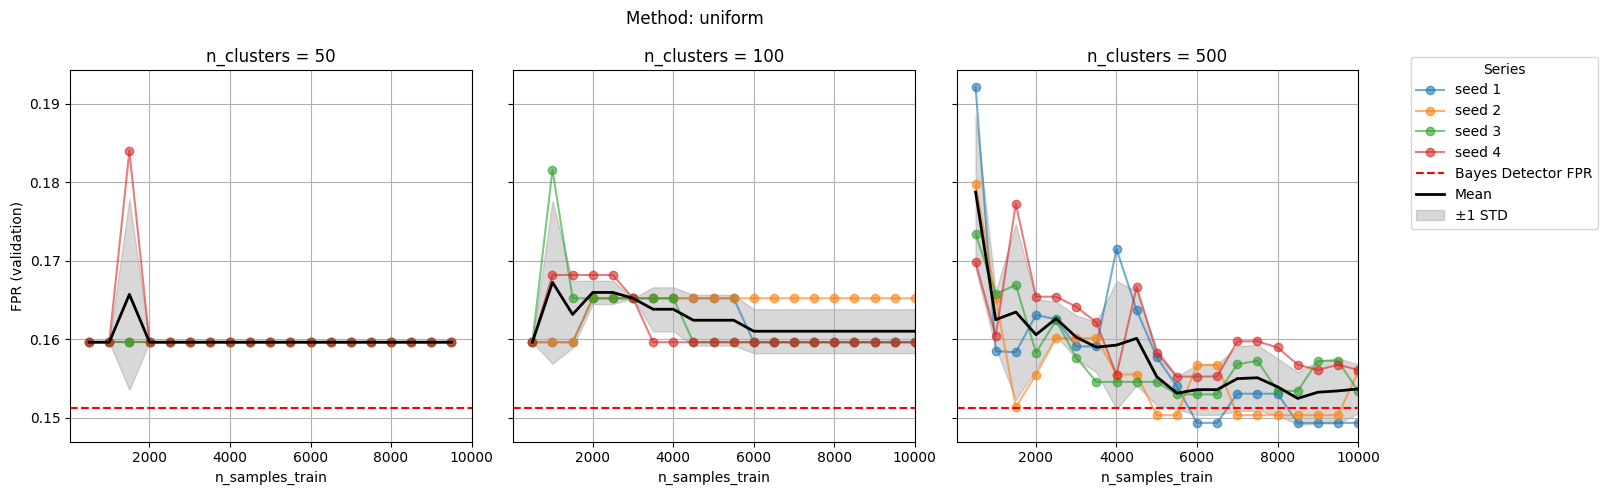

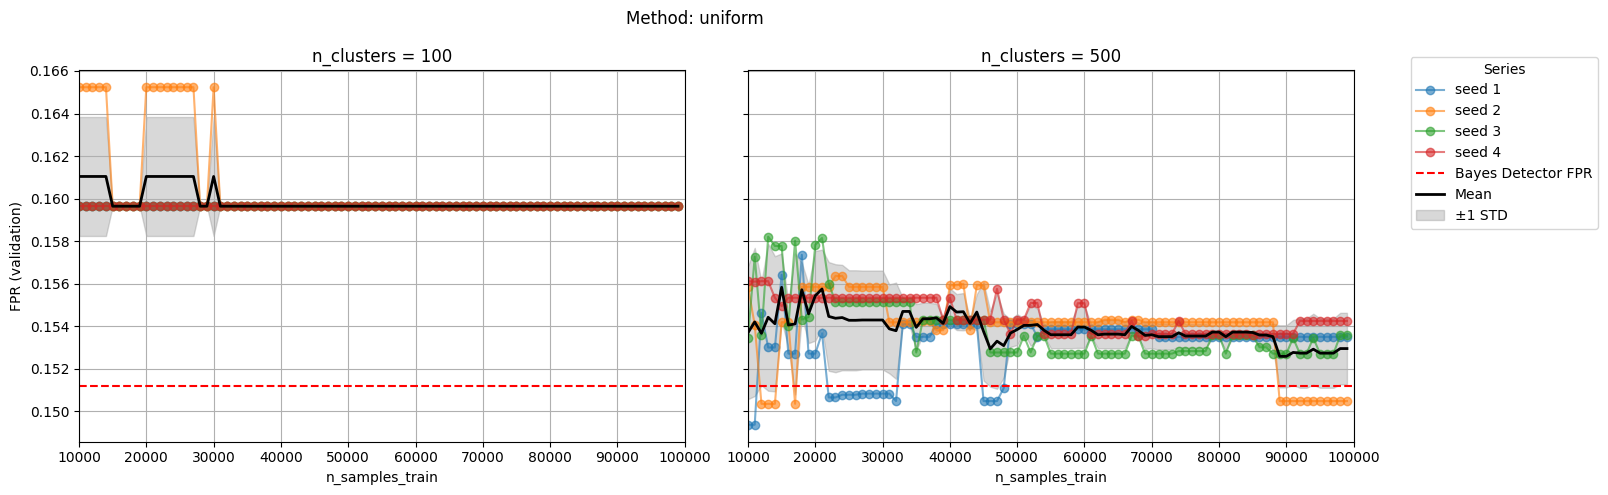

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ---- PARAMETERS ----
cluster_values      = [50, 100, 500]    # the two n_clusters values you care about
n_samples_train_inf = 30
n_samples_train_sup = 10000
seed_test           = -1
 

plot_fpr(df, cluster_values=cluster_values, seed_test=seed_test, n_samples_train_inf = n_samples_train_inf, n_samples_train_sup = 10000)
plot_fpr(df, seed_test=seed_test, cluster_values = [100, 500], n_samples_train_inf = 10000, n_samples_train_sup = 100000)


**Uniform partionning vs Kmeans**

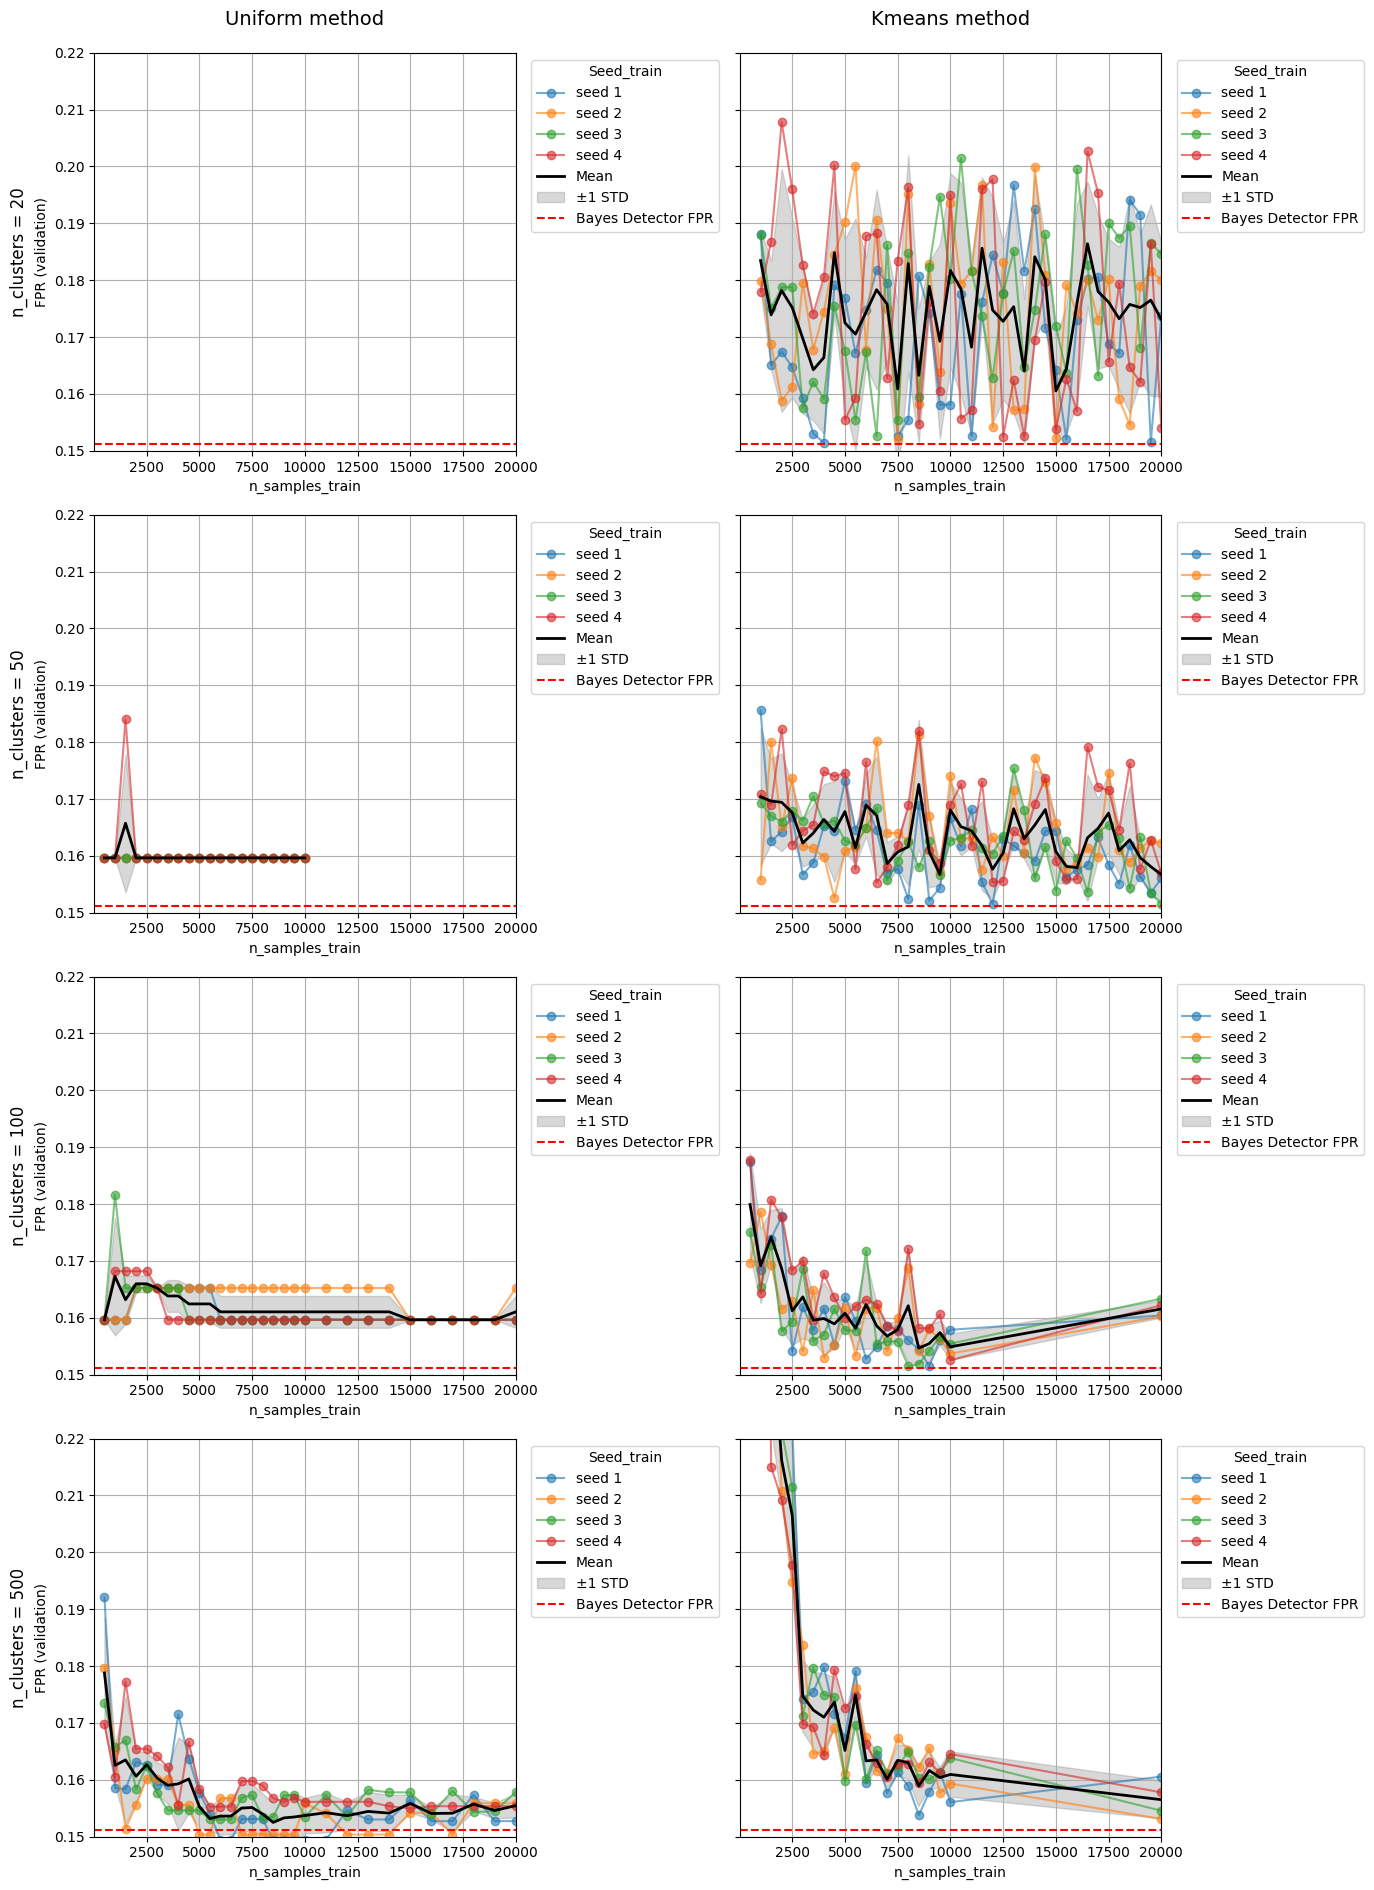

In [60]:

n_samples_train_inf = 20
n_samples_train_sup = 20000
ylim = (0.15, 0.22)
seed_test = -1
plot_fpr_method_comparison(df, cluster_values=[20, 50, 100, 500], seed_test=seed_test,
          n_samples_train_inf = n_samples_train_inf, n_samples_train_sup = n_samples_train_sup,
          ylim=ylim)

**Kmeans works with n_cluster = 10 !!**

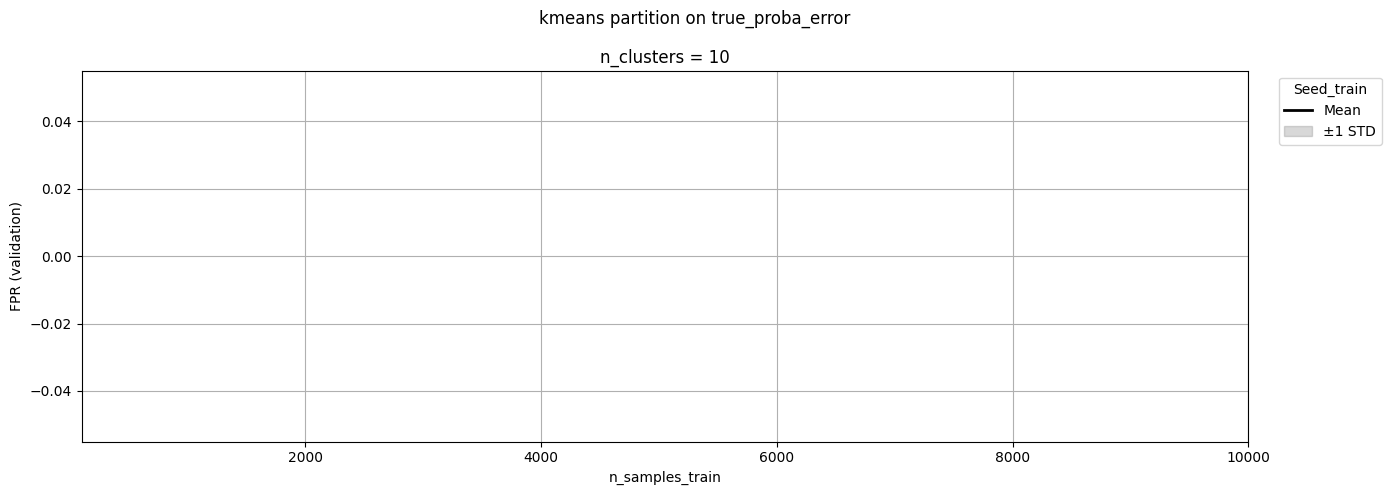

In [7]:
plot_fpr_2(
    df,
    method="kmeans",
    partionning_space="true_proba_error",
    cluster_values = [10],
    n_samples_train_inf=100,
    n_samples_train_sup=10000,
    seed_test=-1)

**Soft-Kmeans**

**Init scheme = "kmeans"**

**init_scheme="kmeans++"**

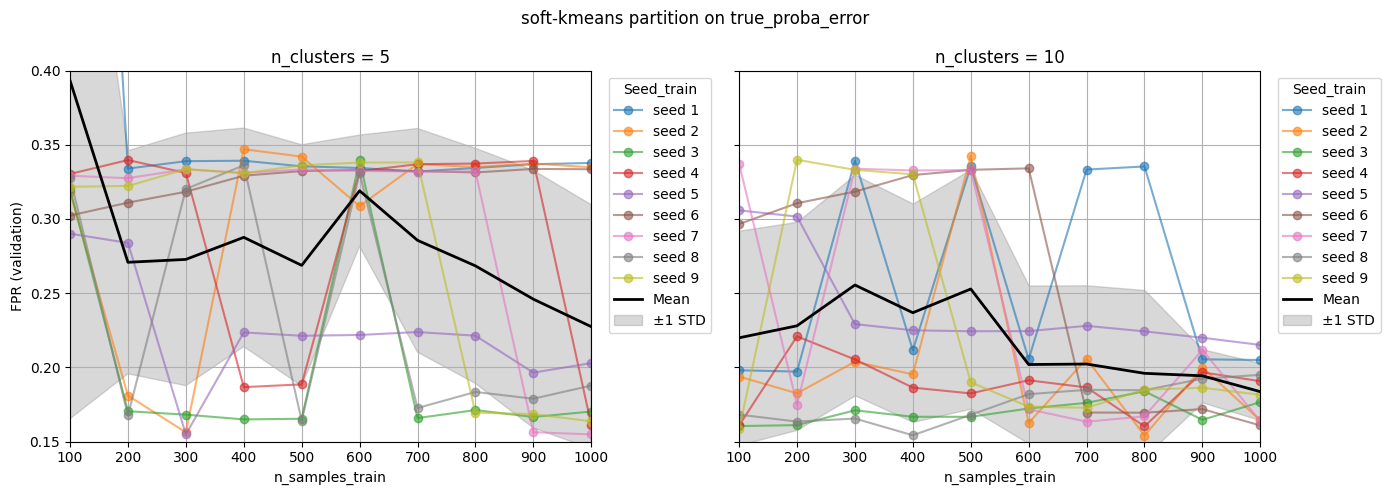

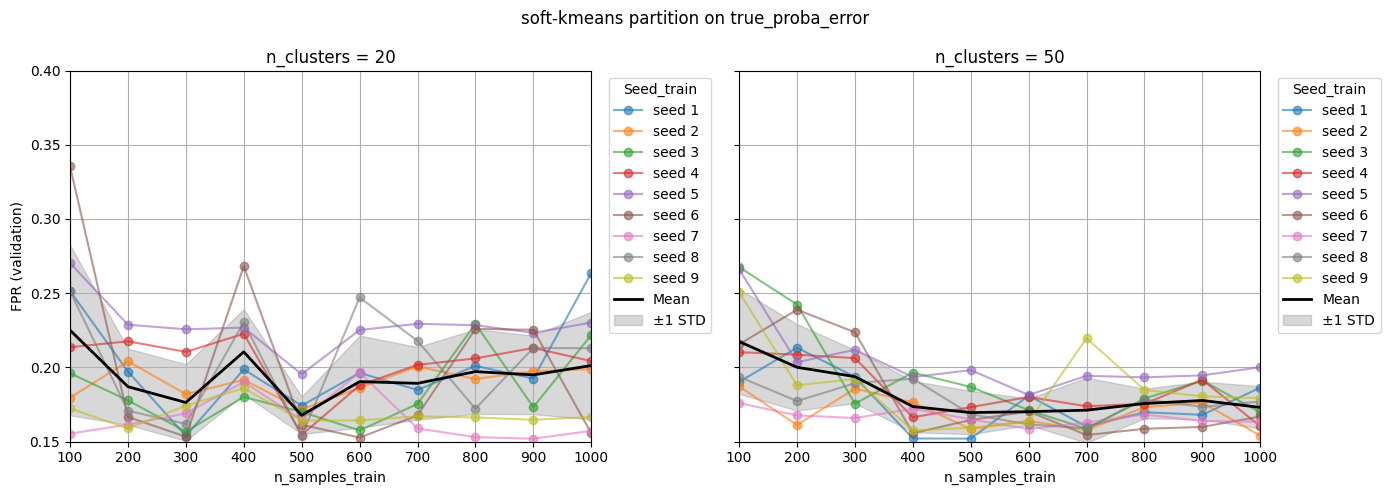

In [216]:
ylim = (0.15, 0.4)
init_scheme="kmeans++"
n_samples_train_inf = 100
n_samples_train_sup = 1000
plot_fpr_2(
    df,
    method="soft-kmeans",
    partionning_space="true_proba_error",
    cluster_values = [5, 10],
    n_samples_train_inf=n_samples_train_inf,
    n_samples_train_sup=n_samples_train_sup,
    seed_test=-1,
    init_scheme=init_scheme,
    ylim=ylim)

plot_fpr_2(
    df,
    method="soft-kmeans",
    partionning_space="true_proba_error",
    cluster_values = [20, 50],
    n_samples_train_inf=n_samples_train_inf,
    n_samples_train_sup=n_samples_train_sup,
    init_scheme=init_scheme,
    seed_test=-1,
    ylim=ylim)

**Comparison kmeans and soft-kmeans**

kmeans 5 [8 3 1 5 2 7 6 4 9]
soft-kmeans 5 [8 2 4 7 9 1 6 5 3]
kmeans 10 [7 8 5 4 6 9 3 1 2]
soft-kmeans 10 [2 5 4 8 9 7 3 1 6]
kmeans 20 [4 1 3 6 2 7 8 5 9]
soft-kmeans 20 [2 9 6 5 7 8 3 4 1]
kmeans 50 [2 8 3 7 1 9 5 4 6]
soft-kmeans 50 [3 1 9 8 7 5 6 2 4]


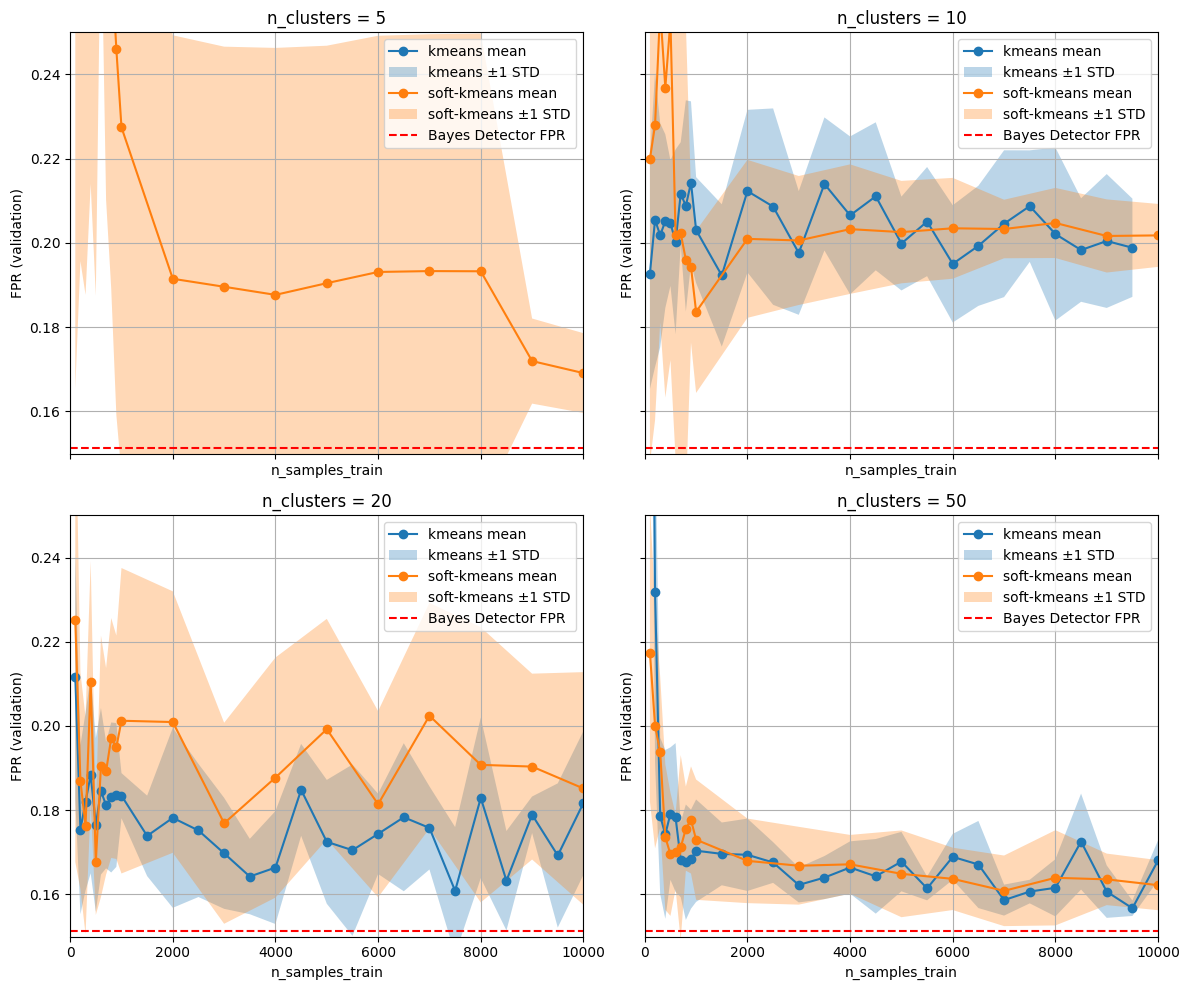

In [194]:
# ---- PARAMETERS ----
cluster_values = [5, 10, 20, 50]
seed_test = -1
ylim = (0.15, 0.25)
init_scheme = {"kmeans" : "k-means++", "soft-kmeans" : "kmeans++"}
n_samples_train_inf = 0
n_samples_train_sup = 10000
clustering_seed = {"kmeans" : 0, "soft-kmeans" : 0}
clustering_space = "true_proba_error"
methods=["kmeans", "soft-kmeans"]


plot_fpr_method_comparison_2(
    df=df,
    cluster_values=cluster_values,
    seed_test=seed_test,
    n_samples_train_inf=n_samples_train_inf,
    n_samples_train_sup=n_samples_train_sup,
    clustering_seed = clustering_seed,
    clustering_space=clustering_space,
    methods=methods,
    init_scheme = init_scheme,
    ylim=ylim  # e.g. (0.0, 0.1)
)


**Clustering space : Probits**

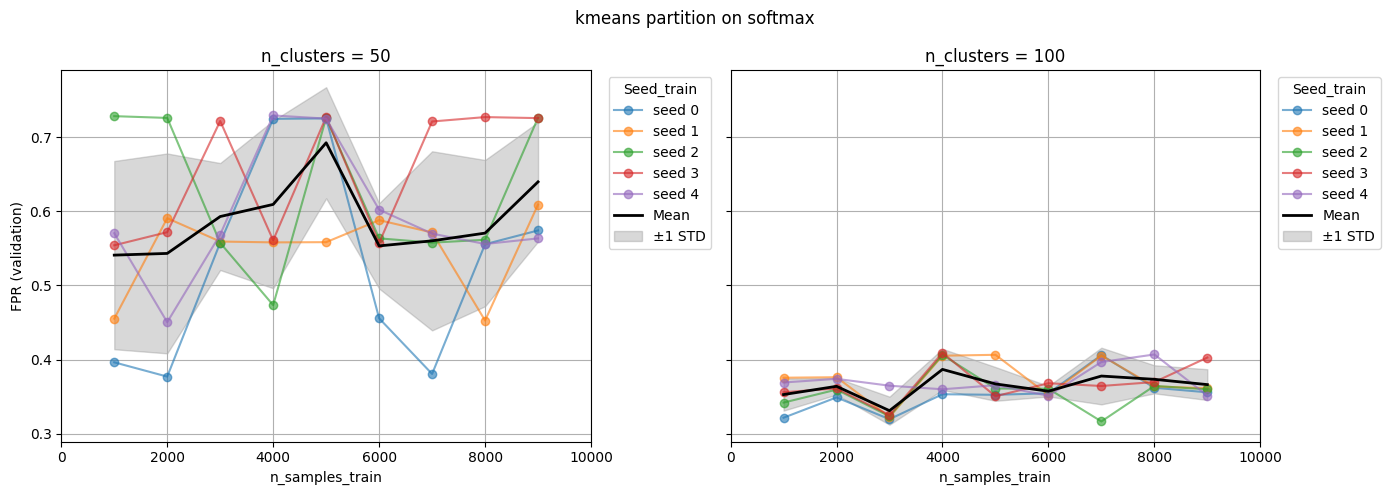

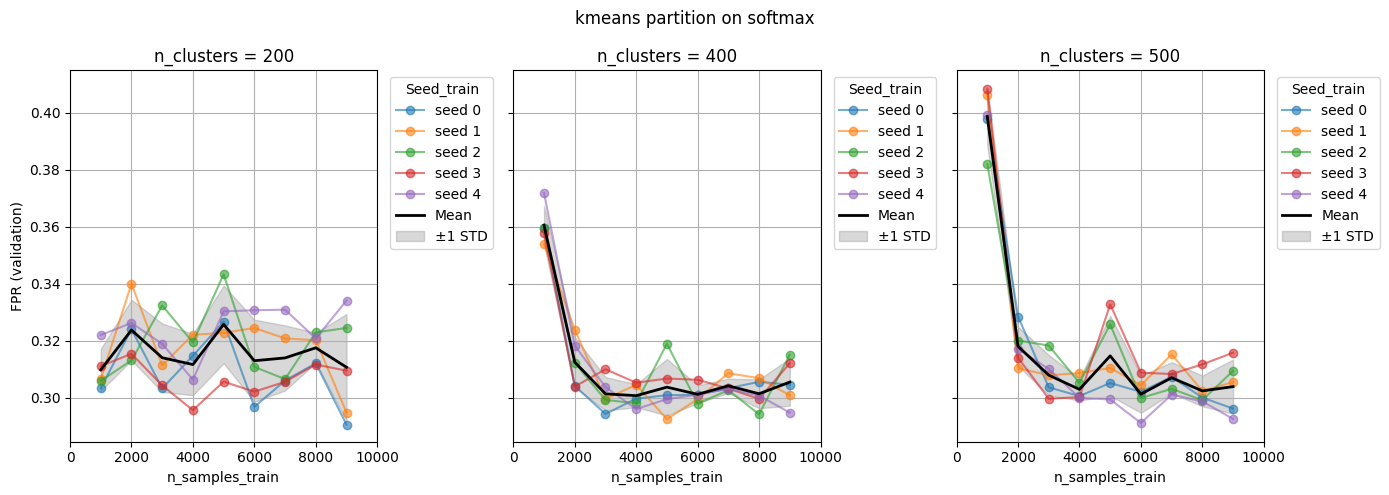

In [78]:
ylim = (0.15, 0.4)
init_scheme="k-means++"
n_samples_train_inf = 0
n_samples_train_sup = 10000

plot_fpr_2(
    df,
    method="kmeans",
    partionning_space="softmax",
    cluster_values = [50, 100],
    n_samples_train_inf=n_samples_train_inf,
    n_samples_train_sup=n_samples_train_sup,
    init_scheme=init_scheme,
    seed_test=-1,
    ylim=None)

plot_fpr_2(
    df,
    method="kmeans",
    partionning_space="softmax",
    cluster_values = [200, 400, 500],
    n_samples_train_inf=n_samples_train_inf,
    n_samples_train_sup=n_samples_train_sup,
    init_scheme=init_scheme,
    seed_test=-1,
    ylim=None)

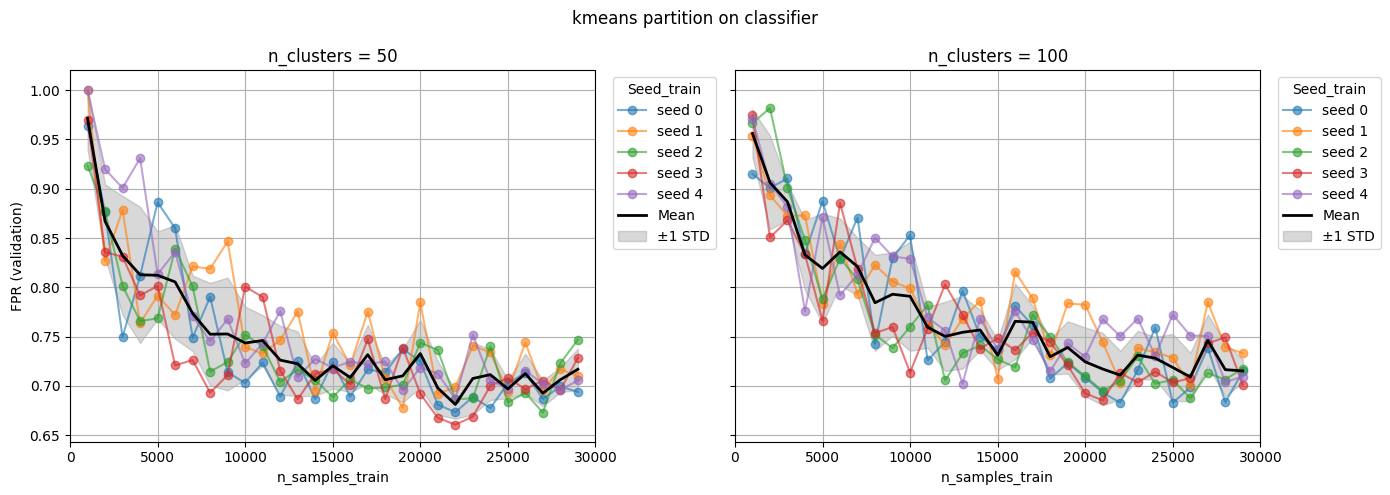

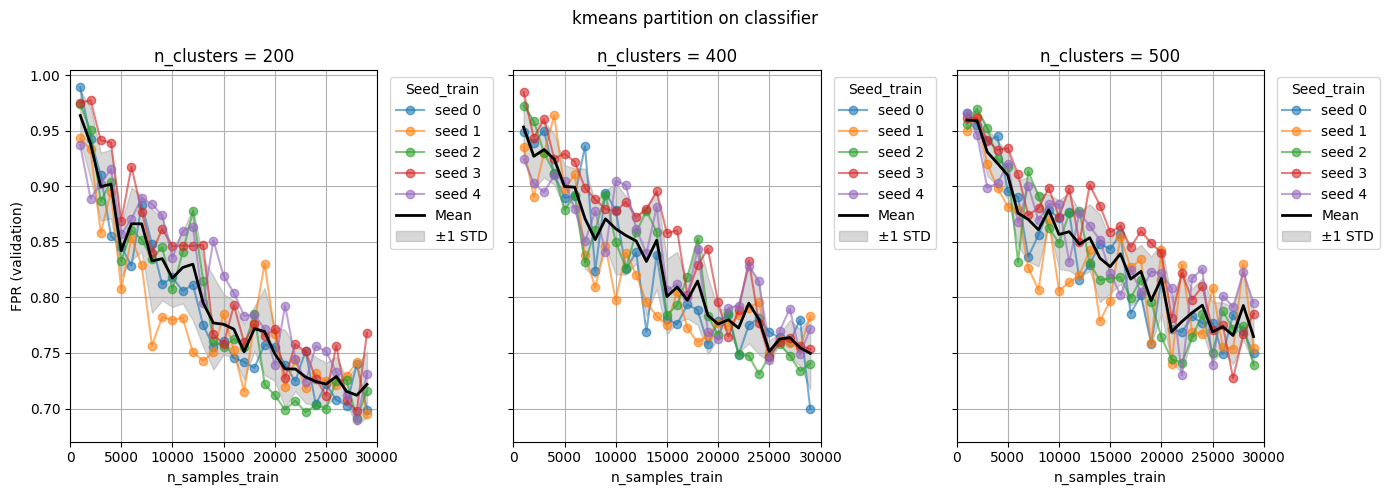

In [13]:
ylim = (0.15, 0.4)
method = "kmeans"
init_scheme="k-means++"
n_samples_train_inf = 0
n_samples_train_sup = 30000
clustering_space = "classifier"

plot_fpr_2(
    df,
    method=method,
    partionning_space=clustering_space,
    cluster_values = [50, 100],
    n_samples_train_inf=n_samples_train_inf,
    n_samples_train_sup=n_samples_train_sup,
    init_scheme=init_scheme,
    seed_test=-1,
    ylim=None)

plot_fpr_2(
    df,
    method=method,
    partionning_space=clustering_space,
    cluster_values = [200, 400, 500],
    n_samples_train_inf=n_samples_train_inf,
    n_samples_train_sup=n_samples_train_sup,
    init_scheme=init_scheme,
    seed_test=-1,
    ylim=None)

**Is Inertia of Kmeans Correlated to FPR ?**

      data_n_samples_train  data_n_samples_test  data_batch_size_train  \
435                  10000              1000000                 100000   
518                  10000              1000000                 100000   
715                  10000              1000000                 100000   
739                  10000              1000000                 100000   
1267                 10000              1000000                 100000   
1281                 10000              1000000                 100000   
1385                 10000              1000000                 100000   
1538                 10000              1000000                 100000   
1704                 10000              1000000                 100000   
1728                 10000              1000000                 100000   
1917                 10000              1000000                 100000   
1967                 10000              1000000                 100000   
2000                 10000            

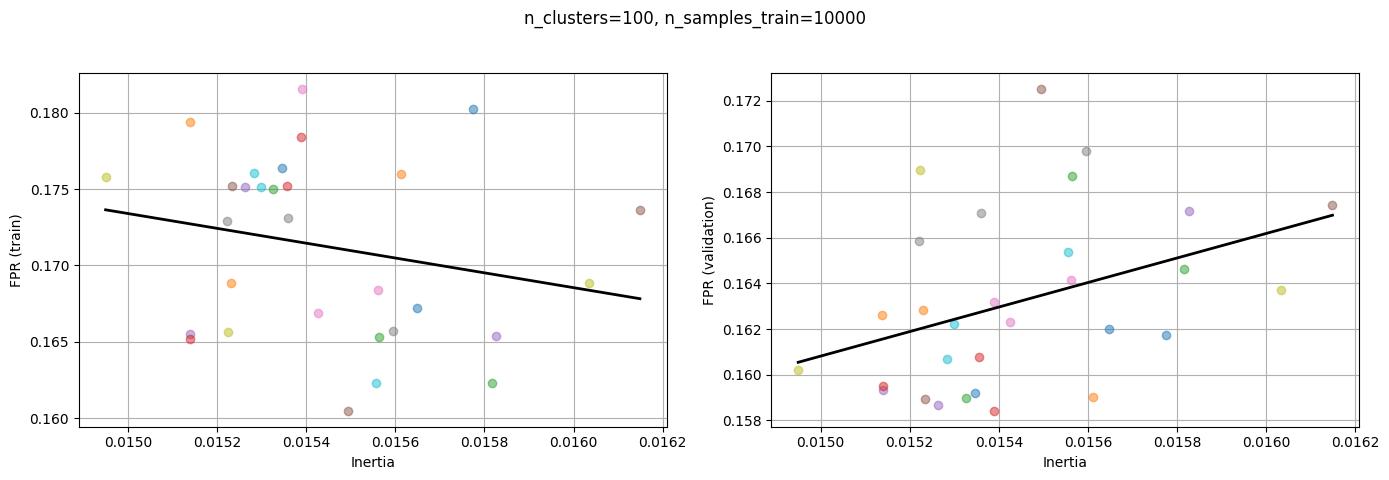

In [38]:
plot_inertia(
    df,
    partionning_space="true_proba_error",
    n_samples_train=10000,
    n_samples_test = 1000000,
    cluster_value=100,
    seed_test=-2,
)

**How Kmeans build its partition ?**

In [172]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

def plot_experiment_histograms_(df, n_samples_train, n_samples_test, n_clusters, method,
                                seed_train, seed_test, partionning_space, init_scheme,
                                score_col='embs',
                                label_col='detector_labels',
                                labels=('No error', 'Error'),
                                bins=60):
    """
    Plots normalized-frequency histograms of `score_col` for label=False vs label=True
    for each experiment DataFrame in `experiment_dfs`, arranged in 2 columns.
    Each subplot is titled with its kmeans_seed.
    """
    # filter the master df
    df_c = df[(df["data_n_samples_train"] == n_samples_train) &
              (df["data_n_samples_test"] == n_samples_test) &
              (df["clustering_n_clusters"] == n_clusters) &
              (df["clustering_name"] == method) &
              (df["data_seed_train"] == seed_train) &
              (df["data_seed_test"] == seed_test) &
              (df["clustering_space"].eq(partionning_space) 
               | df["clustering_space"].isna()) &
                (df["clustering_init_scheme"] == init_scheme) 
               ]

    experiment_nbs = df_c["experiment_folder"].to_list()
    kmeans_seeds = df_c["clustering_seed"].to_list()
    # print(df_c)
    n = len(experiment_nbs)

    if n == 0:
        print("No experiments matched the given parameters.")
        return

    # compute grid size: 2 columns, rows = ceil(n/2)
    n_cols = 2
    n_rows = math.ceil(n / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharey=True)
    axes = axes.flatten()

    for idx, (ax, exp_nb, seed_k) in enumerate(zip(axes, experiment_nbs, kmeans_seeds)):
        from joblib import dump, load



        # load cluster centers and training predictions
        if method == "kmeans":
            centers = pd.read_csv(
                os.path.join(RESULTS_DIR, exp_nb, "cluster_centers.csv")
            )
            centers = centers["centers"].values
            boundaries = (centers[:-1] + centers[1:]) / 2.0
            
        elif method == "soft-kmeans":
            print("jj", os.path.join(RESULTS_DIR, exp_nb, "clustering_algo.pkl"))
            clustering_algo = joblib.load(os.path.join(RESULTS_DIR, exp_nb, "clustering_algo.pkl"))
            xs = np.linspace(0, 1, 100)
            clusters = clustering_algo.predict(xs.reshape(-1, 1))
            plt.plot(xs, clusters)
            changes = np.where(clusters[:-1] != clusters[1:])[0]
            # mid-points between samples
            boundaries = (xs[changes] + xs[changes+1]) / 2
        

        exp_train_predictions = pd.read_csv(
            os.path.join(RESULTS_DIR, exp_nb, "detector_train_predictions.csv")
        )

        # define common bins
        all_scores = exp_train_predictions[score_col]
        bin_edges = np.linspace(all_scores.min(), all_scores.max(), bins)

        # split scores by true label
        scores_0 = exp_train_predictions.loc[~exp_train_predictions[label_col], score_col]
        scores_1 = exp_train_predictions.loc[exp_train_predictions[label_col], score_col]

        # plot histograms
        ax.hist(scores_0, bins=bin_edges, density=True, alpha=0.5, label=labels[0])
        ax.hist(scores_1, bins=bin_edges, density=True, alpha=0.5, label=labels[1])

        # add cluster boundaries
        boundaries = np.concatenate(([0.0], boundaries, [1.0]))
        for b in boundaries:
            ax.axvline(b, color='k', linestyle='--', linewidth=1.2)

        # title with kmeans_seed
        fpr_val = df_c[df_c["experiment_folder"] == exp_nb]["fpr_val"].item()
        ax.set_title(f'kmeans_seed = {seed_k} - FPR = {fpr_val:.3f}')
        ax.set_xlabel('Detection Score')
        if idx % n_cols == 0:
            ax.set_ylabel('Normalized Frequency')
        ax.legend(title='True Label')
        ax.grid(True)

    # turn off unused subplots
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])
    fig.suptitle(f'n_clusters={n_clusters}, n_samples_train={n_samples_train}')
    plt.tight_layout()
    plt.show()




In [231]:
df

data_n_samples_train  data_n_samples_test  data_batch_size_train  \
0                      500               100000                 100000   
1                    77000               100000                 100000   
2                      200               100000                 100000   
3                    84000               100000                 100000   
4                    14000               100000                 100000   
...                    ...                  ...                    ...   
7252                  5000               100000                 100000   
7253                370000               100000                 100000   
7254                 73000               100000                 100000   
7255                 20000               100000                 100000   
7256                  1501               100000                 100000   

      data_batch_size_test  data_seed_train  data_seed_test clustering_name  \
0                   100000                2              -1     soft-kmeans   
1                   100000                3              -1         uniform   
2                   100000                8              -1          kmeans   
3                   100000                1              -1          kmeans   
4                   100000                2              -1     soft-kmeans   
...                    ...              ...             ...             ...   
7252                100000                7              -1     soft-kmeans   
7253                100000                1              -1          kmeans   
7254                100000                2              -1          kmeans   
7255                100000                8              -1     soft-kmeans   
7256                100000                2              -1         uniform   

      clustering_n_clusters  clustering_seed clustering_init_scheme  ...  \
0                      20.0              0.0               kmeans++  ...   
1                     500.0              NaN                   None  ...   
2                       5.0              0.0              k-means++  ...   
3                      50.0              0.0              k-means++  ...   
4                       5.0              0.0                 kmeans  ...   
...                     ...              ...                    ...  ...   
7252                   20.0              0.0               kmeans++  ...   
7253                  100.0              0.0              k-means++  ...   
7254                   20.0              0.0              k-means++  ...   
7255                    5.0              0.0               kmeans++  ...   
7256                  500.0              NaN                   None  ...   

     experiment_folder fpr_train tpr_train thr_train   fpr_val   tpr_val  \
0      experiment_5350  0.134904  0.969697  0.403681  0.171576  0.960977   
1      experiment_1038  0.166798  0.951185  0.121231  0.152835  0.950825   
2      experiment_7040  0.176471  1.000000  0.417327  1.000000  1.000000   
3      experiment_4121  0.165898  0.950631  0.079339  0.163027  0.957170   
4      experiment_5170  0.182368  0.957128  0.115351  0.177500  0.963357   
...                ...       ...       ...       ...       ...       ...   
7252   experiment_5436  0.208262  0.980263  0.098305  0.203883  0.971447   
7253   experiment_1424  0.159076  0.950181  0.066204  0.157456  0.953363   
7254   experiment_3242  0.191438  0.964301  0.056234  0.189603  0.967481   
7255   experiment_6599  0.180432  0.963855  0.103055  0.175845  0.962405   
7256    experiment_261  0.115057  0.956989  0.721109  0.151383  0.950190   

       thr_val   inertia  clustering_temperature  clustering_normalize_gini  
0     0.375663  3.237296                     NaN                        NaN  
1     0.127240       NaN                     NaN                       None  
2     0.109439  0.234231                     NaN                        NaN  
3     0.079339  0.598178      

In [ ]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

def plot_experiment_histograms_(
    df,
    n_samples_train,
    n_samples_test,
    n_clusters,
    seed_train,
    seed_test,
    partionning_space,
    init_scheme,
    methods=("kmeans", "soft-kmeans"),
    clustering_seed={"kmeans": 0, "soft-kmeans": 0},
    score_col='embs',
    label_col='detector_labels',
    labels=('No error', 'Error'),
    bins=60
):
    """
    Plots side-by-side normalized-frequency histograms of `score_col` for two clustering methods.

    Each subplot shows label=False vs label=True under the two methods.

    Main title indicates n_clusters, n_samples_train, and train_seed.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns ['data_n_samples_train','data_n_samples_test','clustering_n_clusters',
        'clustering_name','data_seed_train','data_seed_test','clustering_space',
        'clustering_init_scheme','clustering_seed','experiment_folder','fpr_val']
    n_samples_train : int
    n_samples_test  : int
    n_clusters      : int
    seed_train      : int
    seed_test       : int
    partionning_space : str
    init_scheme     : dict
        Mapping method -> init scheme string
    methods : tuple of str
        Two methods to compare
    clustering_seed : dict
        Mapping method -> clustering seed
    score_col : str
    label_col : str
    labels    : tuple of str
    bins      : int
    """
    # Prepare figure
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True)

    for ax, method in zip(axes, methods):
        # Filter for this method
        df_c = df[
            (df['data_n_samples_train'] == n_samples_train) &
            (df['data_n_samples_test'] == n_samples_test) &
            (df['clustering_n_clusters'] == n_clusters) &
            (df['clustering_name'] == method) &
            (df['data_seed_train'] == seed_train) &
            (df['data_seed_test'] == seed_test) &
            ((df['clustering_space'] == partionning_space) | df['clustering_space'].isna()) &
            (df['clustering_init_scheme'] == init_scheme[method]) &
            (df['clustering_seed'] == clustering_seed[method])
        ]

        if df_c.empty:
            ax.text(0.5, 0.5, f"No data for {method}", ha='center')
            continue

        exp_nb = df_c['experiment_folder'].iloc[0]
        fpr_val = df_c['fpr_val'].iloc[0]
        threshold = df_c['thr_val'].iloc[0]

        # Load cluster boundaries
        if method == 'kmeans':
            centers = pd.read_csv(os.path.join(RESULTS_DIR, exp_nb, 'cluster_centers.csv'))['centers'].values
            boundaries = (centers[:-1] + centers[1:]) / 2.0
        else:  # soft-kmeans
            clustering_algo = joblib.load(os.path.join(RESULTS_DIR, exp_nb, 'clustering_algo.pkl'))
            xs = np.linspace(0, 1, 100)
            clusters = clustering_algo.predict(xs.reshape(-1, 1))
            changes = np.where(clusters[:-1] != clusters[1:])[0]
            boundaries = (xs[changes] + xs[changes + 1]) / 2.0

        # Load predictions
        preds = pd.read_csv(os.path.join(RESULTS_DIR, exp_nb, 'detector_train_predictions.csv'))
        all_scores = preds[score_col]
        bin_edges = np.linspace(all_scores.min(), all_scores.max(), bins)
        scores_0 = preds.loc[~preds[label_col], score_col]
        scores_1 = preds.loc[preds[label_col], score_col]

        # Plot histograms
        ax.hist(scores_0, bins=bin_edges, density=True, alpha=0.5, label=labels[0])
        ax.hist(scores_1, bins=bin_edges, density=True, alpha=0.5, label=labels[1])

        # Draw boundaries
        boundaries_full = np.concatenate(([0.0], boundaries, [1.0]))
        print(boundaries_full)
        for b in boundaries_full:
            ax.axvline(b, color='k', linestyle='--', linewidth=1.2)

        ax.axvline(threshold, color='orange', linestyle='--', linewidth=1.2, label='Threshold Val')
        # Decorations
        ax.set_title(f"{method} - FPR val = {fpr_val:.3f}")
        ax.set_xlabel('Detection Score')
        ax.set_ylabel('Normalized Frequency')
        ax.legend(title='True Label')
        ax.grid(True)

    # Main title
    fig.suptitle(f"n_clusters={n_clusters}, n_samples_train={n_samples_train}, train_seed={seed_train}")
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.legend()
    plt.show()


In [59]:
cluster_centers = pd.read_csv(os.path.join(RESULTS_DIR, "experiment_7087", 'cluster_centers.csv'))
cluster_centers

cluster   centers
0        0  0.007097
1        3  0.188592
2        2  0.442147
3        4  0.752835
4        1  0.974850

In [66]:
train_preds = pd.read_csv(os.path.join(RESULTS_DIR, "experiment_7087", 'detector_val_predictions.csv'))
val_preds = pd.read_csv(os.path.join(RESULTS_DIR, "experiment_7087", 'detector_val_predictions.csv'))
arg_sort = [0, 3, 2, 4, 1]
cluster_counts = val_preds["clusters"].value_counts(dropna=False).values[arg_sort]
print("count per cluster", cluster_counts)
train_preds["clusters"].value_counts(dropna=False)

print("n_sample", val_preds.shape[0])

n_negatif_total = (val_preds["detector_labels"] == False).sum()
n_positif_total = (val_preds["detector_labels"] == True).sum()
print("n_negatif_total", n_negatif_total)
print("n_positif_total", n_positif_total)
negatifs_per_cluster = np.array([val_preds[
    (val_preds["detector_labels"] == False) & (val_preds["clusters"] == i)].shape[0] for i in range(5)])[arg_sort]

print(negatifs_per_cluster)


[np.sum(negatifs_per_cluster[i:]) for i in range(5)] / n_negatif_total

count per cluster [85277  1512  3951  1326  7934]
n_sample 100000
n_negatif_total 93696
n_positif_total 6304
[84597  6414  2283   372    30]


array([1.00000000e+00, 9.71119365e-02, 2.86565061e-02, 4.29047131e-03,
       3.20184426e-04])

In [40]:
cluster_counts[0]

85277

In [42]:
85277 /93696

0.9101455771857924

In [41]:
n_negatif_total

93696

In [39]:
cluster_counts[:1] /n_negatif_total

array([0.91014558])

In [8]:
df[(df["clustering_n_clusters"] == 5) & (df["clustering_name"] == "kmeans")]["clustering_name"].value_counts(dropna=False)

cluster_values = [5]
seed_test = -1
init_scheme = {"kmeans" : "k-means++", "soft-kmeans" : "kmeans++"}
n_samples_train_inf = 800
n_samples_train_sup = 800
clustering_seed = {"kmeans" : 0, "soft-kmeans" : 0}
clustering_space = "true_proba_error"
methods=["kmeans", "kmeans"]

method = "kmeans"
df_c = df[
    (df['clustering_n_clusters'] == cluster_values[0]) &
    (df['data_n_samples_train'] >= n_samples_train_inf) &
    (df['data_n_samples_train'] <= n_samples_train_sup) &
    # df['fpr_val'].notnull() &
    (df['data_seed_test'] == seed_test) &
    (df['clustering_name'] == method) &
#    ( df["clustering_space"].eq(partionning_space) 
#     | df["clustering_space"].isna()) &
    (df['clustering_init_scheme'] == init_scheme[method]) &
    (df['clustering_seed'] == clustering_seed[method])
    ]
df_c

data_n_samples_train  data_n_samples_test  data_batch_size_train  \
2231                   800               100000                 100000   
2927                   800               100000                 100000   
4582                   800               100000                 100000   
4615                   800               100000                 100000   
4722                   800               100000                 100000   
4805                   800               100000                 100000   
5576                   800               100000                 100000   
5658                   800               100000                 100000   
6344                   800               100000                 100000   

      data_batch_size_test  data_seed_train  data_seed_test clustering_name  \
2231                100000                3              -1          kmeans   
2927                100000                4              -1          kmeans   
4582                100000                1              -1          kmeans   
4615                100000                6              -1          kmeans   
4722                100000                7              -1          kmeans   
4805                100000                9              -1          kmeans   
5576                100000                8              -1          kmeans   
5658                100000                5              -1          kmeans   
6344                100000                2              -1          kmeans   

      clustering_n_clusters  clustering_seed clustering_init_scheme  ...  \
2231                    5.0              0.0              k-means++  ...   
2927                    5.0              0.0              k-means++  ...   
4582                    5.0              0.0              k-means++  ...   
4615                    5.0              0.0              k-means++  ...   
4722                    5.0              0.0              k-means++  ...   
4805                    5.0              0.0              k-means++  ...   
5576                    5.0              0.0              k-means++  ...   
5658                    5.0              0.0              k-means++  ...   
6344                    5.0              0.0              k-means++  ...   

     experiment_folder fpr_train tpr_train thr_train  fpr_val  tpr_val  \
2231   experiment_7089  0.114058  0.956522  0.313962      1.0      1.0   
2927   experiment_7090  1.000000  1.000000  0.061214      1.0      1.0   
4582   experiment_7087  1.000000  1.000000  0.062215      1.0      1.0   
4615   experiment_7092  1.000000  1.000000  0.060856      1.0      1.0   
4722   experiment_7093  1.000000  1.000000  0.057223      1.0      1.0   
4805   experiment_7095  1.000000  1.000000  0.058152      1.0      1.0   
5576   experiment_7094  0.134667  0.980000  0.293931      1.0      1.0   
5658   experiment_7091  1.000000  1.000000  0.058322      1.0      1.0   
6344   experiment_7088  0.120850  0.957447  0.278505      1.0      1.0   

       thr_val   inertia  clustering_temperature  clustering_normalize_gini  
2231  0.055453  0.632288                     NaN                        NaN  
2927  0.061214  0.599470                     NaN                        NaN  
4582  0.062215  0.649570                     NaN                        NaN  
4615  0.060856  0.591226                     NaN                        NaN  
4722  0.057223  0.573588                     NaN                        NaN  
4805  0.058152  0.633338                     NaN                        NaN  
5576  0.054808  0.670095                     NaN                        NaN  
5658  0.058322  0.689392                     NaN                        NaN  
6344  0.055717  0.601556                     NaN                        NaN  

[9 rows x 23 columns]

jj ../../synth_results/asymp_exp/experiment_6835/clustering_algo.pkl


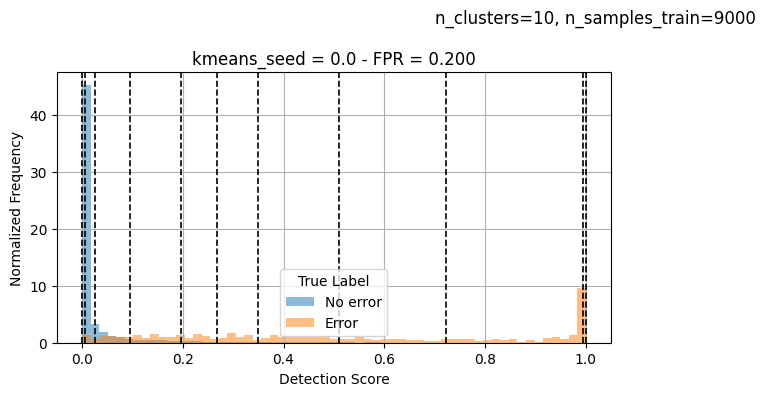

In [ ]:
partionning_space= "true_proba_error"
n_samples_train=900
n_samples_test=100000
n_clusters=10

seed_train=1
seed_test=-1
init_scheme = "kmeans++"

clustering_space = "true_proba_error"
method= "soft-kmeans"


plot_experiment_histograms_(
    df,
    n_samples_train=n_samples_train,
    n_samples_test=n_samples_test,
    n_clusters=n_clusters,
    method=method,
    seed_train=seed_train,
    seed_test=seed_test,
    partionning_space= partionning_space,
    init_scheme=init_scheme
)


**n_cluster = 5 :  Why kmeans does not work ?**

[0.         0.09784445 0.3153696  0.59749082 0.86384215 1.        ]
[0.         0.00505051 0.06565657 0.6010101  0.95454545 1.        ]


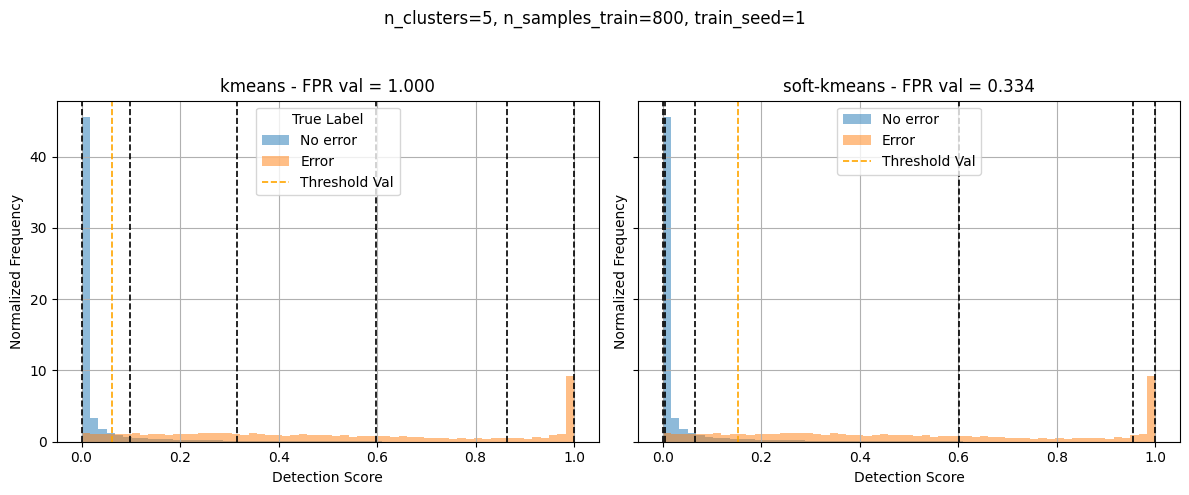

In [7]:
partionning_space= "true_proba_error"
n_samples_train=800
n_samples_test=100000
n_clusters=5

seed_train=1
seed_test=-1
init_scheme = {"kmeans" : "k-means++", "soft-kmeans" : "kmeans++"}

clustering_seed = {"kmeans" : 0, "soft-kmeans" : 0}
clustering_space = "true_proba_error"
method=["kmeans", "soft-kmeans"]


plot_experiment_histograms_(
    df,
    n_samples_train=n_samples_train,
    n_samples_test=n_samples_test,
    n_clusters=n_clusters,
    methods=method,
    seed_train=seed_train,
    seed_test=seed_test,
    partionning_space= partionning_space,
    init_scheme=init_scheme,
    clustering_seed=clustering_seed
)



**n_cluster = 10**

[0.         0.02536137 0.09054836 0.17584329 0.25562039 0.33775988
 0.44671381 0.6091493  0.7829007  0.92141038 1.        ]
[0.         0.00505051 0.05555556 0.20707071 0.26767677 0.35858586
 0.41919192 0.68181818 0.71212121 0.72222222 0.96464646 1.        ]


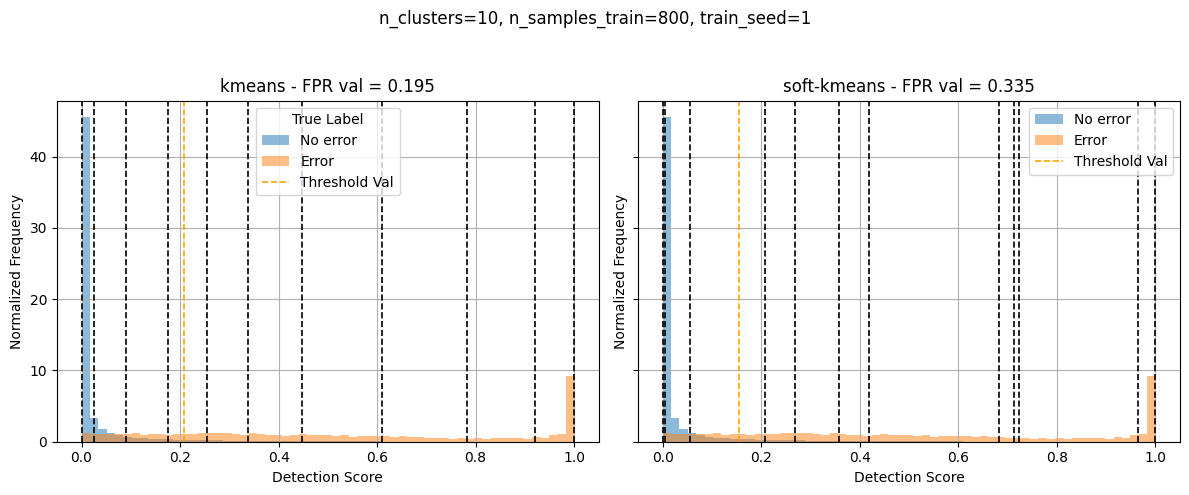

[0.         0.01460881 0.04975783 0.09974984 0.16342872 0.26815835
 0.40230479 0.56075721 0.74108471 0.89832073 1.        ]
[0.         0.00505051 0.02525253 0.10606061 0.14646465 0.21717172
 0.38888889 0.6010101  0.77272727 0.88383838 1.        ]


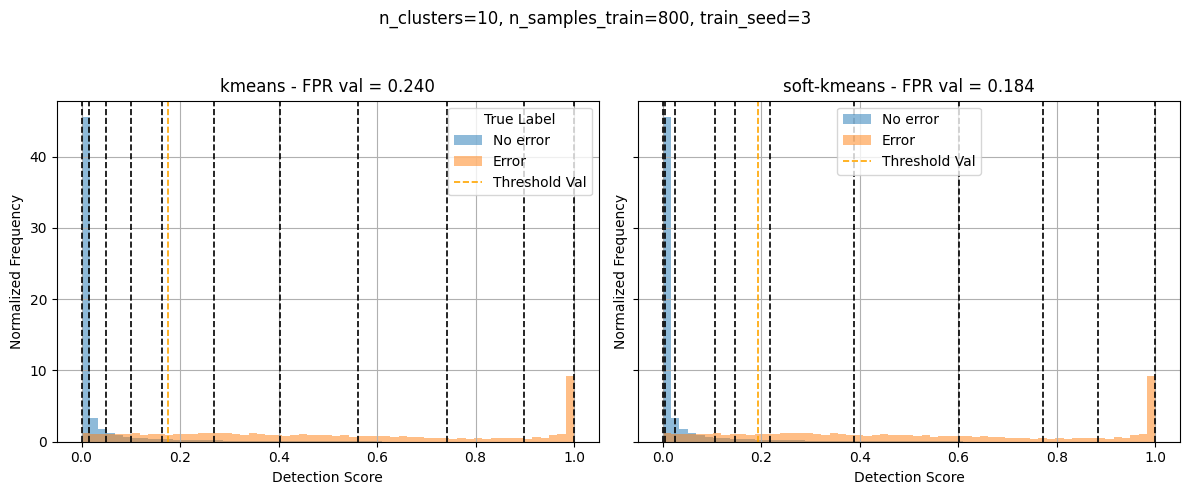

In [238]:
partionning_space= "true_proba_error"
n_samples_train=800
n_samples_test=100000
n_clusters=10

seed_train=1
seed_test=-1
init_scheme = {"kmeans" : "k-means++", "soft-kmeans" : "kmeans++"}

clustering_seed = {"kmeans" : 0, "soft-kmeans" : 0}
clustering_space = "true_proba_error"
method=["kmeans", "soft-kmeans"]


plot_experiment_histograms_(
    df,
    n_samples_train=n_samples_train,
    n_samples_test=n_samples_test,
    n_clusters=n_clusters,
    methods=method,
    seed_train=seed_train,
    seed_test=seed_test,
    partionning_space= partionning_space,
    init_scheme=init_scheme,
    clustering_seed=clustering_seed
)

plot_experiment_histograms_(
    df,
    n_samples_train=n_samples_train,
    n_samples_test=n_samples_test,
    n_clusters=n_clusters,
    methods=method,
    seed_train=3,
    seed_test=seed_test,
    partionning_space= partionning_space,
    init_scheme=init_scheme,
    clustering_seed=clustering_seed
)

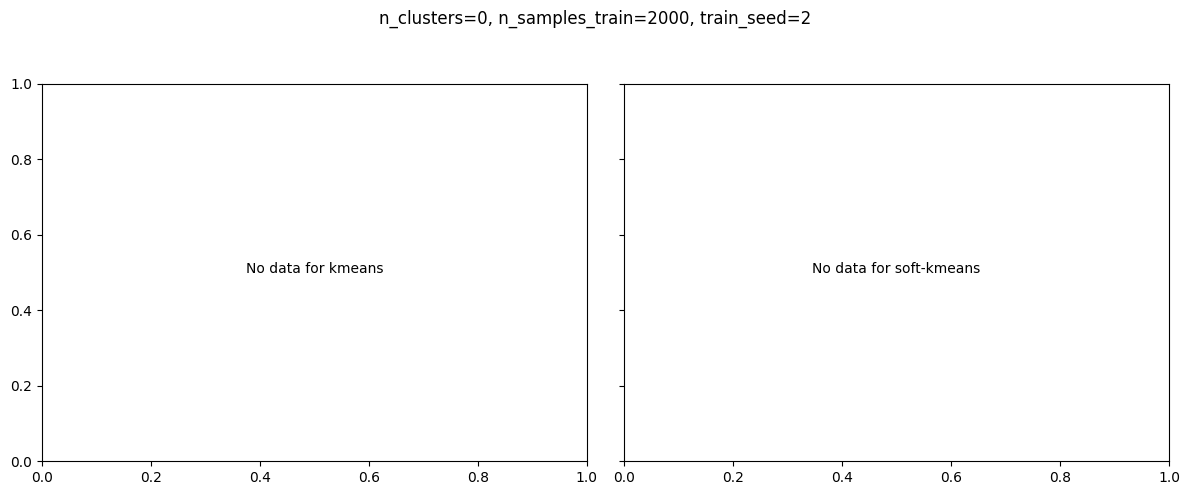

In [226]:
partionning_space= "true_proba_error"
n_samples_train=2000
n_samples_test=100000
n_clusters=0

seed_train=2
seed_test=-1
init_scheme = {"kmeans" : "k-means++", "soft-kmeans" : "kmeans++"}

clustering_seed = {"kmeans" : 0, "soft-kmeans" : 0}
clustering_space = "true_proba_error"
method=["kmeans", "soft-kmeans"]


plot_experiment_histograms_(
    df,
    n_samples_train=n_samples_train,
    n_samples_test=n_samples_test,
    n_clusters=n_clusters,
    methods=method,
    seed_train=seed_train,
    seed_test=seed_test,
    partionning_space= partionning_space,
    init_scheme=init_scheme,
    clustering_seed=clustering_seed
)


In [197]:
plot_experiment_histograms_(
    df,
    n_samples_train=12000,
    n_samples_test=100000,
    n_clusters=10,
    method="soft-kmeans",
    seed_train=1,
    seed_test=-1,
    partionning_space="true_proba_error"
)


TypeError: plot_experiment_histograms_() got an unexpected keyword argument 'method'

In [136]:

n_samples_train=12000,
n_samples_test=100000,
n_clusters=10.0,
method="soft-kmeans"
seed_train=1,
seed_test=-1,
partionning_space="true_proba_error"
labels=('No error', 'Error')

df_c = df[
    (df["data_n_samples_train"] == n_samples_train) &
              (df["data_n_samples_test"] == n_samples_test) &
              (df["clustering_n_clusters"] == n_clusters) &
              df["clustering_name"].eq(method) &
              (df["data_seed_train"] == seed_train) &
              (df["data_seed_test"] == seed_test) &
              (df["clustering_space"].eq(partionning_space))
               ]
df_c
# exp_nb =df_c["experiment_folder"].item()


# exp_train_predictions = pd.read_csv(
#             os.path.join(RESULTS_DIR, exp_nb, "detector_train_predictions.csv")
#         )

# pkl_path = os.path.join(RESULTS_DIR, exp_nb, "clustering_algo.pkl")
# print("Exists:", os.path.exists(pkl_path))
# print("Size (bytes):", os.path.getsize(pkl_path))
# from joblib import dump, load


# clustering_algo = load(pkl_path)
# xs = np.linspace(0, 1, 100)
# clusters = clustering_algo.predict(xs.reshape(-1, 1))
# plt.plot(xs, clusters)
# changes = np.where(clusters[:-1] != clusters[1:])[0]
# # mid-points between samples
# boundaries = (xs[changes] + xs[changes+1]) / 2
# for b in boundaries:
#     plt.axvline(b, color='k', linestyle='--', linewidth=1.2)
# # # with open(os.path.join(RESULTS_DIR, exp_nb, "clustering_algo.pkl"), "rb") as f:
# # #     clustering_algo = pickle.load(f)

# # bins = 30
# # # define common bins
# # score_col = "embs"
# # label_col = "detector_labels"
# # all_scores = exp_train_predictions[score_col]
# # bin_edges = np.linspace(all_scores.min(), all_scores.max(), bins)

# # # split scores by true label
# # scores_0 = exp_train_predictions.loc[~exp_train_predictions[label_col], score_col]
# # scores_1 = exp_train_predictions.loc[exp_train_predictions[label_col], score_col]

# # # plot histograms
# # plt.hist(scores_0, bins=bin_edges, density=True, alpha=0.5, label=labels[0])
# # plt.hist(scores_1, bins=bin_edges, density=True, alpha=0.5, label=labels[1])
# # plt.legend()
# # plt.show()

data_n_samples_train  data_n_samples_test  data_batch_size_train  \
2569                 12000               100000                 100000   

      data_batch_size_test  data_seed_train  data_seed_test clustering_name  \
2569                100000                1              -1     soft-kmeans   

      clustering_n_clusters  clustering_seed clustering_init_scheme  \
2569                   10.0              0.0                 kmeans   

      clustering_space clustering_cov_type  clustering_temperature  \
2569  true_proba_error           spherical                     NaN   

     clustering_normalize_gini  experiment_datetime experiment_folder  \
2569                       NaN  2025-04-23_17-22-08   experiment_4894   

      fpr_train  tpr_train  thr_train   fpr_val   tpr_val   thr_val  inertia  
2569   0.214425    0.97619   0.080133  0.211044  0.973826  0.080133  3.14316

**n_cluster =2**

      data_n_samples_train  data_n_samples_test  data_batch_size_train  \
3189                  9000               100000                 100000   

      data_batch_size_test  data_seed_train  data_seed_test clustering_name  \
3189                100000                4              -1          kmeans   

      clustering_n_clusters  clustering_seed clustering_init_scheme  ...  \
3189                    2.0              0.0              k-means++  ...   

     experiment_folder fpr_train tpr_train thr_train  fpr_val  tpr_val  \
3189   experiment_4820       1.0       1.0  0.039029      1.0      1.0   

       thr_val    inertia  clustering_temperature  clustering_normalize_gini  
3189  0.039029  61.686474                     NaN                       None  

[1 rows x 23 columns]


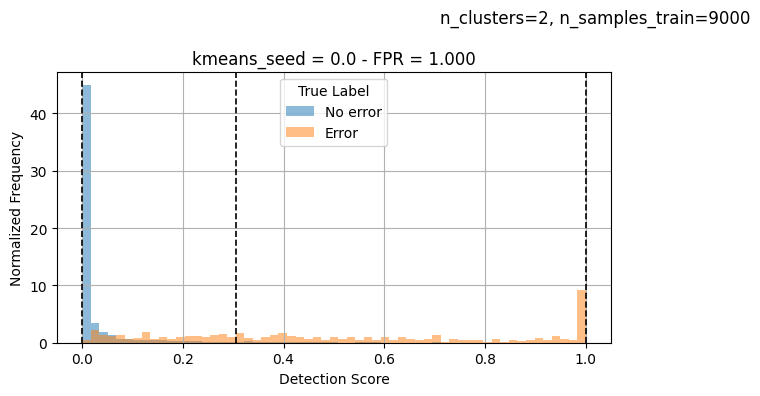

In [154]:
plot_experiment_histograms_(
    df,
    n_samples_train=9000,
    n_samples_test=100000,
    n_clusters=2,
    method="kmeans",
    seed_train=4,
    seed_test=-1,
    partionning_space="true_proba_error"
)


**n_sample == 10**

      data_n_samples_train  data_n_samples_test  data_batch_size_train  \
2680                   300               100000                 100000   

      data_batch_size_test  data_seed_train  data_seed_test clustering_name  \
2680                100000                4              -1          kmeans   

      clustering_n_clusters  clustering_seed clustering_init_scheme  ...  \
2680                   20.0              0.0              k-means++  ...   

     experiment_folder fpr_train tpr_train thr_train  fpr_val   tpr_val  \
2680   experiment_7126  0.174377       1.0  0.402025  0.21462  0.975095   

      thr_val   inertia  clustering_temperature  clustering_normalize_gini  
2680  0.35066  0.006633                     NaN                        NaN  

[1 rows x 23 columns]


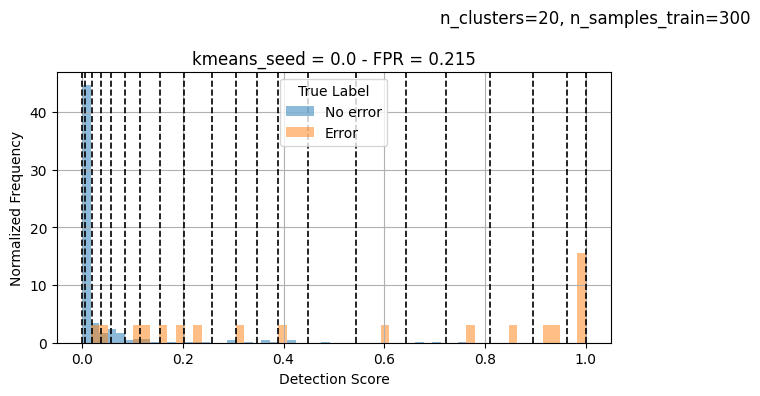

      data_n_samples_train  data_n_samples_test  data_batch_size_train  \
1382                   300               100000                 100000   

      data_batch_size_test  data_seed_train  data_seed_test clustering_name  \
1382                100000                4              -1     soft-kmeans   

      clustering_n_clusters  clustering_seed clustering_init_scheme  ...  \
1382                   20.0              0.0               kmeans++  ...   

     experiment_folder fpr_train tpr_train thr_train   fpr_val   tpr_val  \
1382   experiment_5334  0.174377       1.0  0.434396  0.210436  0.973509   

      thr_val   inertia  clustering_temperature  clustering_normalize_gini  
1382  0.37667  3.117204                     NaN                        NaN  

[1 rows x 23 columns]
jj ../../synth_results/asymp_exp/experiment_5334/clustering_algo.pkl


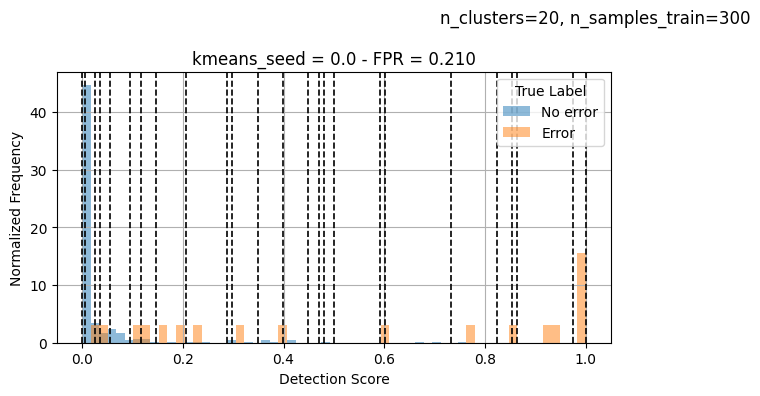

In [155]:
plot_experiment_histograms_(
    df,
    n_samples_train=300,
    n_samples_test=100000,
    n_clusters=20,
    method="kmeans",
    seed_train=4,
    seed_test=-1,
    partionning_space="true_proba_error"
)

plot_experiment_histograms_(
    df,
    n_samples_train=300,
    n_samples_test=100000,
    n_clusters=20,
    method="soft-kmeans",
    seed_train=4,
    seed_test=-1,
    partionning_space="true_proba_error"
)


In [78]:
pd.set_option('display.max_columns', None)   # show all columns
pd.set_option('display.width', 0)    
print(df[
    (df["clustering_name"] == "kmeans") & 
    (df["clustering_n_clusters"] == 20) &
    (df["data_n_samples_train"] == 10000) &
    (df["data_seed_train"] == 4)
    
    ])

      data_n_samples_train  data_n_samples_test  data_batch_size_train  \
160                  10000               100000                 100000   
317                  10000               100000                 100000   
823                  10000               100000                 100000   
1478                 10000               100000                 100000   
3490                 10000               100000                 100000   

      data_batch_size_test  data_seed_train  data_seed_test clustering_name  \
160                 100000                4              -1          kmeans   
317                 100000                4              -1          kmeans   
823                 100000                4              -1          kmeans   
1478                100000                4              -1          kmeans   
3490                100000                4              -1          kmeans   

      clustering_n_clusters  clustering_seed clustering_init_scheme  \
160      

      data_n_samples_train  data_n_samples_test  data_batch_size_train  \
1210                100000               100000                 100000   
1216                100000               100000                 100000   
4745                100000               100000                 100000   
5103                100000               100000                 100000   

      data_batch_size_test  data_seed_train  data_seed_test clustering_name  \
1210                100000                4              -1          kmeans   
1216                100000                4              -1          kmeans   
4745                100000                4              -1          kmeans   
5103                100000                4              -1          kmeans   

      clustering_n_clusters  clustering_seed clustering_init_scheme  ...  \
1210                   20.0              4.0              k-means++  ...   
1216                   20.0              3.0              k-means++  ...   
4745 

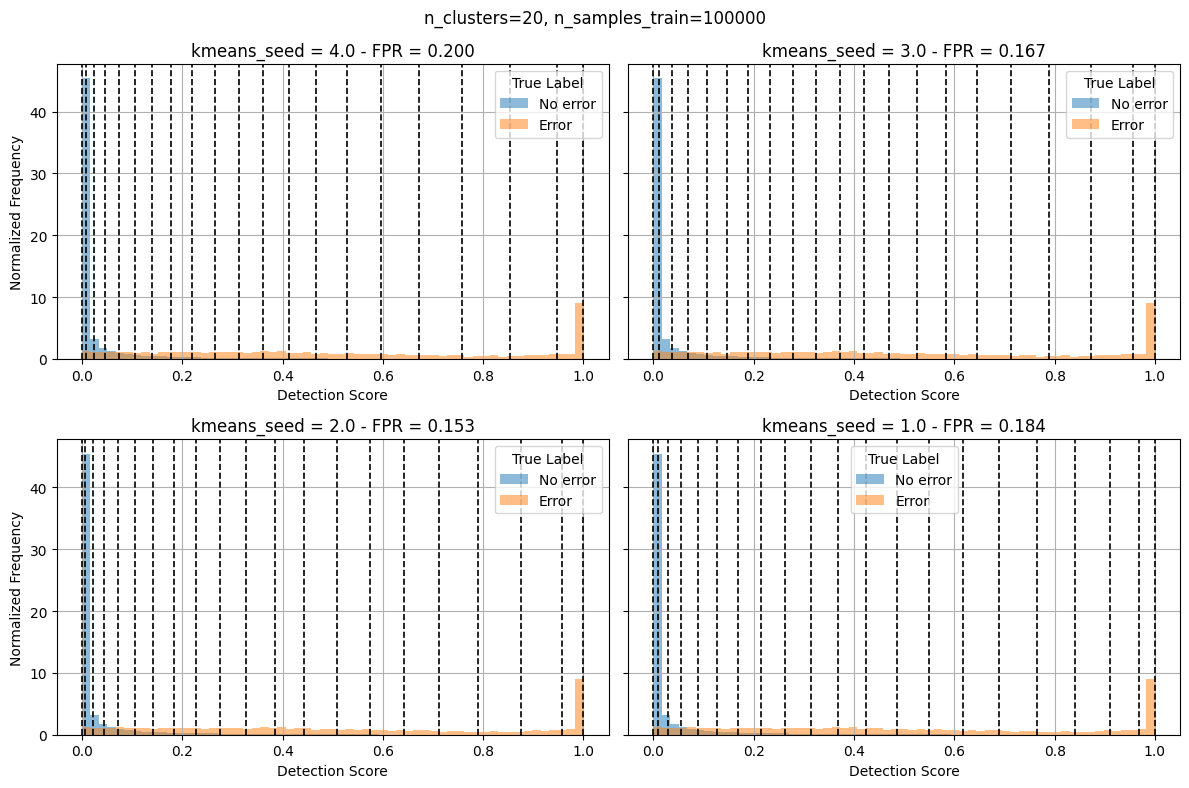

In [27]:
# plot_experiment_histograms_(
#     df,
#     n_samples_train=1000,
#     n_samples_test=100000,
#     n_clusters=20,
#     method="kmeans",
#     seed_train=4,
#     seed_test=-1,
#     partionning_space="true_proba_error"
# )

# plot_experiment_histograms_(
#     df,
#     n_samples_train=10000,
#     n_samples_test=100000,
#     n_clusters=20,
#     method="kmeans",
#     seed_train=4,
#     seed_test=-1,
#     partionning_space="true_proba_error"
# )

plot_experiment_histograms_(
    df,
    n_samples_train=100000,
    n_samples_test=100000,
    n_clusters=20,
    method="kmeans",
    seed_train=4,
    seed_test=-1,
    partionning_space="true_proba_error"
)

**We now suppose that we don't have access to the true probability of error $$ \eta(x) = \mathbb{P}\{ f(x) \neq Y \}.$$**
**Insted, we approximate it with the gini index**
$$\mathrm{gini}(x) = 1 - \sum_{y \in \mathcal{Y}} P^2_{\hat{Y} \mid X}(y \mid x)$$

**Q1: Is $\mathrm{gini}(x)$ a good approximation of $\eta(x)$ ?**

In [5]:
temperature = 1
normalize_gini = False
seed_test = -1
gini_experiment = df[
    (df["clustering_name"] == "gini") & 
    (df["clustering_temperature"] == temperature) & 
    (df["clustering_normalize_gini"] == normalize_gini) &
    (df["data_seed_test"] == seed_test) 
]
bayes_experiment = df[
    (df["clustering_name"] == "bayes") &
    (df["data_seed_test"] == seed_test) 
]
print("Gini Detector FPR:", gini_experiment["fpr_val"].item())
print("Bayes Detector FPR:", bayes_experiment["fpr_val"].item())


Gini Detector FPR: 0.2999060792349727
Bayes Detector FPR: 0.151212431693989


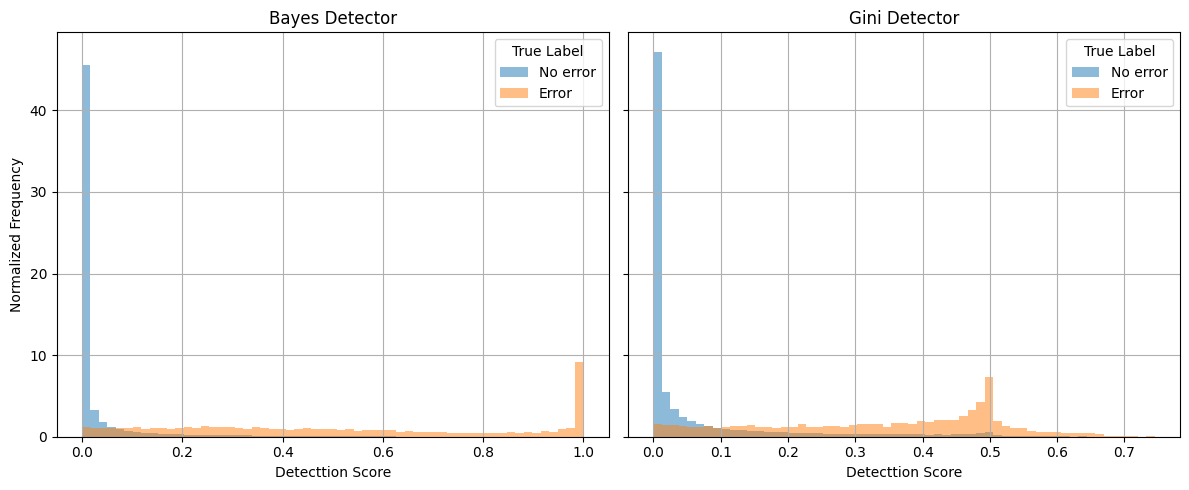

In [58]:
gini_experiment_nb = gini_experiment["experiment_folder"].item()
gini_predictions = pd.read_csv(os.path.join(RESULTS_DIR, gini_experiment_nb,"detector_predictions.csv"))


bayes_experiment_dir = bayes_experiment["experiment_folder"].item()
bayes_predictions = pd.read_csv(os.path.join(RESULTS_DIR, bayes_experiment_dir,"detector_predictions.csv"))

plot_experiment_histograms({"Bayes Detector" :bayes_predictions, "Gini Detector" :gini_predictions})

In [67]:
df["clustering_name"].value_counts(dropna=False)

clustering_name
kmeans         3710
soft-kmeans    2200
uniform        1340
gini              6
bayes             1
Name: count, dtype: int64

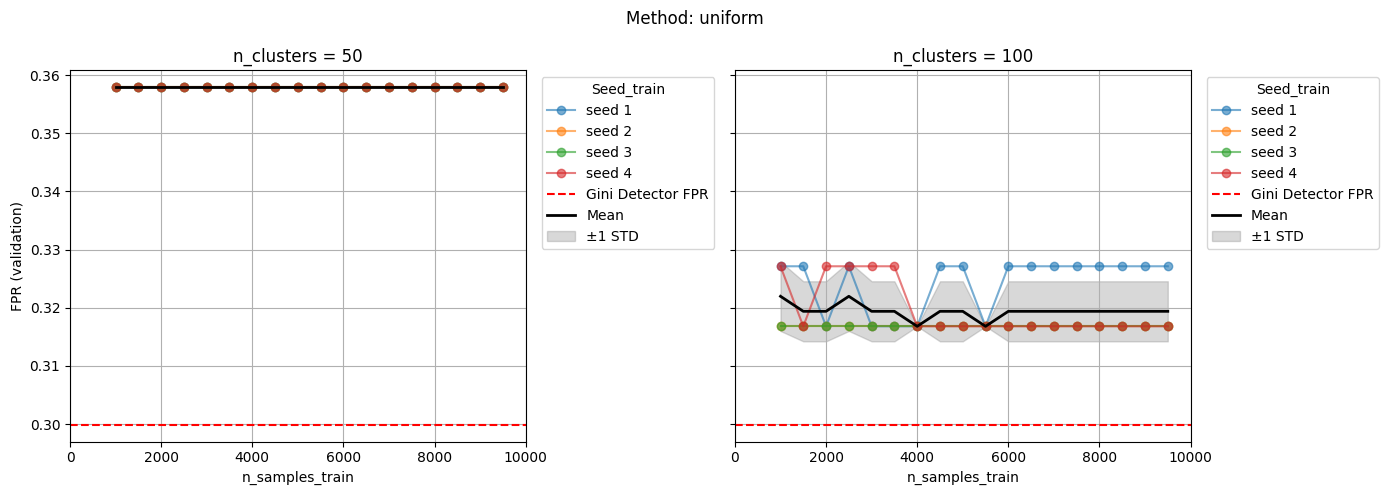

In [ ]:
plot_fpr_2(
    df,
    method="uniform",
    partionning_space="gini",
    cluster_values = [50,100],
    n_samples_train_inf=0,
    n_samples_train_sup=10000,
    seed_test=-1)

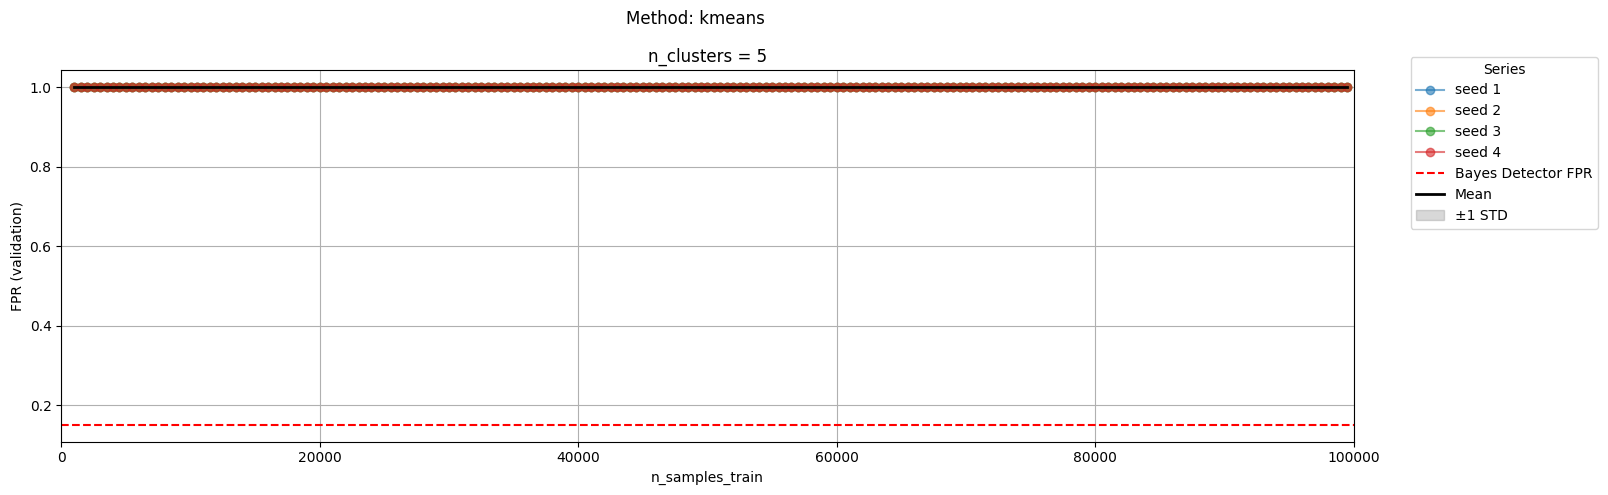

In [23]:
plot_fpr(df, seed_test=seed_test, cluster_values = [5],  method = "kmeans", n_samples_train_inf = 0, n_samples_train_sup = 100000)

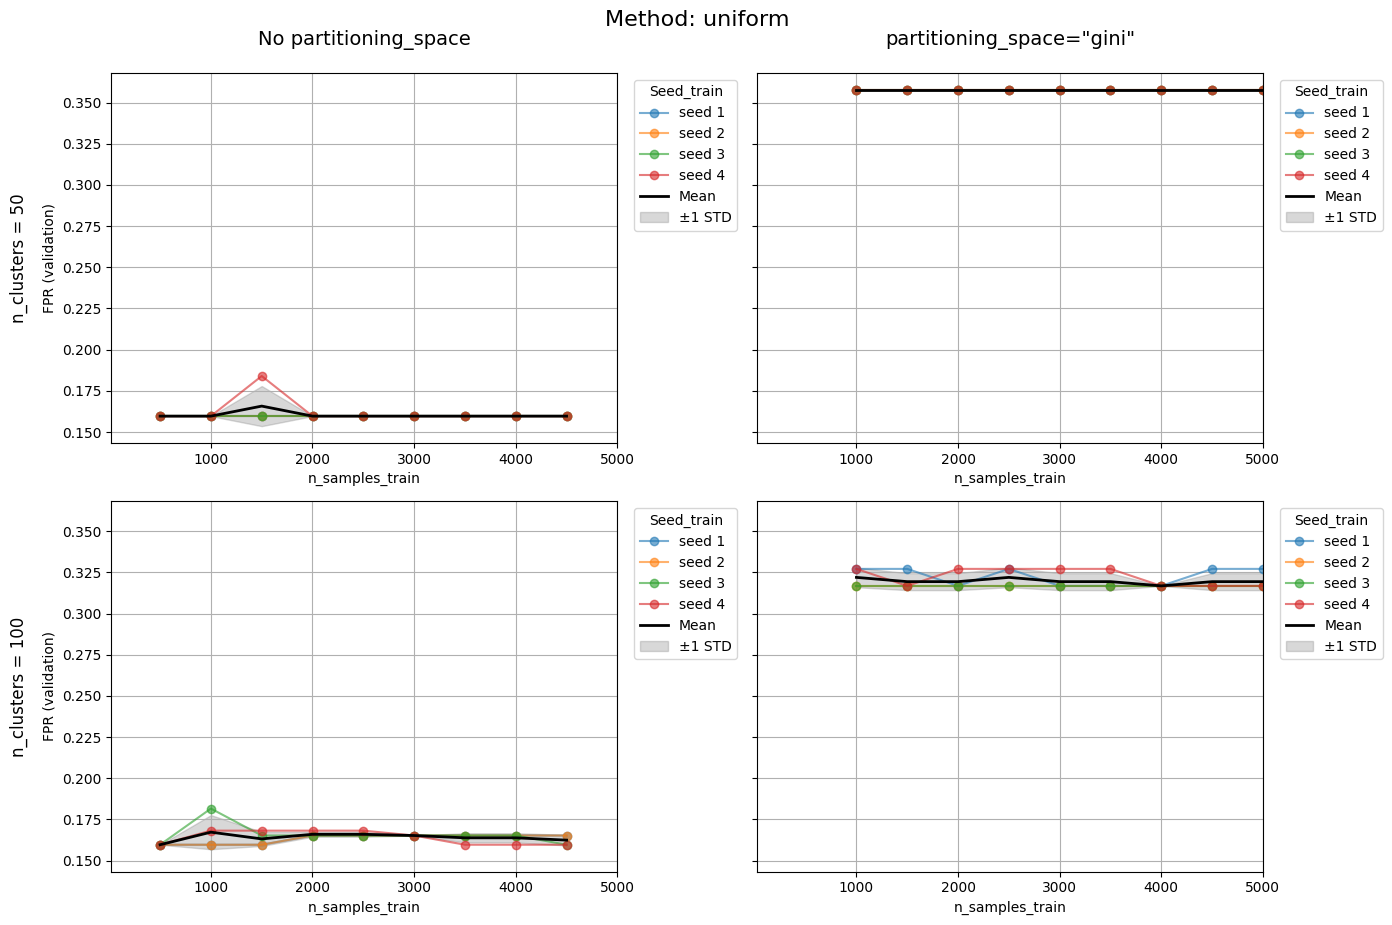

In [50]:
import numpy as np

def plot_fpr_partitioning(
    df,
    cluster_values,
    method="uniform",
    seed_test=None,
    n_samples_train_inf=None,
    n_samples_train_sup=None,
    ylim=None,
    x_interval=None
):
    """
    Plot FPR vs n_samples_train for two partitioning_space settings (NaN vs "gini")
    across multiple n_clusters, for a given method.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns ['n_clusters', 'n_samples_train', 'fpr_val',
        'seed_test', 'seed_train', 'method', 'partitioning_space'].
    cluster_values : list of int
        One row per cluster value.
    method : {"uniform", "kmeans"}
        Which sampling method to filter on.
    seed_test : int
        seed_test value to filter on.
    n_samples_train_inf : int
        Minimum n_samples_train to include.
    n_samples_train_sup : int
        Maximum n_samples_train to include.
    ylim : tuple or None
        Y-axis limits; e.g. (0,0.1).
    x_interval : int or None
        If provided, sets x‑axis ticks every `x_interval`.
    """
    # set up grid
    n = len(cluster_values)
    fig, axes = plt.subplots(n, 2, figsize=(14, 5*n), sharey=True)
    fig.suptitle(f"Method: {method}", fontsize=16, y=0.92)

    col_filters = [
        (df["partionning_space"].isna(),        "No partitioning_space"),
        (df["partionning_space"] == "gini",     'partitioning_space="gini"'),
    ]

    # column titles
    for j, (_, title) in enumerate(col_filters):
        axes[0, j].set_title(title, fontsize=14, pad=20)

    for i, k in enumerate(cluster_values):
        for j, (mask, _) in enumerate(col_filters):
            ax = axes[i, j]

            # filter for this cell
            df_c = df[
                (df["n_clusters"] == k) &
                (df["method"] == method) &
                mask &
                (df["seed_test"] == seed_test) &
                (df["n_samples_train"] >= n_samples_train_inf) &
                (df["n_samples_train"] <= n_samples_train_sup) &
                df["fpr_val"].notnull()
            ]

            # plot each seed_train
            for seed_train in sorted(df_c["seed_train"].unique()):
                df_s = df_c[df_c["seed_train"] == seed_train].sort_values("n_samples_train")
                ax.plot(
                    df_s["n_samples_train"],
                    df_s["fpr_val"],
                    marker="o",
                    linestyle="-",
                    alpha=0.6,
                    label=f"seed {seed_train}"
                )

            # mean ± std
            stats = (
                df_c
                .groupby("n_samples_train")["fpr_val"]
                .agg(["mean", "std"])
                .reset_index()
            )
            ax.plot(
                stats["n_samples_train"],
                stats["mean"],
                color="black",
                linewidth=2,
                label="Mean"
            )
            ax.fill_between(
                stats["n_samples_train"],
                stats["mean"] - stats["std"],
                stats["mean"] + stats["std"],
                color="gray",
                alpha=0.3,
                label="±1 STD"
            )

            # axes decor
            ax.set_xlabel("n_samples_train")
            if j == 0:
                ax.set_ylabel("FPR (validation)")
            ax.set_xlim(n_samples_train_inf, n_samples_train_sup)
            if ylim is not None:
                ax.set_ylim(ylim)
            ax.grid(True)

            # custom x-ticks
            if x_interval is not None:
                ticks = list(range(
                    n_samples_train_inf,
                    n_samples_train_sup + 1,
                    x_interval
                ))
                ax.set_xticks(ticks)

            # annotate row label on left
            if j == 0:
                ax.text(
                    -0.2, 0.5,
                    f"n_clusters = {k}",
                    transform=ax.transAxes,
                    rotation=90,
                    va="center",
                    fontsize=12
                )

            ax.legend(title="Seed_train", bbox_to_anchor=(1.02, 1), loc="upper left")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_fpr_partitioning(
    df=df,
    cluster_values=[50, 100],
    method="uniform",
    seed_test=-1,
    n_samples_train_inf=20,
    n_samples_train_sup=5000,
    # ylim=(0.15, 0.2)
)

**Best n_cluster**

BE carefull, the test seed are not equivalent

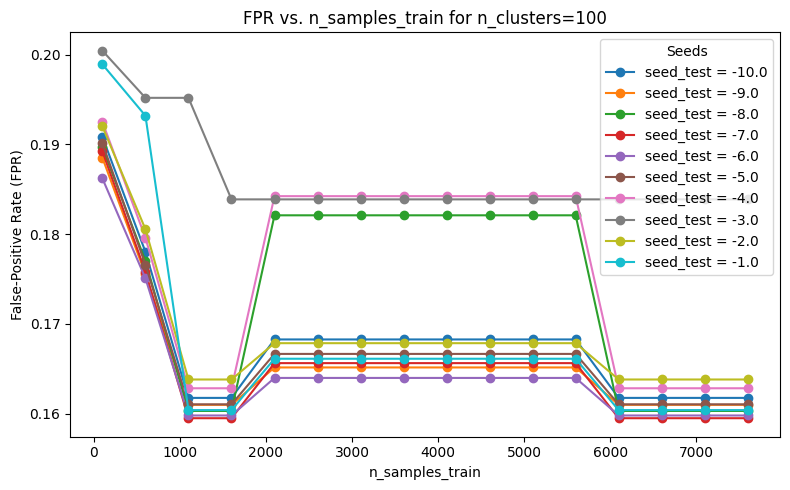

In [45]:
import matplotlib.pyplot as plt

# pick the one cluster-value you care about
cluster_value = 100

# filter down
n_samples_train_inf = 0
n_samples_train_sup = 1000000
# 1. filter out rows with n_samples_train < 1000


df_c = df[
   (df['n_clusters'] ==  cluster_value )& \
    (df['n_samples_train'] >= n_samples_train_inf) & \
    (df['n_samples_train'] <= n_samples_train_sup) & \
    df['fpr_train'].notnull() & \
    (df['seed_train'] == 1)
    ]

plt.figure(figsize=(8,5))
for seed_test in sorted(df_c['seed_test'].unique()):
    df_seed = (
        df_c[df_c['seed_test'] == seed_test]
        .sort_values('n_samples_train')
    )
    plt.plot(
        df_seed['n_samples_train'],
        df_seed['fpr_val'],
        marker='o',
        linestyle='-',
        label=f'seed_test = {seed_test}'
    )

plt.xlabel('n_samples_train')
plt.ylabel('False‑Positive Rate (FPR)')
plt.title(f'FPR vs. n_samples_train for n_clusters={cluster_value}')
plt.legend(title='Seeds')
plt.tight_layout()
plt.show()
